### Imports

In [22]:
import sqlite3 as sql
import pandas as pd
import torch.nn as nn
import torch
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.preprocessing import OneHotEncoder
import tqdm

conn = sql.connect("states.db")
tables_query = "SELECT name FROM sqlite_master WHERE type='table';"
tables_df = pd.read_sql(tables_query, conn)
table_names = tables_df['name'].tolist()[1:]


dataframes = {}
for table_name in table_names:
    dataframes[table_name] = pd.read_sql(f"SELECT * FROM {table_name}", conn)
conn.close()

In [3]:
unemployment_rate = dataframes['unemployment_rate']
state_survival_rates = dataframes['survival_rates']
industry_survival_rates = dataframes['industry_survival_rates']
establishments = dataframes['establishments']

### Data reformatting

Reformat into 1530 samples for state data

In [4]:
state_survival_rates_filtered = state_survival_rates[state_survival_rates["Year Established"] != state_survival_rates["Year"]]
state_survival_rates_filtered.loc[:, "Year"] = state_survival_rates_filtered["Year"].astype('int')
state_survival_rates_filtered.loc[:, "Survival Rates of Previous Year's Survivors"] = state_survival_rates_filtered["Survival Rates of Previous Year's Survivors"].astype('float')
state_survival_rates_filtered.loc[:, 'Surviving Establishments'] = state_survival_rates_filtered['Surviving Establishments'].str.replace(',', '').astype(int)
state_survival_rates_grouped = state_survival_rates_filtered.groupby(["Year", "State"]).apply(lambda x: np.average(x['Survival Rates of Previous Year\'s Survivors'], weights=x['Surviving Establishments']))
#print(state_survival_rates_filtered.head())

Get reformatted industry data

In [5]:
industry_survival_rates_filtered = industry_survival_rates[industry_survival_rates["Year Established"] != industry_survival_rates["Year"]]
industry_survival_rates_filtered.loc[:, "Year"] = industry_survival_rates_filtered["Year"].astype('int')
industry_survival_rates_filtered.loc[:, "Survival Rates of Previous Year's Survivors"] = industry_survival_rates_filtered["Survival Rates of Previous Year's Survivors"].astype('float')
industry_survival_rates_filtered.loc[:, 'Surviving Establishments'] = industry_survival_rates_filtered['Surviving Establishments'].str.replace(',', '').astype(int)
industry_survival_rates_grouped = industry_survival_rates_filtered.groupby(["Year", "Industry"]).apply(lambda x: np.average(x['Survival Rates of Previous Year\'s Survivors'], weights=x['Surviving Establishments']))

print(industry_survival_rates_filtered.head())

  Year Established  Year Surviving Establishments  \
1             1994  1995                     5537   
2             1994  1996                     4826   
3             1994  1997                     4406   
4             1994  1998                     4005   
5             1994  1999                     3729   

  Total Employment of Survivors Survival Rates Since Birth  \
1                        51,066                       82.1   
2                        48,263                       71.6   
3                        47,634                       65.4   
4                        45,444                       59.4   
5                        39,377                       55.3   

  Survival Rates of Previous Year's Survivors Average Employment of Survivors  \
1                                        82.1                             9.2   
2                                        87.2                            10.0   
3                                        91.3                    

In [6]:
total_survival_rate = pd.concat([state_survival_rates_filtered, industry_survival_rates_filtered])
total_survival_rate_grouped = total_survival_rate.groupby(["Year"]).apply(lambda x: np.average(x['Survival Rates of Previous Year\'s Survivors'], weights=x['Surviving Establishments']))
# ^ overall business survival rate by year



In [10]:
conn = sql.connect("states.db")
state_survival_rates_grouped.unstack().to_sql("states_grouped", conn, if_exists="replace", index=False)
industry_survival_rates_grouped.to_sql("industry_grouped", conn, if_exists="replace", index=False)
total_survival_rate_grouped.to_sql("total_grouped", conn, if_exists="replace", index=False)
conn.close()

### Bayesian Approach

In [11]:
import pandas as pd
import numpy as np

def compute_bayesian_survival_probabilities(state_survival_rates_filtered, industry_survival_rates_filtered):
    probabilities = []
    years = state_survival_rates_filtered['Year'].unique() # loop through the unique years in the list

    # P(Survival | State, Sector) = P(Survival) * P(State, Sector | Survival)P(State, Sector)
    
    for year in years:
        df_s = state_survival_rates_filtered[state_survival_rates_filtered['Year'] == year] # data during the current iterated year
        df_i = industry_survival_rates_filtered[industry_survival_rates_filtered['Year'] == year]
        df_state = df_s.copy()
        df_industry = df_i.copy()
       
        df_state.loc[:, 'Total Establishments'] = df_s['Surviving Establishments'].shift(1).fillna(df_s['Surviving Establishments'])
        # total establishments is just the surviving number from the last year
        df_industry.loc[:, 'Total Establishments'] = df_i['Surviving Establishments'].shift(1).fillna(df_i['Surviving Establishments'])
        # making sure the first one has data to shift down also
        
        total_state_survivors = df_state['Surviving Establishments'].sum()
        total_industry_survivors = df_industry['Surviving Establishments'].sum()
        total_survivors = (total_state_survivors + total_industry_survivors) / 2  # still using weighted average for now
        
        total_state_establishments = df_state['Total Establishments'].sum()
        total_industry_establishments = df_industry['Total Establishments'].sum()
        total_establishments = (total_state_establishments + total_industry_establishments) / 2
        
        p_survival = total_survivors / total_establishments if total_establishments > 0 else 0  # P(Survival)
        
        # Compute P(State, Sector) - probability of being in a state-sector
        df_state.loc[:, 'P_State'] = df_state['Total Establishments'] / total_state_establishments
        df_industry.loc[:, 'P_Sector'] = df_industry['Total Establishments'] / total_industry_establishments
        
        # Compute P(State | Survival) and P(Sector | Survival)
        df_state['P_State_given_Survival'] = df_state['Surviving Establishments'] / total_state_survivors
        df_industry['P_Sector_given_Survival'] = df_industry['Surviving Establishments'] / total_industry_survivors
        
        # Merge datasets on state and industry
        df_merged = pd.merge(df_state, df_industry, on='Year', suffixes=('_State', '_Sector'))
        
        # Compute P(Survival | State, Sector) using Bayesian formula
        df_merged['P_Survival_given_State_Sector'] = (
            p_survival * df_merged['P_State_given_Survival'] * df_merged['P_Sector_given_Survival'] /
            (df_merged['P_State'] * df_merged['P_Sector'])
        ).fillna(0)  # Handle divide-by-zero cases
        
        probabilities.append(df_merged[['Year', 'State', 'Industry', 'P_Survival_given_State_Sector']])
    
    return pd.concat(probabilities)

# Example usage

bayesian_survival_probabilities = compute_bayesian_survival_probabilities(state_survival_rates_filtered, industry_survival_rates_filtered)
print(bayesian_survival_probabilities.head())


   Year State                                       Industry  \
0  1995    AL     Agriculture, Forestry, Fishing and Hunting   
1  1995    AL  Mining, Quarrying, and Oil and Gas Extraction   
2  1995    AL                                      Utilities   
3  1995    AL                                   Construction   
4  1995    AL                                  Manufacturing   

   P_Survival_given_State_Sector  
0                       0.976189  
1                       0.254581  
2                       0.319087  
3                     100.164821  
4                       0.442390  


### Non-Bayesian approach

In [12]:
results = []
for (year, state), state_val in state_survival_rates_grouped.items():
    for (ind_year, industry), ind_val in industry_survival_rates_grouped.items():
        if year == ind_year:
            result = (year, state, industry), (state_val * ind_val) / total_survival_rate_grouped[year]
            results.append(result)

result = pd.Series(dict(results))
unemployment_rate["Year"] = unemployment_rate["Year"].astype('int')

In [13]:
state_df = state_survival_rates_grouped.unstack()
industry_df = industry_survival_rates_grouped.unstack()

In [14]:
numerical_state = dict(zip(state_df.columns, range(len(state_df.columns))))
numerical_state_rev = dict(zip(range(len(state_df.columns)), state_df.columns))
numerical_industry = dict(zip(industry_df.columns, range(len(industry_df.columns))))
numerical_industry_rev = dict(zip(range(len(industry_df.columns)), industry_df.columns))

In [15]:
pre_df = []
for year in result.index.get_level_values(0).unique():
    for state in state_df.columns:
        unemployment = unemployment_rate[(unemployment_rate["Year"] == year) & (unemployment_rate["State"] == state)]["Unemployment Rate"]
        for industry in industry_df.columns:
            response = result[year, state, industry]
            pre_df.append((year, numerical_state[state], numerical_industry[industry], float(unemployment.iloc[0]), response))
final_dataset = pd.DataFrame(pre_df, columns=["Year", "State", "Industry", "Unemployment Rate", "Response"])
             

In [351]:
final_dataset

,Year,State,Industry,Unemployment Rate,Response
0,1995,0,0,7.325,78.031198
1,1995,0,1,7.325,75.687333
2,1995,0,2,7.325,80.179742
3,1995,0,3,7.325,76.859266
4,1995,0,4,7.325,73.148145
...,...,...,...,...,...
29065,2024,50,14,3.000,90.948429
29066,2024,50,15,3.000,91.994540
29067,2024,50,16,3.000,87.815405
29068,2024,50,17,3.000,90.209787


### Model

In [180]:
class EconDataset(Dataset):
    def __init__(self, data, state_col, industry_col, unemployment_col, response_col):
        self.data = data.copy()
        self.state_col = state_col
        self.industry_col = industry_col
        self.unemployment_col = unemployment_col
        self.response_col = response_col
        self.state_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        self.industry_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        self._preprocess_data()

    def _preprocess_data(self):
        self.encoded_states = self.state_encoder.fit_transform(self.data[[self.state_col]]) # Applying one-hot encoding to the state column
        self.encoded_industries = self.industry_encoder.fit_transform(self.data[[self.industry_col]]) # Applying one-hot encoding to the industry
        self.unemployment_stats = self.data[self.unemployment_col].values.reshape(-1, 1) # Turns into column vector
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        state = self.encoded_states[idx]
        industry = self.encoded_industries[idx]
        unemployment = self.unemployment_stats[idx]
        predictor = np.concatenate((unemployment, state, industry), axis=0)
        response = self.data[self.response_col].values[idx]
        return torch.tensor(predictor, dtype=torch.float32), torch.tensor(response, dtype=torch.float32).view(1) #Response is reshaped to a column vector.

In [255]:
class SurvivalRateModel(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size = 1):
        super(SurvivalRateModel, self).__init__()

        # Define layers:
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size1),
            nn.ReLU(),
            nn.Linear(hidden_size1, hidden_size2),
            nn.ReLU(),
            nn.Linear(hidden_size2, output_size)
        )

    def forward(self, x):
        return self.layers(x)

    
    def train_step(self, x, y, criterion, optimizer):
        optimizer.zero_grad()
        outputs = self(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        return loss.item()
    
    def train_loop(self, dataloader, num_epochs=100, learning_rate=0.01, device = "cpu", suppress=False):
        self.to(device)
        criterion = nn.MSELoss()
        loss_cache = []
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        self.train() #set model to train mode.
        for epoch in tqdm.tqdm(range(num_epochs), desc="Training Epochs"):
            total_loss = 0
            for x, y in dataloader:
                x, y = x.to(device), y.to(device)
                loss = self.train_step(x, y, criterion, optimizer)
                loss_cache.append(loss)
                total_loss += loss
            if not suppress:
                print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(dataloader):.4f}')
        return loss_cache
    def evaluate(self, dataloader, device="cpu"):
        self.to(device)
        self.eval()
        predictions = []
        actuals = []
        with torch.no_grad():
            for x, y in dataloader:
                x, y = x.to(device), y.to(device)
                outputs = self(x)
                predictions.append(outputs.cpu().numpy())
                actuals.append(y.cpu().numpy())
        return (np.concatenate(predictions), np.concatenate(actuals))
    
    def predict(self, x, device="cpu"):
        self.to(device)
        self.eval()
        with torch.no_grad():
            x = x.to(device)
            return self(x).cpu().numpy()
    

Train test split:

In [183]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
train_data, test_data = train_test_split(final_dataset, test_size=0.2, random_state=42)

# Create DataLoader for training and testing sets
train_dataset = EconDataset(train_data, "State", "Industry", "Unemployment Rate", "Response")
test_dataset = EconDataset(test_data, "State", "Industry", "Unemployment Rate", "Response")

train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [98]:
input_size = 1 + len(train_dataset.state_encoder.categories_[0]) + len(train_dataset.industry_encoder.categories_[0])
model = SurvivalRateModel(input_size=input_size, hidden_size1=120, hidden_size2=80)
loss_data = model.train_loop(train_dataloader, num_epochs=20, learning_rate=0.01, device="cpu")

Training Epochs:   5%|▌         | 1/20 [00:00<00:10,  1.73it/s]

Epoch [1/20], Loss: 21.1958


Training Epochs:  10%|█         | 2/20 [00:01<00:10,  1.72it/s]

Epoch [2/20], Loss: 3.0861


Training Epochs:  15%|█▌        | 3/20 [00:01<00:10,  1.58it/s]

Epoch [3/20], Loss: 2.8940


Training Epochs:  20%|██        | 4/20 [00:02<00:09,  1.67it/s]

Epoch [4/20], Loss: 2.7550


Training Epochs:  25%|██▌       | 5/20 [00:02<00:08,  1.74it/s]

Epoch [5/20], Loss: 2.8401


Training Epochs:  30%|███       | 6/20 [00:03<00:07,  1.75it/s]

Epoch [6/20], Loss: 2.8572


Training Epochs:  35%|███▌      | 7/20 [00:04<00:07,  1.77it/s]

Epoch [7/20], Loss: 2.9030


Training Epochs:  40%|████      | 8/20 [00:04<00:06,  1.76it/s]

Epoch [8/20], Loss: 2.8797


Training Epochs:  45%|████▌     | 9/20 [00:05<00:06,  1.76it/s]

Epoch [9/20], Loss: 2.7476


Training Epochs:  50%|█████     | 10/20 [00:05<00:05,  1.72it/s]

Epoch [10/20], Loss: 2.8445


Training Epochs:  55%|█████▌    | 11/20 [00:06<00:05,  1.72it/s]

Epoch [11/20], Loss: 2.7766


Training Epochs:  60%|██████    | 12/20 [00:06<00:04,  1.73it/s]

Epoch [12/20], Loss: 2.8106


Training Epochs:  65%|██████▌   | 13/20 [00:07<00:04,  1.62it/s]

Epoch [13/20], Loss: 2.8734


Training Epochs:  70%|███████   | 14/20 [00:08<00:03,  1.66it/s]

Epoch [14/20], Loss: 2.7914


Training Epochs:  75%|███████▌  | 15/20 [00:09<00:03,  1.46it/s]

Epoch [15/20], Loss: 2.8418


Training Epochs:  80%|████████  | 16/20 [00:09<00:02,  1.54it/s]

Epoch [16/20], Loss: 2.7316


Training Epochs:  85%|████████▌ | 17/20 [00:10<00:01,  1.55it/s]

Epoch [17/20], Loss: 2.7715


Training Epochs:  90%|█████████ | 18/20 [00:10<00:01,  1.55it/s]

Epoch [18/20], Loss: 2.7386


Training Epochs:  95%|█████████▌| 19/20 [00:11<00:00,  1.60it/s]

Epoch [19/20], Loss: 2.7373


Training Epochs: 100%|██████████| 20/20 [00:12<00:00,  1.65it/s]

Epoch [20/20], Loss: 2.8122


In [ ]:
predicted, actual = model.evaluate(test_dataloader, device="cpu")
print(f"Evaluation loss: {np.mean(abs(predicted - actual)):1.4f}")

Evaluation loss: 2.5933


Hyperparameter tuning:

In [350]:
hidden_size_1 = [70, 105, 140, 175]
hidden_size_2 = [50, 100, 150, 200]
learning_rates = [1e-4, 5e-4, 1e-3, 5e-3]
batch_epoch_size = [(64,20), (128, 10), (256, 5)]
results = {}
for h1 in hidden_size_1:
    for h2 in hidden_size_2:
        for lr in learning_rates:
            for bs, ep in batch_epoch_size:
                model = SurvivalRateModel(input_size=input_size, hidden_size1=h1, hidden_size2=h2)
                train_dataloader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
                test_dataloader = DataLoader(test_dataset, batch_size=bs, shuffle=False)
                loss_data = model.train_loop(train_dataloader, num_epochs=ep, learning_rate=lr, device="cpu", suppress=True)
                predicted, actual = model.evaluate(test_dataloader, device="cpu")
                loss = np.mean(abs(predicted - actual))
                results[(h1, h2, lr, bs, ep)] = (loss, loss_data)
                print(f"Hidden Size 1: {h1}, Hidden Size 2: {h2}, Learning Rate: {lr}, Batch Size: {bs}, Epochs: {ep}, Loss: {loss:1.4f}")

Training Epochs: 100%|██████████| 20/20 [00:13<00:00,  1.45it/s]


Hidden Size 1: 70, Hidden Size 2: 50, Learning Rate: 0.0001, Batch Size: 64, Epochs: 20, Loss: 2.8478


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.58it/s]


Hidden Size 1: 70, Hidden Size 2: 50, Learning Rate: 0.0001, Batch Size: 128, Epochs: 10, Loss: 15.1333


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Hidden Size 1: 70, Hidden Size 2: 50, Learning Rate: 0.0001, Batch Size: 256, Epochs: 5, Loss: 80.0592


Training Epochs: 100%|██████████| 20/20 [00:13<00:00,  1.45it/s]


Hidden Size 1: 70, Hidden Size 2: 50, Learning Rate: 0.0005, Batch Size: 64, Epochs: 20, Loss: 2.5912


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.75it/s]


Hidden Size 1: 70, Hidden Size 2: 50, Learning Rate: 0.0005, Batch Size: 128, Epochs: 10, Loss: 2.9571


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Hidden Size 1: 70, Hidden Size 2: 50, Learning Rate: 0.0005, Batch Size: 256, Epochs: 5, Loss: 14.0730


Training Epochs: 100%|██████████| 20/20 [00:13<00:00,  1.47it/s]


Hidden Size 1: 70, Hidden Size 2: 50, Learning Rate: 0.001, Batch Size: 64, Epochs: 20, Loss: 2.6153


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.78it/s]


Hidden Size 1: 70, Hidden Size 2: 50, Learning Rate: 0.001, Batch Size: 128, Epochs: 10, Loss: 2.6598


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


Hidden Size 1: 70, Hidden Size 2: 50, Learning Rate: 0.001, Batch Size: 256, Epochs: 5, Loss: 6.9889


Training Epochs: 100%|██████████| 20/20 [00:13<00:00,  1.48it/s]


Hidden Size 1: 70, Hidden Size 2: 50, Learning Rate: 0.005, Batch Size: 64, Epochs: 20, Loss: 2.7689


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.69it/s]


Hidden Size 1: 70, Hidden Size 2: 50, Learning Rate: 0.005, Batch Size: 128, Epochs: 10, Loss: 3.0988


Training Epochs: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Hidden Size 1: 70, Hidden Size 2: 50, Learning Rate: 0.005, Batch Size: 256, Epochs: 5, Loss: 2.7290


Training Epochs: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Hidden Size 1: 70, Hidden Size 2: 100, Learning Rate: 0.0001, Batch Size: 64, Epochs: 20, Loss: 2.6811


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.72it/s]


Hidden Size 1: 70, Hidden Size 2: 100, Learning Rate: 0.0001, Batch Size: 128, Epochs: 10, Loss: 15.2060


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Hidden Size 1: 70, Hidden Size 2: 100, Learning Rate: 0.0001, Batch Size: 256, Epochs: 5, Loss: 75.0157


Training Epochs: 100%|██████████| 20/20 [00:13<00:00,  1.45it/s]


Hidden Size 1: 70, Hidden Size 2: 100, Learning Rate: 0.0005, Batch Size: 64, Epochs: 20, Loss: 2.6069


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.72it/s]


Hidden Size 1: 70, Hidden Size 2: 100, Learning Rate: 0.0005, Batch Size: 128, Epochs: 10, Loss: 2.6609


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Hidden Size 1: 70, Hidden Size 2: 100, Learning Rate: 0.0005, Batch Size: 256, Epochs: 5, Loss: 12.7644


Training Epochs: 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]


Hidden Size 1: 70, Hidden Size 2: 100, Learning Rate: 0.001, Batch Size: 64, Epochs: 20, Loss: 2.6216


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.72it/s]


Hidden Size 1: 70, Hidden Size 2: 100, Learning Rate: 0.001, Batch Size: 128, Epochs: 10, Loss: 2.6718


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Hidden Size 1: 70, Hidden Size 2: 100, Learning Rate: 0.001, Batch Size: 256, Epochs: 5, Loss: 5.1682


Training Epochs: 100%|██████████| 20/20 [00:13<00:00,  1.45it/s]


Hidden Size 1: 70, Hidden Size 2: 100, Learning Rate: 0.005, Batch Size: 64, Epochs: 20, Loss: 2.6671


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.67it/s]


Hidden Size 1: 70, Hidden Size 2: 100, Learning Rate: 0.005, Batch Size: 128, Epochs: 10, Loss: 2.6514


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Hidden Size 1: 70, Hidden Size 2: 100, Learning Rate: 0.005, Batch Size: 256, Epochs: 5, Loss: 2.6712


Training Epochs: 100%|██████████| 20/20 [00:14<00:00,  1.40it/s]


Hidden Size 1: 70, Hidden Size 2: 150, Learning Rate: 0.0001, Batch Size: 64, Epochs: 20, Loss: 2.6704


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.70it/s]


Hidden Size 1: 70, Hidden Size 2: 150, Learning Rate: 0.0001, Batch Size: 128, Epochs: 10, Loss: 14.6821


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


Hidden Size 1: 70, Hidden Size 2: 150, Learning Rate: 0.0001, Batch Size: 256, Epochs: 5, Loss: 62.5289


Training Epochs: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Hidden Size 1: 70, Hidden Size 2: 150, Learning Rate: 0.0005, Batch Size: 64, Epochs: 20, Loss: 2.5855


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.73it/s]


Hidden Size 1: 70, Hidden Size 2: 150, Learning Rate: 0.0005, Batch Size: 128, Epochs: 10, Loss: 2.6982


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Hidden Size 1: 70, Hidden Size 2: 150, Learning Rate: 0.0005, Batch Size: 256, Epochs: 5, Loss: 11.2968


Training Epochs: 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]


Hidden Size 1: 70, Hidden Size 2: 150, Learning Rate: 0.001, Batch Size: 64, Epochs: 20, Loss: 2.6768


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.74it/s]


Hidden Size 1: 70, Hidden Size 2: 150, Learning Rate: 0.001, Batch Size: 128, Epochs: 10, Loss: 2.6307


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Hidden Size 1: 70, Hidden Size 2: 150, Learning Rate: 0.001, Batch Size: 256, Epochs: 5, Loss: 5.2555


Training Epochs: 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]


Hidden Size 1: 70, Hidden Size 2: 150, Learning Rate: 0.005, Batch Size: 64, Epochs: 20, Loss: 2.7113


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.72it/s]


Hidden Size 1: 70, Hidden Size 2: 150, Learning Rate: 0.005, Batch Size: 128, Epochs: 10, Loss: 2.6142


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]


Hidden Size 1: 70, Hidden Size 2: 150, Learning Rate: 0.005, Batch Size: 256, Epochs: 5, Loss: 2.6439


Training Epochs: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Hidden Size 1: 70, Hidden Size 2: 200, Learning Rate: 0.0001, Batch Size: 64, Epochs: 20, Loss: 2.6684


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.64it/s]


Hidden Size 1: 70, Hidden Size 2: 200, Learning Rate: 0.0001, Batch Size: 128, Epochs: 10, Loss: 12.4893


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Hidden Size 1: 70, Hidden Size 2: 200, Learning Rate: 0.0001, Batch Size: 256, Epochs: 5, Loss: 54.6404


Training Epochs: 100%|██████████| 20/20 [00:14<00:00,  1.40it/s]


Hidden Size 1: 70, Hidden Size 2: 200, Learning Rate: 0.0005, Batch Size: 64, Epochs: 20, Loss: 2.5981


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.68it/s]


Hidden Size 1: 70, Hidden Size 2: 200, Learning Rate: 0.0005, Batch Size: 128, Epochs: 10, Loss: 2.7277


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Hidden Size 1: 70, Hidden Size 2: 200, Learning Rate: 0.0005, Batch Size: 256, Epochs: 5, Loss: 9.9540


Training Epochs: 100%|██████████| 20/20 [00:14<00:00,  1.41it/s]


Hidden Size 1: 70, Hidden Size 2: 200, Learning Rate: 0.001, Batch Size: 64, Epochs: 20, Loss: 2.5869


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.68it/s]


Hidden Size 1: 70, Hidden Size 2: 200, Learning Rate: 0.001, Batch Size: 128, Epochs: 10, Loss: 2.6381


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Hidden Size 1: 70, Hidden Size 2: 200, Learning Rate: 0.001, Batch Size: 256, Epochs: 5, Loss: 3.3747


Training Epochs: 100%|██████████| 20/20 [00:14<00:00,  1.41it/s]


Hidden Size 1: 70, Hidden Size 2: 200, Learning Rate: 0.005, Batch Size: 64, Epochs: 20, Loss: 2.7209


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.68it/s]


Hidden Size 1: 70, Hidden Size 2: 200, Learning Rate: 0.005, Batch Size: 128, Epochs: 10, Loss: 2.6004


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Hidden Size 1: 70, Hidden Size 2: 200, Learning Rate: 0.005, Batch Size: 256, Epochs: 5, Loss: 2.7146


Training Epochs: 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]


Hidden Size 1: 105, Hidden Size 2: 50, Learning Rate: 0.0001, Batch Size: 64, Epochs: 20, Loss: 2.7380


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.67it/s]


Hidden Size 1: 105, Hidden Size 2: 50, Learning Rate: 0.0001, Batch Size: 128, Epochs: 10, Loss: 15.7955


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Hidden Size 1: 105, Hidden Size 2: 50, Learning Rate: 0.0001, Batch Size: 256, Epochs: 5, Loss: 75.3119


Training Epochs: 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]


Hidden Size 1: 105, Hidden Size 2: 50, Learning Rate: 0.0005, Batch Size: 64, Epochs: 20, Loss: 2.5955


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.73it/s]


Hidden Size 1: 105, Hidden Size 2: 50, Learning Rate: 0.0005, Batch Size: 128, Epochs: 10, Loss: 2.7112


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.66it/s]


Hidden Size 1: 105, Hidden Size 2: 50, Learning Rate: 0.0005, Batch Size: 256, Epochs: 5, Loss: 13.3305


Training Epochs: 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]


Hidden Size 1: 105, Hidden Size 2: 50, Learning Rate: 0.001, Batch Size: 64, Epochs: 20, Loss: 2.6418


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.72it/s]


Hidden Size 1: 105, Hidden Size 2: 50, Learning Rate: 0.001, Batch Size: 128, Epochs: 10, Loss: 2.7459


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Hidden Size 1: 105, Hidden Size 2: 50, Learning Rate: 0.001, Batch Size: 256, Epochs: 5, Loss: 8.3280


Training Epochs: 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]


Hidden Size 1: 105, Hidden Size 2: 50, Learning Rate: 0.005, Batch Size: 64, Epochs: 20, Loss: 2.6157


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.75it/s]


Hidden Size 1: 105, Hidden Size 2: 50, Learning Rate: 0.005, Batch Size: 128, Epochs: 10, Loss: 2.6584


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Hidden Size 1: 105, Hidden Size 2: 50, Learning Rate: 0.005, Batch Size: 256, Epochs: 5, Loss: 2.6410


Training Epochs: 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]


Hidden Size 1: 105, Hidden Size 2: 100, Learning Rate: 0.0001, Batch Size: 64, Epochs: 20, Loss: 2.6710


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.72it/s]


Hidden Size 1: 105, Hidden Size 2: 100, Learning Rate: 0.0001, Batch Size: 128, Epochs: 10, Loss: 14.2848


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Hidden Size 1: 105, Hidden Size 2: 100, Learning Rate: 0.0001, Batch Size: 256, Epochs: 5, Loss: 60.3474


Training Epochs: 100%|██████████| 20/20 [00:14<00:00,  1.40it/s]


Hidden Size 1: 105, Hidden Size 2: 100, Learning Rate: 0.0005, Batch Size: 64, Epochs: 20, Loss: 2.7174


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.59it/s]


Hidden Size 1: 105, Hidden Size 2: 100, Learning Rate: 0.0005, Batch Size: 128, Epochs: 10, Loss: 2.7862


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


Hidden Size 1: 105, Hidden Size 2: 100, Learning Rate: 0.0005, Batch Size: 256, Epochs: 5, Loss: 12.9395


Training Epochs: 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]


Hidden Size 1: 105, Hidden Size 2: 100, Learning Rate: 0.001, Batch Size: 64, Epochs: 20, Loss: 2.6314


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.68it/s]


Hidden Size 1: 105, Hidden Size 2: 100, Learning Rate: 0.001, Batch Size: 128, Epochs: 10, Loss: 2.6525


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Hidden Size 1: 105, Hidden Size 2: 100, Learning Rate: 0.001, Batch Size: 256, Epochs: 5, Loss: 3.4850


Training Epochs: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Hidden Size 1: 105, Hidden Size 2: 100, Learning Rate: 0.005, Batch Size: 64, Epochs: 20, Loss: 2.6746


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.69it/s]


Hidden Size 1: 105, Hidden Size 2: 100, Learning Rate: 0.005, Batch Size: 128, Epochs: 10, Loss: 2.7898


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Hidden Size 1: 105, Hidden Size 2: 100, Learning Rate: 0.005, Batch Size: 256, Epochs: 5, Loss: 2.7288


Training Epochs: 100%|██████████| 20/20 [00:14<00:00,  1.39it/s]


Hidden Size 1: 105, Hidden Size 2: 150, Learning Rate: 0.0001, Batch Size: 64, Epochs: 20, Loss: 2.6883


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.65it/s]


Hidden Size 1: 105, Hidden Size 2: 150, Learning Rate: 0.0001, Batch Size: 128, Epochs: 10, Loss: 11.7261


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


Hidden Size 1: 105, Hidden Size 2: 150, Learning Rate: 0.0001, Batch Size: 256, Epochs: 5, Loss: 54.5472


Training Epochs: 100%|██████████| 20/20 [00:14<00:00,  1.41it/s]


Hidden Size 1: 105, Hidden Size 2: 150, Learning Rate: 0.0005, Batch Size: 64, Epochs: 20, Loss: 2.6026


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.69it/s]


Hidden Size 1: 105, Hidden Size 2: 150, Learning Rate: 0.0005, Batch Size: 128, Epochs: 10, Loss: 2.6536


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Hidden Size 1: 105, Hidden Size 2: 150, Learning Rate: 0.0005, Batch Size: 256, Epochs: 5, Loss: 9.6693


Training Epochs: 100%|██████████| 20/20 [00:14<00:00,  1.39it/s]


Hidden Size 1: 105, Hidden Size 2: 150, Learning Rate: 0.001, Batch Size: 64, Epochs: 20, Loss: 2.6623


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.59it/s]


Hidden Size 1: 105, Hidden Size 2: 150, Learning Rate: 0.001, Batch Size: 128, Epochs: 10, Loss: 2.8273


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


Hidden Size 1: 105, Hidden Size 2: 150, Learning Rate: 0.001, Batch Size: 256, Epochs: 5, Loss: 2.9879


Training Epochs: 100%|██████████| 20/20 [00:14<00:00,  1.39it/s]


Hidden Size 1: 105, Hidden Size 2: 150, Learning Rate: 0.005, Batch Size: 64, Epochs: 20, Loss: 2.6623


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.70it/s]


Hidden Size 1: 105, Hidden Size 2: 150, Learning Rate: 0.005, Batch Size: 128, Epochs: 10, Loss: 2.6864


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Hidden Size 1: 105, Hidden Size 2: 150, Learning Rate: 0.005, Batch Size: 256, Epochs: 5, Loss: 2.6801


Training Epochs: 100%|██████████| 20/20 [00:14<00:00,  1.39it/s]


Hidden Size 1: 105, Hidden Size 2: 200, Learning Rate: 0.0001, Batch Size: 64, Epochs: 20, Loss: 2.6580


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.69it/s]


Hidden Size 1: 105, Hidden Size 2: 200, Learning Rate: 0.0001, Batch Size: 128, Epochs: 10, Loss: 12.3131


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Hidden Size 1: 105, Hidden Size 2: 200, Learning Rate: 0.0001, Batch Size: 256, Epochs: 5, Loss: 47.1730


Training Epochs: 100%|██████████| 20/20 [00:14<00:00,  1.36it/s]


Hidden Size 1: 105, Hidden Size 2: 200, Learning Rate: 0.0005, Batch Size: 64, Epochs: 20, Loss: 2.5695


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.51it/s]


Hidden Size 1: 105, Hidden Size 2: 200, Learning Rate: 0.0005, Batch Size: 128, Epochs: 10, Loss: 2.7039


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Hidden Size 1: 105, Hidden Size 2: 200, Learning Rate: 0.0005, Batch Size: 256, Epochs: 5, Loss: 7.9650


Training Epochs: 100%|██████████| 20/20 [00:14<00:00,  1.40it/s]


Hidden Size 1: 105, Hidden Size 2: 200, Learning Rate: 0.001, Batch Size: 64, Epochs: 20, Loss: 2.6303


Training Epochs: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


Hidden Size 1: 105, Hidden Size 2: 200, Learning Rate: 0.001, Batch Size: 128, Epochs: 10, Loss: 2.6661


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Hidden Size 1: 105, Hidden Size 2: 200, Learning Rate: 0.001, Batch Size: 256, Epochs: 5, Loss: 2.8304


Training Epochs: 100%|██████████| 20/20 [00:14<00:00,  1.35it/s]


Hidden Size 1: 105, Hidden Size 2: 200, Learning Rate: 0.005, Batch Size: 64, Epochs: 20, Loss: 3.1233


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.65it/s]


Hidden Size 1: 105, Hidden Size 2: 200, Learning Rate: 0.005, Batch Size: 128, Epochs: 10, Loss: 2.7246


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Hidden Size 1: 105, Hidden Size 2: 200, Learning Rate: 0.005, Batch Size: 256, Epochs: 5, Loss: 2.7605


Training Epochs: 100%|██████████| 20/20 [00:14<00:00,  1.41it/s]


Hidden Size 1: 140, Hidden Size 2: 50, Learning Rate: 0.0001, Batch Size: 64, Epochs: 20, Loss: 2.6954


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.71it/s]


Hidden Size 1: 140, Hidden Size 2: 50, Learning Rate: 0.0001, Batch Size: 128, Epochs: 10, Loss: 16.2004


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Hidden Size 1: 140, Hidden Size 2: 50, Learning Rate: 0.0001, Batch Size: 256, Epochs: 5, Loss: 71.5839


Training Epochs: 100%|██████████| 20/20 [00:14<00:00,  1.41it/s]


Hidden Size 1: 140, Hidden Size 2: 50, Learning Rate: 0.0005, Batch Size: 64, Epochs: 20, Loss: 2.7282


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.71it/s]


Hidden Size 1: 140, Hidden Size 2: 50, Learning Rate: 0.0005, Batch Size: 128, Epochs: 10, Loss: 2.7202


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Hidden Size 1: 140, Hidden Size 2: 50, Learning Rate: 0.0005, Batch Size: 256, Epochs: 5, Loss: 13.6925


Training Epochs: 100%|██████████| 20/20 [00:13<00:00,  1.45it/s]


Hidden Size 1: 140, Hidden Size 2: 50, Learning Rate: 0.001, Batch Size: 64, Epochs: 20, Loss: 2.7735


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.67it/s]


Hidden Size 1: 140, Hidden Size 2: 50, Learning Rate: 0.001, Batch Size: 128, Epochs: 10, Loss: 2.7883


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Hidden Size 1: 140, Hidden Size 2: 50, Learning Rate: 0.001, Batch Size: 256, Epochs: 5, Loss: 5.4200


Training Epochs: 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]


Hidden Size 1: 140, Hidden Size 2: 50, Learning Rate: 0.005, Batch Size: 64, Epochs: 20, Loss: 3.2089


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.71it/s]


Hidden Size 1: 140, Hidden Size 2: 50, Learning Rate: 0.005, Batch Size: 128, Epochs: 10, Loss: 2.6092


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.68it/s]


Hidden Size 1: 140, Hidden Size 2: 50, Learning Rate: 0.005, Batch Size: 256, Epochs: 5, Loss: 2.6734


Training Epochs: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Hidden Size 1: 140, Hidden Size 2: 100, Learning Rate: 0.0001, Batch Size: 64, Epochs: 20, Loss: 2.6902


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.69it/s]


Hidden Size 1: 140, Hidden Size 2: 100, Learning Rate: 0.0001, Batch Size: 128, Epochs: 10, Loss: 11.7972


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Hidden Size 1: 140, Hidden Size 2: 100, Learning Rate: 0.0001, Batch Size: 256, Epochs: 5, Loss: 57.0194


Training Epochs: 100%|██████████| 20/20 [00:14<00:00,  1.38it/s]


Hidden Size 1: 140, Hidden Size 2: 100, Learning Rate: 0.0005, Batch Size: 64, Epochs: 20, Loss: 2.5861


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.69it/s]


Hidden Size 1: 140, Hidden Size 2: 100, Learning Rate: 0.0005, Batch Size: 128, Epochs: 10, Loss: 2.7665


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Hidden Size 1: 140, Hidden Size 2: 100, Learning Rate: 0.0005, Batch Size: 256, Epochs: 5, Loss: 9.3031


Training Epochs: 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]


Hidden Size 1: 140, Hidden Size 2: 100, Learning Rate: 0.001, Batch Size: 64, Epochs: 20, Loss: 2.6588


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.62it/s]


Hidden Size 1: 140, Hidden Size 2: 100, Learning Rate: 0.001, Batch Size: 128, Epochs: 10, Loss: 2.6837


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Hidden Size 1: 140, Hidden Size 2: 100, Learning Rate: 0.001, Batch Size: 256, Epochs: 5, Loss: 4.0327


Training Epochs: 100%|██████████| 20/20 [00:14<00:00,  1.41it/s]


Hidden Size 1: 140, Hidden Size 2: 100, Learning Rate: 0.005, Batch Size: 64, Epochs: 20, Loss: 2.8412


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.66it/s]


Hidden Size 1: 140, Hidden Size 2: 100, Learning Rate: 0.005, Batch Size: 128, Epochs: 10, Loss: 2.9880


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Hidden Size 1: 140, Hidden Size 2: 100, Learning Rate: 0.005, Batch Size: 256, Epochs: 5, Loss: 2.6810


Training Epochs: 100%|██████████| 20/20 [00:14<00:00,  1.40it/s]


Hidden Size 1: 140, Hidden Size 2: 150, Learning Rate: 0.0001, Batch Size: 64, Epochs: 20, Loss: 2.7216


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.69it/s]


Hidden Size 1: 140, Hidden Size 2: 150, Learning Rate: 0.0001, Batch Size: 128, Epochs: 10, Loss: 10.8693


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


Hidden Size 1: 140, Hidden Size 2: 150, Learning Rate: 0.0001, Batch Size: 256, Epochs: 5, Loss: 45.8661


Training Epochs: 100%|██████████| 20/20 [00:14<00:00,  1.39it/s]


Hidden Size 1: 140, Hidden Size 2: 150, Learning Rate: 0.0005, Batch Size: 64, Epochs: 20, Loss: 2.6126


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.61it/s]


Hidden Size 1: 140, Hidden Size 2: 150, Learning Rate: 0.0005, Batch Size: 128, Epochs: 10, Loss: 2.7510


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Hidden Size 1: 140, Hidden Size 2: 150, Learning Rate: 0.0005, Batch Size: 256, Epochs: 5, Loss: 7.8973


Training Epochs: 100%|██████████| 20/20 [00:14<00:00,  1.38it/s]


Hidden Size 1: 140, Hidden Size 2: 150, Learning Rate: 0.001, Batch Size: 64, Epochs: 20, Loss: 2.5805


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.67it/s]


Hidden Size 1: 140, Hidden Size 2: 150, Learning Rate: 0.001, Batch Size: 128, Epochs: 10, Loss: 2.6416


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Hidden Size 1: 140, Hidden Size 2: 150, Learning Rate: 0.001, Batch Size: 256, Epochs: 5, Loss: 2.9193


Training Epochs: 100%|██████████| 20/20 [00:14<00:00,  1.40it/s]


Hidden Size 1: 140, Hidden Size 2: 150, Learning Rate: 0.005, Batch Size: 64, Epochs: 20, Loss: 2.6872


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.66it/s]


Hidden Size 1: 140, Hidden Size 2: 150, Learning Rate: 0.005, Batch Size: 128, Epochs: 10, Loss: 2.6253


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


Hidden Size 1: 140, Hidden Size 2: 150, Learning Rate: 0.005, Batch Size: 256, Epochs: 5, Loss: 2.7028


Training Epochs: 100%|██████████| 20/20 [00:14<00:00,  1.38it/s]


Hidden Size 1: 140, Hidden Size 2: 200, Learning Rate: 0.0001, Batch Size: 64, Epochs: 20, Loss: 2.7298


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.67it/s]


Hidden Size 1: 140, Hidden Size 2: 200, Learning Rate: 0.0001, Batch Size: 128, Epochs: 10, Loss: 9.4034


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


Hidden Size 1: 140, Hidden Size 2: 200, Learning Rate: 0.0001, Batch Size: 256, Epochs: 5, Loss: 35.0792


Training Epochs: 100%|██████████| 20/20 [00:14<00:00,  1.40it/s]


Hidden Size 1: 140, Hidden Size 2: 200, Learning Rate: 0.0005, Batch Size: 64, Epochs: 20, Loss: 2.6549


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.66it/s]


Hidden Size 1: 140, Hidden Size 2: 200, Learning Rate: 0.0005, Batch Size: 128, Epochs: 10, Loss: 2.7156


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Hidden Size 1: 140, Hidden Size 2: 200, Learning Rate: 0.0005, Batch Size: 256, Epochs: 5, Loss: 6.0477


Training Epochs: 100%|██████████| 20/20 [00:14<00:00,  1.38it/s]


Hidden Size 1: 140, Hidden Size 2: 200, Learning Rate: 0.001, Batch Size: 64, Epochs: 20, Loss: 2.6521


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.65it/s]


Hidden Size 1: 140, Hidden Size 2: 200, Learning Rate: 0.001, Batch Size: 128, Epochs: 10, Loss: 2.7144


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Hidden Size 1: 140, Hidden Size 2: 200, Learning Rate: 0.001, Batch Size: 256, Epochs: 5, Loss: 2.9238


Training Epochs: 100%|██████████| 20/20 [00:17<00:00,  1.16it/s]


Hidden Size 1: 140, Hidden Size 2: 200, Learning Rate: 0.005, Batch Size: 64, Epochs: 20, Loss: 2.8311


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.48it/s]


Hidden Size 1: 140, Hidden Size 2: 200, Learning Rate: 0.005, Batch Size: 128, Epochs: 10, Loss: 2.6540


Training Epochs: 100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


Hidden Size 1: 140, Hidden Size 2: 200, Learning Rate: 0.005, Batch Size: 256, Epochs: 5, Loss: 2.7500


Training Epochs: 100%|██████████| 20/20 [00:20<00:00,  1.02s/it]


Hidden Size 1: 175, Hidden Size 2: 50, Learning Rate: 0.0001, Batch Size: 64, Epochs: 20, Loss: 2.7240


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.67it/s]


Hidden Size 1: 175, Hidden Size 2: 50, Learning Rate: 0.0001, Batch Size: 128, Epochs: 10, Loss: 13.6224


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Hidden Size 1: 175, Hidden Size 2: 50, Learning Rate: 0.0001, Batch Size: 256, Epochs: 5, Loss: 66.6179


Training Epochs: 100%|██████████| 20/20 [00:14<00:00,  1.41it/s]


Hidden Size 1: 175, Hidden Size 2: 50, Learning Rate: 0.0005, Batch Size: 64, Epochs: 20, Loss: 2.6782


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.71it/s]


Hidden Size 1: 175, Hidden Size 2: 50, Learning Rate: 0.0005, Batch Size: 128, Epochs: 10, Loss: 2.6775


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


Hidden Size 1: 175, Hidden Size 2: 50, Learning Rate: 0.0005, Batch Size: 256, Epochs: 5, Loss: 11.5296


Training Epochs: 100%|██████████| 20/20 [00:14<00:00,  1.40it/s]


Hidden Size 1: 175, Hidden Size 2: 50, Learning Rate: 0.001, Batch Size: 64, Epochs: 20, Loss: 2.6236


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.63it/s]


Hidden Size 1: 175, Hidden Size 2: 50, Learning Rate: 0.001, Batch Size: 128, Epochs: 10, Loss: 2.7530


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Hidden Size 1: 175, Hidden Size 2: 50, Learning Rate: 0.001, Batch Size: 256, Epochs: 5, Loss: 5.4319


Training Epochs: 100%|██████████| 20/20 [00:15<00:00,  1.33it/s]


Hidden Size 1: 175, Hidden Size 2: 50, Learning Rate: 0.005, Batch Size: 64, Epochs: 20, Loss: 2.7791


Training Epochs: 100%|██████████| 10/10 [00:13<00:00,  1.34s/it]


Hidden Size 1: 175, Hidden Size 2: 50, Learning Rate: 0.005, Batch Size: 128, Epochs: 10, Loss: 3.0886


Training Epochs: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Hidden Size 1: 175, Hidden Size 2: 50, Learning Rate: 0.005, Batch Size: 256, Epochs: 5, Loss: 2.8269


Training Epochs: 100%|██████████| 20/20 [00:15<00:00,  1.32it/s]


Hidden Size 1: 175, Hidden Size 2: 100, Learning Rate: 0.0001, Batch Size: 64, Epochs: 20, Loss: 2.6697


Training Epochs: 100%|██████████| 10/10 [01:30<00:00,  9.09s/it]


Hidden Size 1: 175, Hidden Size 2: 100, Learning Rate: 0.0001, Batch Size: 128, Epochs: 10, Loss: 12.3143


Training Epochs: 100%|██████████| 5/5 [00:09<00:00,  1.93s/it]


Hidden Size 1: 175, Hidden Size 2: 100, Learning Rate: 0.0001, Batch Size: 256, Epochs: 5, Loss: 42.9834


Training Epochs: 100%|██████████| 20/20 [00:15<00:00,  1.26it/s]


Hidden Size 1: 175, Hidden Size 2: 100, Learning Rate: 0.0005, Batch Size: 64, Epochs: 20, Loss: 2.5910


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.63it/s]


Hidden Size 1: 175, Hidden Size 2: 100, Learning Rate: 0.0005, Batch Size: 128, Epochs: 10, Loss: 2.7252


Training Epochs: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Hidden Size 1: 175, Hidden Size 2: 100, Learning Rate: 0.0005, Batch Size: 256, Epochs: 5, Loss: 9.4428


Training Epochs: 100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


Hidden Size 1: 175, Hidden Size 2: 100, Learning Rate: 0.001, Batch Size: 64, Epochs: 20, Loss: 2.7192


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.56it/s]


Hidden Size 1: 175, Hidden Size 2: 100, Learning Rate: 0.001, Batch Size: 128, Epochs: 10, Loss: 2.7429


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Hidden Size 1: 175, Hidden Size 2: 100, Learning Rate: 0.001, Batch Size: 256, Epochs: 5, Loss: 3.0333


Training Epochs: 100%|██████████| 20/20 [00:55<00:00,  2.76s/it]


Hidden Size 1: 175, Hidden Size 2: 100, Learning Rate: 0.005, Batch Size: 64, Epochs: 20, Loss: 2.8245


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.45it/s]


Hidden Size 1: 175, Hidden Size 2: 100, Learning Rate: 0.005, Batch Size: 128, Epochs: 10, Loss: 2.7285


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Hidden Size 1: 175, Hidden Size 2: 100, Learning Rate: 0.005, Batch Size: 256, Epochs: 5, Loss: 2.8223


Training Epochs: 100%|██████████| 20/20 [00:31<00:00,  1.60s/it]


Hidden Size 1: 175, Hidden Size 2: 150, Learning Rate: 0.0001, Batch Size: 64, Epochs: 20, Loss: 2.6592


Training Epochs: 100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


Hidden Size 1: 175, Hidden Size 2: 150, Learning Rate: 0.0001, Batch Size: 128, Epochs: 10, Loss: 10.9093


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.56it/s]


Hidden Size 1: 175, Hidden Size 2: 150, Learning Rate: 0.0001, Batch Size: 256, Epochs: 5, Loss: 34.1633


Training Epochs: 100%|██████████| 20/20 [00:15<00:00,  1.27it/s]


Hidden Size 1: 175, Hidden Size 2: 150, Learning Rate: 0.0005, Batch Size: 64, Epochs: 20, Loss: 2.5583


Training Epochs: 100%|██████████| 10/10 [20:15<00:00, 121.59s/it]  


Hidden Size 1: 175, Hidden Size 2: 150, Learning Rate: 0.0005, Batch Size: 128, Epochs: 10, Loss: 2.7714


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Hidden Size 1: 175, Hidden Size 2: 150, Learning Rate: 0.0005, Batch Size: 256, Epochs: 5, Loss: 6.9848


Training Epochs: 100%|██████████| 20/20 [00:15<00:00,  1.30it/s]


Hidden Size 1: 175, Hidden Size 2: 150, Learning Rate: 0.001, Batch Size: 64, Epochs: 20, Loss: 2.5887


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.58it/s]


Hidden Size 1: 175, Hidden Size 2: 150, Learning Rate: 0.001, Batch Size: 128, Epochs: 10, Loss: 2.5879


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


Hidden Size 1: 175, Hidden Size 2: 150, Learning Rate: 0.001, Batch Size: 256, Epochs: 5, Loss: 2.8425


Training Epochs: 100%|██████████| 20/20 [05:03<00:00, 15.17s/it]


Hidden Size 1: 175, Hidden Size 2: 150, Learning Rate: 0.005, Batch Size: 64, Epochs: 20, Loss: 2.6246


Training Epochs: 100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


Hidden Size 1: 175, Hidden Size 2: 150, Learning Rate: 0.005, Batch Size: 128, Epochs: 10, Loss: 2.6565


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Hidden Size 1: 175, Hidden Size 2: 150, Learning Rate: 0.005, Batch Size: 256, Epochs: 5, Loss: 2.8818


Training Epochs: 100%|██████████| 20/20 [00:17<00:00,  1.16it/s]


Hidden Size 1: 175, Hidden Size 2: 200, Learning Rate: 0.0001, Batch Size: 64, Epochs: 20, Loss: 2.6902


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.57it/s]


Hidden Size 1: 175, Hidden Size 2: 200, Learning Rate: 0.0001, Batch Size: 128, Epochs: 10, Loss: 8.0565


Training Epochs: 100%|██████████| 5/5 [04:03<00:00, 48.74s/it] 


Hidden Size 1: 175, Hidden Size 2: 200, Learning Rate: 0.0001, Batch Size: 256, Epochs: 5, Loss: 24.7318


Training Epochs: 100%|██████████| 20/20 [00:19<00:00,  1.01it/s]


Hidden Size 1: 175, Hidden Size 2: 200, Learning Rate: 0.0005, Batch Size: 64, Epochs: 20, Loss: 2.6399


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.57it/s]


Hidden Size 1: 175, Hidden Size 2: 200, Learning Rate: 0.0005, Batch Size: 128, Epochs: 10, Loss: 2.7856


Training Epochs: 100%|██████████| 5/5 [1:25:22<00:00, 1024.57s/it]  


Hidden Size 1: 175, Hidden Size 2: 200, Learning Rate: 0.0005, Batch Size: 256, Epochs: 5, Loss: 5.2853


Training Epochs: 100%|██████████| 20/20 [28:04<00:00, 84.24s/it]   


Hidden Size 1: 175, Hidden Size 2: 200, Learning Rate: 0.001, Batch Size: 64, Epochs: 20, Loss: 2.6729


Training Epochs: 100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


Hidden Size 1: 175, Hidden Size 2: 200, Learning Rate: 0.001, Batch Size: 128, Epochs: 10, Loss: 2.7567


Training Epochs: 100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


Hidden Size 1: 175, Hidden Size 2: 200, Learning Rate: 0.001, Batch Size: 256, Epochs: 5, Loss: 2.7332


Training Epochs: 100%|██████████| 20/20 [01:13<00:00,  3.65s/it]


Hidden Size 1: 175, Hidden Size 2: 200, Learning Rate: 0.005, Batch Size: 64, Epochs: 20, Loss: 2.7551


Training Epochs: 100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


Hidden Size 1: 175, Hidden Size 2: 200, Learning Rate: 0.005, Batch Size: 128, Epochs: 10, Loss: 2.8045


Training Epochs: 100%|██████████| 5/5 [00:05<00:00,  1.09s/it]

Hidden Size 1: 175, Hidden Size 2: 200, Learning Rate: 0.005, Batch Size: 256, Epochs: 5, Loss: 2.8236


Investigate results

In [185]:
params_and_losses = list(results.items())
params_and_losses.sort(key=lambda x: x[1][0])
top_params = [params for params, _ in params_and_losses]
top_losses = [loss for _, (loss, _) in params_and_losses]
print(top_params[:10])
print(top_losses[:10])

[(175, 50, 0.001, 64, 20), (70, 150, 0.0005, 64, 20), (140, 50, 0.001, 64, 20), (70, 100, 0.0005, 64, 20), (105, 50, 0.001, 64, 20), (175, 150, 0.0005, 64, 20), (105, 150, 0.001, 64, 20), (140, 150, 0.0005, 64, 20), (175, 50, 0.0005, 64, 20), (175, 200, 0.0005, 128, 10)]
[2.5289142, 2.531122, 2.5372193, 2.5396857, 2.5413103, 2.5490777, 2.5552332, 2.5571268, 2.5627275, 2.5663579]


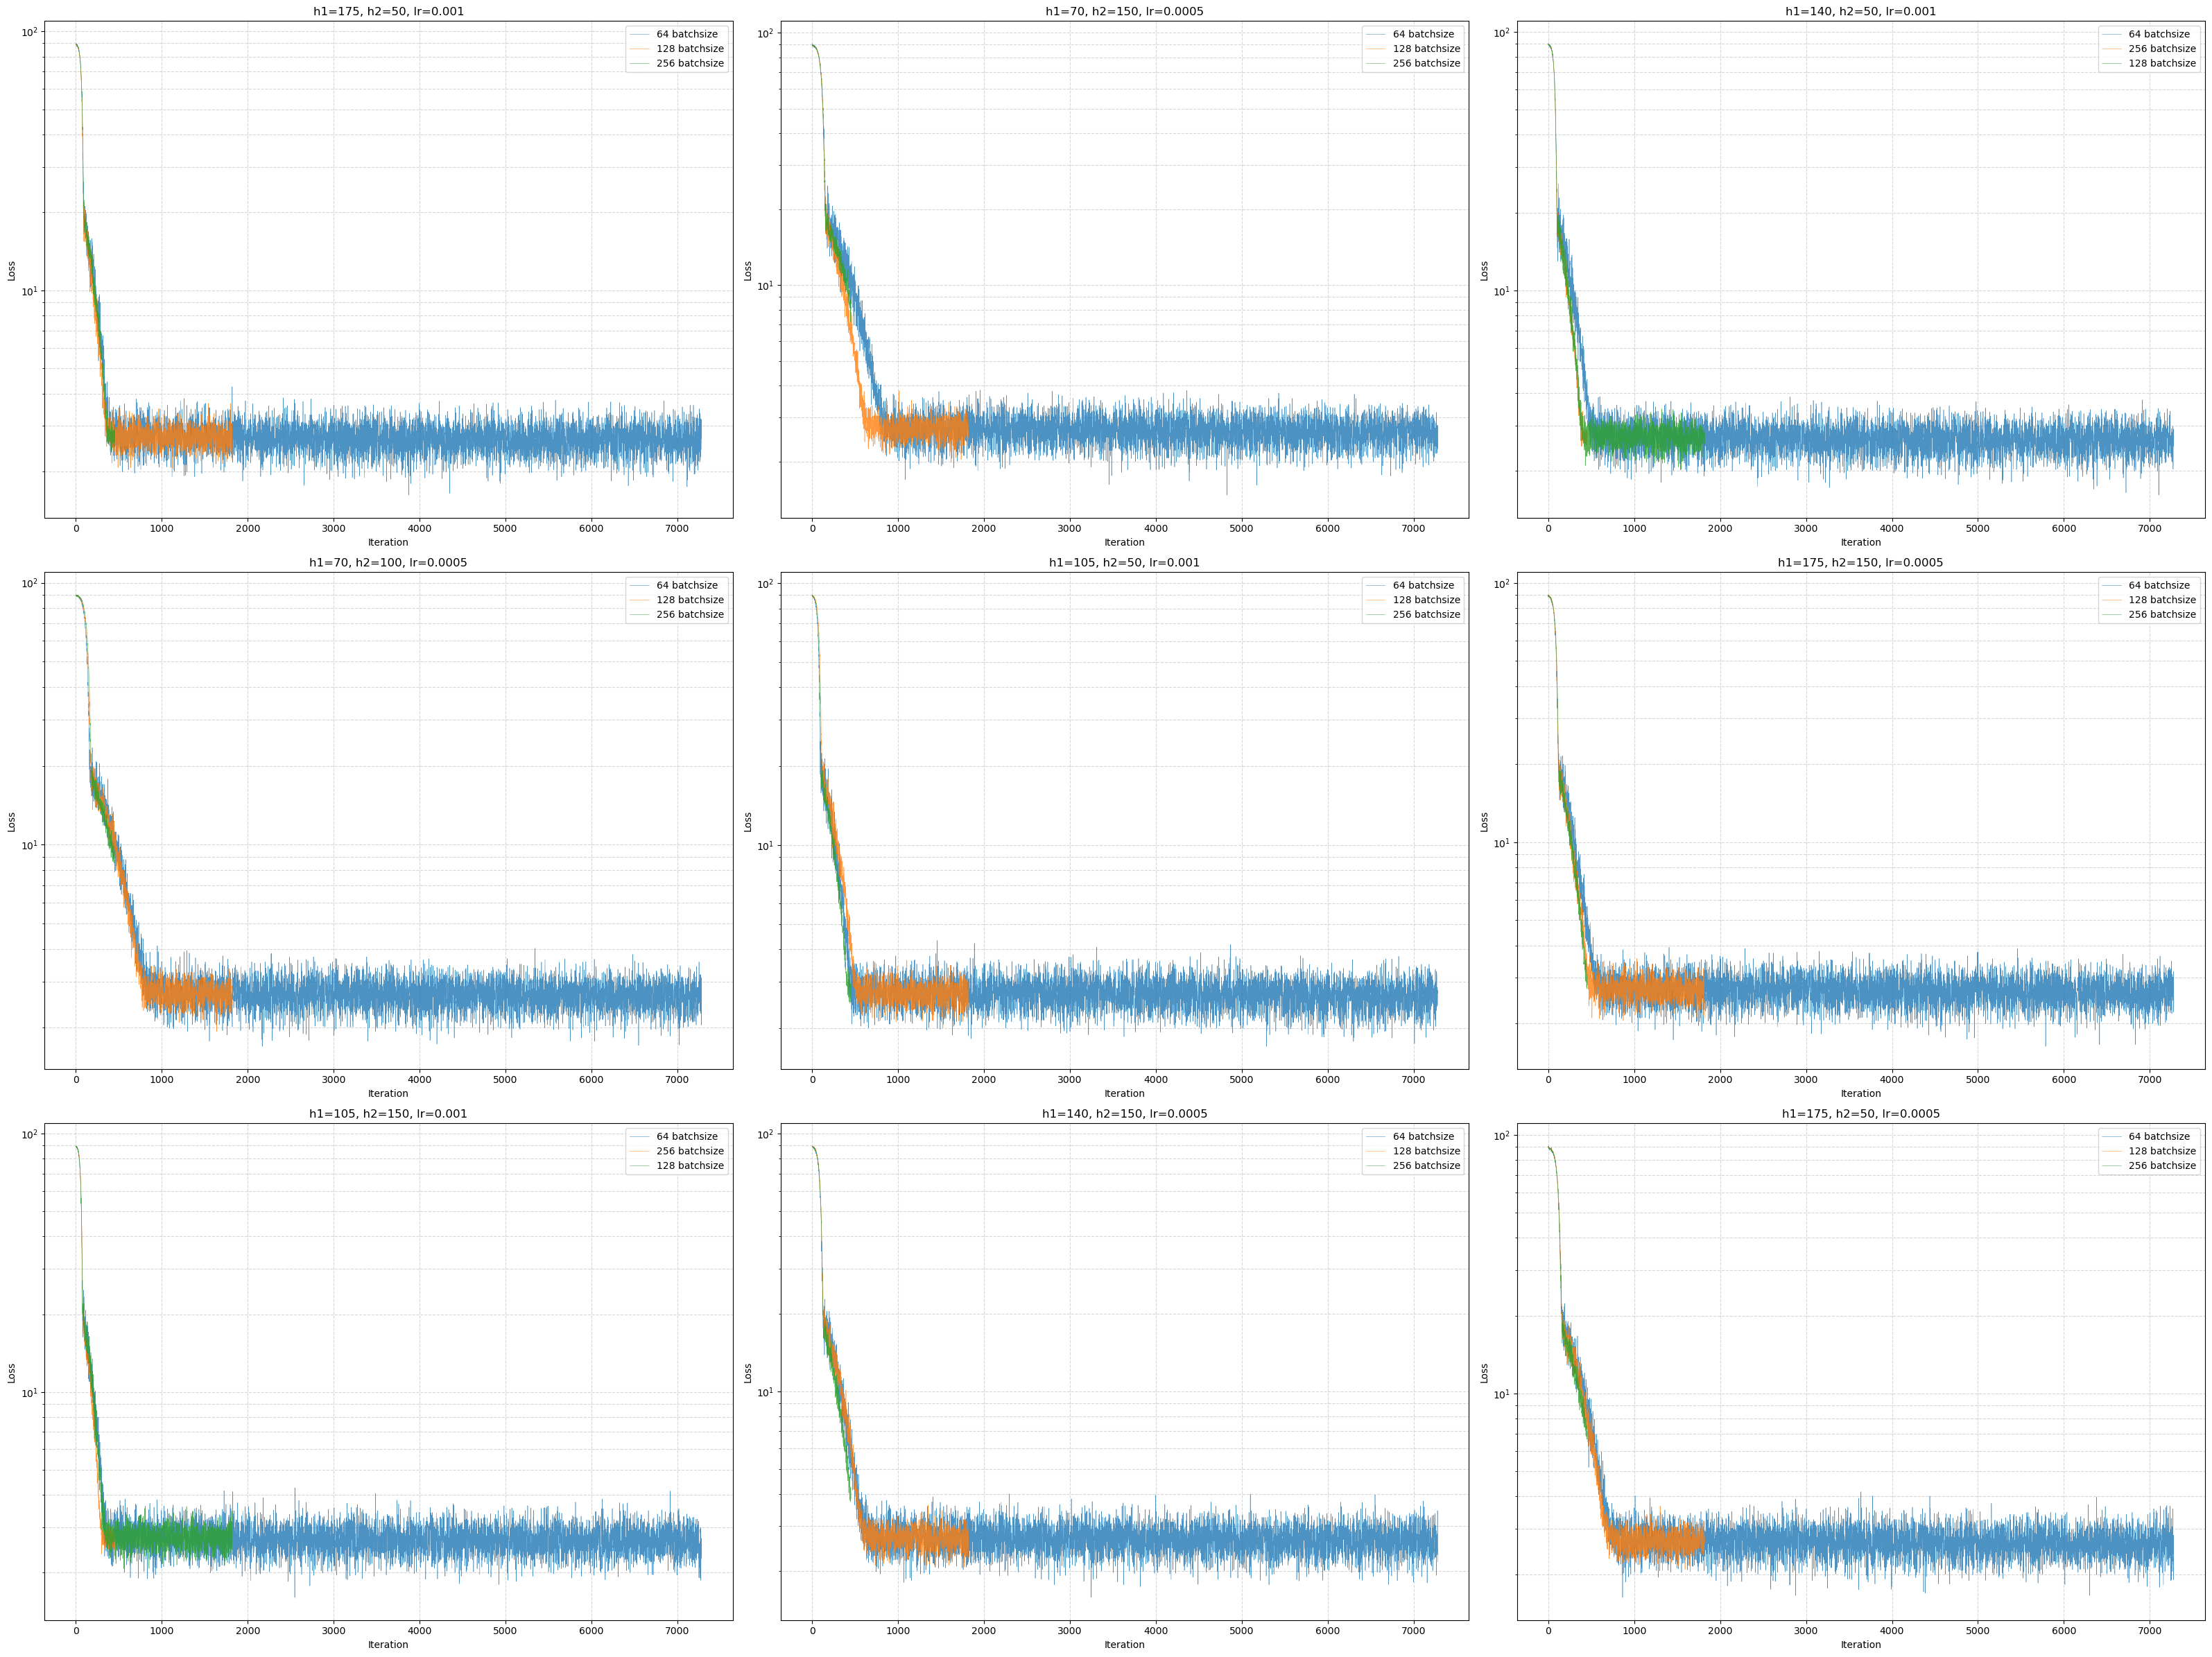

<Figure size 640x480 with 0 Axes>

In [190]:
import numpy as np

import matplotlib.pyplot as plt

# Create a figure that's large enough to see all plots
plt.figure(figsize=(32, 24))

# Group the hyperparameter combinations (excluding epochs)
grouped_params = {}
for params, (loss, loss_data) in params_and_losses:
    # Extract all parameters except epochs (which is the last one)
    key = params[:-2]  # (h1, h2, lr, bs)
    
    # If this combination hasn't been seen before, create a new entry
    if key not in grouped_params:
        grouped_params[key] = []
    
    # Add (batchsize, loss, loss_data) to this combination
    grouped_params[key].append((params[-2], loss, loss_data))

# Sort the groups by minimum loss
sorted_groups = sorted(grouped_params.items(), 
                       key=lambda x: min(item[1] for item in x[1]))

# Take the top 9 best combinations to avoid overcrowding the plot
top_n = min(9, len(sorted_groups))
best_groups = sorted_groups[:top_n]

# Create subplots for the best combinations
for i, ((h1, h2, lr), epoch_data) in enumerate(best_groups):
    plt.subplot(3, 3, i+1)
    
    for bs, loss, loss_curve in epoch_data:
        plt.semilogy(loss_curve, label=f"{bs} batchsize", linewidth=0.4, alpha=0.8)
    
    plt.title(f"h1={h1}, h2={h2}, lr={lr}")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, which="both", ls="--", alpha=0.5)

plt.tight_layout()
plt.show()
plt.savefig("hyperparameter_search.png")

Tweaking best result

In [257]:
h1, h2, lr, bs, ep = top_params[0]
train_dataloader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=bs, shuffle=False)
model_optimal = SurvivalRateModel(input_size=input_size, hidden_size1=h1, hidden_size2=h2)
loss_data_optimal = model_optimal.train_loop(train_dataloader, num_epochs=2000, learning_rate=lr, device="cpu")


Training Epochs:   0%|          | 1/2000 [00:00<24:49,  1.34it/s]

Epoch [1/2000], Loss: 1746.4677


Training Epochs:   0%|          | 2/2000 [00:01<23:54,  1.39it/s]

Epoch [2/2000], Loss: 33.1904


Training Epochs:   0%|          | 3/2000 [00:02<23:31,  1.41it/s]

Epoch [3/2000], Loss: 13.5551


Training Epochs:   0%|          | 4/2000 [00:02<23:20,  1.42it/s]

Epoch [4/2000], Loss: 13.4010


Training Epochs:   0%|          | 5/2000 [00:03<23:14,  1.43it/s]

Epoch [5/2000], Loss: 13.3987


Training Epochs:   0%|          | 6/2000 [00:04<23:09,  1.44it/s]

Epoch [6/2000], Loss: 13.4462


Training Epochs:   0%|          | 7/2000 [00:05<24:53,  1.33it/s]

Epoch [7/2000], Loss: 13.4722


Training Epochs:   0%|          | 8/2000 [00:05<24:21,  1.36it/s]

Epoch [8/2000], Loss: 13.4049


Training Epochs:   0%|          | 9/2000 [00:06<24:54,  1.33it/s]

Epoch [9/2000], Loss: 13.3569


Training Epochs:   0%|          | 10/2000 [00:07<24:18,  1.36it/s]

Epoch [10/2000], Loss: 13.3592


Training Epochs:   1%|          | 11/2000 [00:07<24:00,  1.38it/s]

Epoch [11/2000], Loss: 13.2521


Training Epochs:   1%|          | 12/2000 [00:08<23:43,  1.40it/s]

Epoch [12/2000], Loss: 13.0933


Training Epochs:   1%|          | 13/2000 [00:09<28:29,  1.16it/s]

Epoch [13/2000], Loss: 13.0942


Training Epochs:   1%|          | 14/2000 [00:10<28:21,  1.17it/s]

Epoch [14/2000], Loss: 12.9585


Training Epochs:   1%|          | 15/2000 [00:11<26:39,  1.24it/s]

Epoch [15/2000], Loss: 12.9986


Training Epochs:   1%|          | 16/2000 [00:12<25:30,  1.30it/s]

Epoch [16/2000], Loss: 12.7692


Training Epochs:   1%|          | 17/2000 [00:12<26:26,  1.25it/s]

Epoch [17/2000], Loss: 12.7963


Training Epochs:   1%|          | 18/2000 [00:14<32:12,  1.03it/s]

Epoch [18/2000], Loss: 12.6398


Training Epochs:   1%|          | 19/2000 [00:15<29:25,  1.12it/s]

Epoch [19/2000], Loss: 12.6151


Training Epochs:   1%|          | 20/2000 [00:15<27:21,  1.21it/s]

Epoch [20/2000], Loss: 12.7677


Training Epochs:   1%|          | 21/2000 [00:16<27:35,  1.20it/s]

Epoch [21/2000], Loss: 12.5819


Training Epochs:   1%|          | 22/2000 [00:17<27:29,  1.20it/s]

Epoch [22/2000], Loss: 12.5644


Training Epochs:   1%|          | 23/2000 [00:18<27:07,  1.21it/s]

Epoch [23/2000], Loss: 12.5551


Training Epochs:   1%|          | 24/2000 [00:19<30:23,  1.08it/s]

Epoch [24/2000], Loss: 12.5406


Training Epochs:   1%|▏         | 25/2000 [00:20<29:52,  1.10it/s]

Epoch [25/2000], Loss: 12.6080


Training Epochs:   1%|▏         | 26/2000 [00:20<28:30,  1.15it/s]

Epoch [26/2000], Loss: 12.7047


Training Epochs:   1%|▏         | 27/2000 [00:21<27:24,  1.20it/s]

Epoch [27/2000], Loss: 12.5117


Training Epochs:   1%|▏         | 28/2000 [00:22<28:14,  1.16it/s]

Epoch [28/2000], Loss: 12.5353


Training Epochs:   1%|▏         | 29/2000 [00:23<28:27,  1.15it/s]

Epoch [29/2000], Loss: 12.3986


Training Epochs:   2%|▏         | 30/2000 [00:24<27:27,  1.20it/s]

Epoch [30/2000], Loss: 12.3867


Training Epochs:   2%|▏         | 31/2000 [00:24<25:55,  1.27it/s]

Epoch [31/2000], Loss: 12.3840


Training Epochs:   2%|▏         | 32/2000 [00:25<24:55,  1.32it/s]

Epoch [32/2000], Loss: 12.4180


Training Epochs:   2%|▏         | 33/2000 [00:26<26:15,  1.25it/s]

Epoch [33/2000], Loss: 12.4839


Training Epochs:   2%|▏         | 34/2000 [00:27<26:57,  1.22it/s]

Epoch [34/2000], Loss: 12.5329


Training Epochs:   2%|▏         | 35/2000 [00:28<25:40,  1.28it/s]

Epoch [35/2000], Loss: 12.4605


Training Epochs:   2%|▏         | 36/2000 [00:28<24:31,  1.33it/s]

Epoch [36/2000], Loss: 12.4761


Training Epochs:   2%|▏         | 37/2000 [00:29<24:06,  1.36it/s]

Epoch [37/2000], Loss: 12.4330


Training Epochs:   2%|▏         | 38/2000 [00:30<24:07,  1.36it/s]

Epoch [38/2000], Loss: 12.5345


Training Epochs:   2%|▏         | 39/2000 [00:31<24:08,  1.35it/s]

Epoch [39/2000], Loss: 12.4295


Training Epochs:   2%|▏         | 40/2000 [00:31<24:41,  1.32it/s]

Epoch [40/2000], Loss: 12.3903


Training Epochs:   2%|▏         | 41/2000 [00:32<24:58,  1.31it/s]

Epoch [41/2000], Loss: 12.4455


Training Epochs:   2%|▏         | 42/2000 [00:33<24:22,  1.34it/s]

Epoch [42/2000], Loss: 12.5416


Training Epochs:   2%|▏         | 43/2000 [00:33<23:42,  1.38it/s]

Epoch [43/2000], Loss: 12.3633


Training Epochs:   2%|▏         | 44/2000 [00:34<23:23,  1.39it/s]

Epoch [44/2000], Loss: 12.4008


Training Epochs:   2%|▏         | 45/2000 [00:35<23:52,  1.36it/s]

Epoch [45/2000], Loss: 12.3244


Training Epochs:   2%|▏         | 46/2000 [00:36<24:38,  1.32it/s]

Epoch [46/2000], Loss: 12.4116


Training Epochs:   2%|▏         | 47/2000 [00:36<23:56,  1.36it/s]

Epoch [47/2000], Loss: 12.2955


Training Epochs:   2%|▏         | 48/2000 [00:37<23:32,  1.38it/s]

Epoch [48/2000], Loss: 12.4559


Training Epochs:   2%|▏         | 49/2000 [00:38<23:20,  1.39it/s]

Epoch [49/2000], Loss: 12.4591


Training Epochs:   2%|▎         | 50/2000 [00:39<23:06,  1.41it/s]

Epoch [50/2000], Loss: 12.4569


Training Epochs:   3%|▎         | 51/2000 [00:39<22:57,  1.41it/s]

Epoch [51/2000], Loss: 12.4136


Training Epochs:   3%|▎         | 52/2000 [00:40<22:44,  1.43it/s]

Epoch [52/2000], Loss: 12.3098


Training Epochs:   3%|▎         | 53/2000 [00:41<23:19,  1.39it/s]

Epoch [53/2000], Loss: 12.2894


Training Epochs:   3%|▎         | 54/2000 [00:41<23:03,  1.41it/s]

Epoch [54/2000], Loss: 12.4095


Training Epochs:   3%|▎         | 55/2000 [00:42<22:47,  1.42it/s]

Epoch [55/2000], Loss: 12.3884


Training Epochs:   3%|▎         | 56/2000 [00:43<22:36,  1.43it/s]

Epoch [56/2000], Loss: 12.2746


Training Epochs:   3%|▎         | 57/2000 [00:43<22:37,  1.43it/s]

Epoch [57/2000], Loss: 12.3384


Training Epochs:   3%|▎         | 58/2000 [00:44<24:52,  1.30it/s]

Epoch [58/2000], Loss: 12.3793


Training Epochs:   3%|▎         | 59/2000 [00:45<24:42,  1.31it/s]

Epoch [59/2000], Loss: 12.3312


Training Epochs:   3%|▎         | 60/2000 [00:46<24:22,  1.33it/s]

Epoch [60/2000], Loss: 12.3133


Training Epochs:   3%|▎         | 61/2000 [00:47<23:47,  1.36it/s]

Epoch [61/2000], Loss: 12.2919


Training Epochs:   3%|▎         | 62/2000 [00:47<23:20,  1.38it/s]

Epoch [62/2000], Loss: 12.4502


Training Epochs:   3%|▎         | 63/2000 [00:48<22:53,  1.41it/s]

Epoch [63/2000], Loss: 12.4055


Training Epochs:   3%|▎         | 64/2000 [00:49<22:42,  1.42it/s]

Epoch [64/2000], Loss: 12.3554


Training Epochs:   3%|▎         | 65/2000 [00:49<22:26,  1.44it/s]

Epoch [65/2000], Loss: 12.3672


Training Epochs:   3%|▎         | 66/2000 [00:50<22:59,  1.40it/s]

Epoch [66/2000], Loss: 12.2986


Training Epochs:   3%|▎         | 67/2000 [00:51<23:00,  1.40it/s]

Epoch [67/2000], Loss: 12.3898


Training Epochs:   3%|▎         | 68/2000 [00:51<22:44,  1.42it/s]

Epoch [68/2000], Loss: 12.2797


Training Epochs:   3%|▎         | 69/2000 [00:52<22:29,  1.43it/s]

Epoch [69/2000], Loss: 12.2791


Training Epochs:   4%|▎         | 70/2000 [00:53<23:37,  1.36it/s]

Epoch [70/2000], Loss: 12.3652


Training Epochs:   4%|▎         | 71/2000 [00:54<23:07,  1.39it/s]

Epoch [71/2000], Loss: 12.2346


Training Epochs:   4%|▎         | 72/2000 [00:54<23:27,  1.37it/s]

Epoch [72/2000], Loss: 12.3010


Training Epochs:   4%|▎         | 73/2000 [00:55<24:06,  1.33it/s]

Epoch [73/2000], Loss: 12.4071


Training Epochs:   4%|▎         | 74/2000 [00:56<23:42,  1.35it/s]

Epoch [74/2000], Loss: 12.2994


Training Epochs:   4%|▍         | 75/2000 [00:57<23:38,  1.36it/s]

Epoch [75/2000], Loss: 12.3254


Training Epochs:   4%|▍         | 76/2000 [00:57<23:17,  1.38it/s]

Epoch [76/2000], Loss: 12.2792


Training Epochs:   4%|▍         | 77/2000 [00:58<23:20,  1.37it/s]

Epoch [77/2000], Loss: 12.2481


Training Epochs:   4%|▍         | 78/2000 [00:59<23:14,  1.38it/s]

Epoch [78/2000], Loss: 12.2788


Training Epochs:   4%|▍         | 79/2000 [00:59<22:51,  1.40it/s]

Epoch [79/2000], Loss: 12.3017


Training Epochs:   4%|▍         | 80/2000 [01:00<22:33,  1.42it/s]

Epoch [80/2000], Loss: 12.2158


Training Epochs:   4%|▍         | 81/2000 [01:01<22:21,  1.43it/s]

Epoch [81/2000], Loss: 12.2477


Training Epochs:   4%|▍         | 82/2000 [01:02<24:13,  1.32it/s]

Epoch [82/2000], Loss: 12.2965


Training Epochs:   4%|▍         | 83/2000 [01:02<23:33,  1.36it/s]

Epoch [83/2000], Loss: 12.1415


Training Epochs:   4%|▍         | 84/2000 [01:03<23:05,  1.38it/s]

Epoch [84/2000], Loss: 12.2099


Training Epochs:   4%|▍         | 85/2000 [01:04<23:01,  1.39it/s]

Epoch [85/2000], Loss: 12.1150


Training Epochs:   4%|▍         | 86/2000 [01:05<22:45,  1.40it/s]

Epoch [86/2000], Loss: 12.1150


Training Epochs:   4%|▍         | 87/2000 [01:05<22:27,  1.42it/s]

Epoch [87/2000], Loss: 12.1407


Training Epochs:   4%|▍         | 88/2000 [01:06<24:37,  1.29it/s]

Epoch [88/2000], Loss: 12.0106


Training Epochs:   4%|▍         | 89/2000 [01:07<24:23,  1.31it/s]

Epoch [89/2000], Loss: 12.0927


Training Epochs:   4%|▍         | 90/2000 [01:08<24:43,  1.29it/s]

Epoch [90/2000], Loss: 12.2045


Training Epochs:   5%|▍         | 91/2000 [01:08<23:50,  1.33it/s]

Epoch [91/2000], Loss: 12.0061


Training Epochs:   5%|▍         | 92/2000 [01:09<23:14,  1.37it/s]

Epoch [92/2000], Loss: 12.0232


Training Epochs:   5%|▍         | 93/2000 [01:10<22:50,  1.39it/s]

Epoch [93/2000], Loss: 11.9410


Training Epochs:   5%|▍         | 94/2000 [01:10<23:05,  1.38it/s]

Epoch [94/2000], Loss: 12.0232


Training Epochs:   5%|▍         | 95/2000 [01:11<24:34,  1.29it/s]

Epoch [95/2000], Loss: 11.9740


Training Epochs:   5%|▍         | 96/2000 [01:12<24:21,  1.30it/s]

Epoch [96/2000], Loss: 11.9619


Training Epochs:   5%|▍         | 97/2000 [01:13<25:25,  1.25it/s]

Epoch [97/2000], Loss: 11.8509


Training Epochs:   5%|▍         | 98/2000 [01:14<24:49,  1.28it/s]

Epoch [98/2000], Loss: 11.8792


Training Epochs:   5%|▍         | 99/2000 [01:14<23:51,  1.33it/s]

Epoch [99/2000], Loss: 11.9326


Training Epochs:   5%|▌         | 100/2000 [01:15<23:14,  1.36it/s]

Epoch [100/2000], Loss: 11.9232


Training Epochs:   5%|▌         | 101/2000 [01:16<24:15,  1.30it/s]

Epoch [101/2000], Loss: 11.7875


Training Epochs:   5%|▌         | 102/2000 [01:17<23:57,  1.32it/s]

Epoch [102/2000], Loss: 11.8674


Training Epochs:   5%|▌         | 103/2000 [01:17<23:29,  1.35it/s]

Epoch [103/2000], Loss: 11.8206


Training Epochs:   5%|▌         | 104/2000 [01:18<22:58,  1.38it/s]

Epoch [104/2000], Loss: 11.8218


Training Epochs:   5%|▌         | 105/2000 [01:19<22:39,  1.39it/s]

Epoch [105/2000], Loss: 11.7505


Training Epochs:   5%|▌         | 106/2000 [01:20<24:15,  1.30it/s]

Epoch [106/2000], Loss: 11.8844


Training Epochs:   5%|▌         | 107/2000 [01:20<23:26,  1.35it/s]

Epoch [107/2000], Loss: 11.7216


Training Epochs:   5%|▌         | 108/2000 [01:21<23:11,  1.36it/s]

Epoch [108/2000], Loss: 11.6888


Training Epochs:   5%|▌         | 109/2000 [01:22<22:36,  1.39it/s]

Epoch [109/2000], Loss: 11.6409


Training Epochs:   6%|▌         | 110/2000 [01:22<22:18,  1.41it/s]

Epoch [110/2000], Loss: 11.7635


Training Epochs:   6%|▌         | 111/2000 [01:23<22:12,  1.42it/s]

Epoch [111/2000], Loss: 11.7594


Training Epochs:   6%|▌         | 112/2000 [01:24<22:02,  1.43it/s]

Epoch [112/2000], Loss: 11.7205


Training Epochs:   6%|▌         | 113/2000 [01:25<21:54,  1.44it/s]

Epoch [113/2000], Loss: 11.5914


Training Epochs:   6%|▌         | 114/2000 [01:25<21:47,  1.44it/s]

Epoch [114/2000], Loss: 11.6185


Training Epochs:   6%|▌         | 115/2000 [01:26<21:47,  1.44it/s]

Epoch [115/2000], Loss: 11.6442


Training Epochs:   6%|▌         | 116/2000 [01:27<24:02,  1.31it/s]

Epoch [116/2000], Loss: 11.5899


Training Epochs:   6%|▌         | 117/2000 [01:28<23:50,  1.32it/s]

Epoch [117/2000], Loss: 11.6253


Training Epochs:   6%|▌         | 118/2000 [01:29<25:19,  1.24it/s]

Epoch [118/2000], Loss: 11.6406


Training Epochs:   6%|▌         | 119/2000 [01:29<24:10,  1.30it/s]

Epoch [119/2000], Loss: 11.5799


Training Epochs:   6%|▌         | 120/2000 [01:30<23:52,  1.31it/s]

Epoch [120/2000], Loss: 11.6329


Training Epochs:   6%|▌         | 121/2000 [01:31<23:10,  1.35it/s]

Epoch [121/2000], Loss: 11.5755


Training Epochs:   6%|▌         | 122/2000 [01:31<22:41,  1.38it/s]

Epoch [122/2000], Loss: 11.5241


Training Epochs:   6%|▌         | 123/2000 [01:32<22:22,  1.40it/s]

Epoch [123/2000], Loss: 11.6369


Training Epochs:   6%|▌         | 124/2000 [01:33<22:07,  1.41it/s]

Epoch [124/2000], Loss: 11.5187


Training Epochs:   6%|▋         | 125/2000 [01:33<22:01,  1.42it/s]

Epoch [125/2000], Loss: 11.4857


Training Epochs:   6%|▋         | 126/2000 [01:34<21:56,  1.42it/s]

Epoch [126/2000], Loss: 11.5177


Training Epochs:   6%|▋         | 127/2000 [01:35<21:51,  1.43it/s]

Epoch [127/2000], Loss: 11.5177


Training Epochs:   6%|▋         | 128/2000 [01:35<21:58,  1.42it/s]

Epoch [128/2000], Loss: 11.4374


Training Epochs:   6%|▋         | 129/2000 [01:36<23:02,  1.35it/s]

Epoch [129/2000], Loss: 11.4450


Training Epochs:   6%|▋         | 130/2000 [01:37<22:39,  1.38it/s]

Epoch [130/2000], Loss: 11.4764


Training Epochs:   7%|▋         | 131/2000 [01:38<22:23,  1.39it/s]

Epoch [131/2000], Loss: 11.4305


Training Epochs:   7%|▋         | 132/2000 [01:38<22:13,  1.40it/s]

Epoch [132/2000], Loss: 11.4144


Training Epochs:   7%|▋         | 133/2000 [01:39<22:00,  1.41it/s]

Epoch [133/2000], Loss: 11.3421


Training Epochs:   7%|▋         | 134/2000 [01:40<21:55,  1.42it/s]

Epoch [134/2000], Loss: 11.3773


Training Epochs:   7%|▋         | 135/2000 [01:40<21:48,  1.43it/s]

Epoch [135/2000], Loss: 11.4187


Training Epochs:   7%|▋         | 136/2000 [01:41<21:50,  1.42it/s]

Epoch [136/2000], Loss: 11.3018


Training Epochs:   7%|▋         | 137/2000 [01:42<21:46,  1.43it/s]

Epoch [137/2000], Loss: 11.3346


Training Epochs:   7%|▋         | 138/2000 [01:43<21:43,  1.43it/s]

Epoch [138/2000], Loss: 11.2586


Training Epochs:   7%|▋         | 139/2000 [01:43<21:41,  1.43it/s]

Epoch [139/2000], Loss: 11.4435


Training Epochs:   7%|▋         | 140/2000 [01:44<21:43,  1.43it/s]

Epoch [140/2000], Loss: 11.3180


Training Epochs:   7%|▋         | 141/2000 [01:45<22:28,  1.38it/s]

Epoch [141/2000], Loss: 11.2044


Training Epochs:   7%|▋         | 142/2000 [01:45<22:18,  1.39it/s]

Epoch [142/2000], Loss: 11.2697


Training Epochs:   7%|▋         | 143/2000 [01:46<22:03,  1.40it/s]

Epoch [143/2000], Loss: 11.2724


Training Epochs:   7%|▋         | 144/2000 [01:47<21:53,  1.41it/s]

Epoch [144/2000], Loss: 11.3142


Training Epochs:   7%|▋         | 145/2000 [01:48<21:54,  1.41it/s]

Epoch [145/2000], Loss: 11.1820


Training Epochs:   7%|▋         | 146/2000 [01:48<21:48,  1.42it/s]

Epoch [146/2000], Loss: 11.2511


Training Epochs:   7%|▋         | 147/2000 [01:49<21:41,  1.42it/s]

Epoch [147/2000], Loss: 11.2558


Training Epochs:   7%|▋         | 148/2000 [01:50<21:36,  1.43it/s]

Epoch [148/2000], Loss: 11.1691


Training Epochs:   7%|▋         | 149/2000 [01:50<21:35,  1.43it/s]

Epoch [149/2000], Loss: 11.1739


Training Epochs:   8%|▊         | 150/2000 [01:51<21:34,  1.43it/s]

Epoch [150/2000], Loss: 11.0701


Training Epochs:   8%|▊         | 151/2000 [01:52<21:38,  1.42it/s]

Epoch [151/2000], Loss: 11.0766


Training Epochs:   8%|▊         | 152/2000 [01:53<22:29,  1.37it/s]

Epoch [152/2000], Loss: 11.1161


Training Epochs:   8%|▊         | 153/2000 [01:53<22:19,  1.38it/s]

Epoch [153/2000], Loss: 11.0971


Training Epochs:   8%|▊         | 154/2000 [01:54<22:00,  1.40it/s]

Epoch [154/2000], Loss: 11.1258


Training Epochs:   8%|▊         | 155/2000 [01:55<21:45,  1.41it/s]

Epoch [155/2000], Loss: 11.0696


Training Epochs:   8%|▊         | 156/2000 [01:55<22:23,  1.37it/s]

Epoch [156/2000], Loss: 11.0036


Training Epochs:   8%|▊         | 157/2000 [01:56<22:30,  1.36it/s]

Epoch [157/2000], Loss: 11.0421


Training Epochs:   8%|▊         | 158/2000 [01:57<22:09,  1.39it/s]

Epoch [158/2000], Loss: 11.0915


Training Epochs:   8%|▊         | 159/2000 [01:58<22:21,  1.37it/s]

Epoch [159/2000], Loss: 10.9624


Training Epochs:   8%|▊         | 160/2000 [01:58<22:20,  1.37it/s]

Epoch [160/2000], Loss: 11.0754


Training Epochs:   8%|▊         | 161/2000 [01:59<22:27,  1.36it/s]

Epoch [161/2000], Loss: 10.9047


Training Epochs:   8%|▊         | 162/2000 [02:00<21:59,  1.39it/s]

Epoch [162/2000], Loss: 11.1124


Training Epochs:   8%|▊         | 163/2000 [02:00<21:43,  1.41it/s]

Epoch [163/2000], Loss: 10.9752


Training Epochs:   8%|▊         | 164/2000 [02:01<22:49,  1.34it/s]

Epoch [164/2000], Loss: 10.9656


Training Epochs:   8%|▊         | 165/2000 [02:02<22:24,  1.36it/s]

Epoch [165/2000], Loss: 10.9030


Training Epochs:   8%|▊         | 166/2000 [02:03<22:05,  1.38it/s]

Epoch [166/2000], Loss: 10.9073


Training Epochs:   8%|▊         | 167/2000 [02:03<21:53,  1.40it/s]

Epoch [167/2000], Loss: 10.8689


Training Epochs:   8%|▊         | 168/2000 [02:04<21:41,  1.41it/s]

Epoch [168/2000], Loss: 10.9052


Training Epochs:   8%|▊         | 169/2000 [02:05<21:36,  1.41it/s]

Epoch [169/2000], Loss: 10.9120


Training Epochs:   8%|▊         | 170/2000 [02:06<21:30,  1.42it/s]

Epoch [170/2000], Loss: 10.9063


Training Epochs:   9%|▊         | 171/2000 [02:06<21:29,  1.42it/s]

Epoch [171/2000], Loss: 10.8068


Training Epochs:   9%|▊         | 172/2000 [02:07<21:24,  1.42it/s]

Epoch [172/2000], Loss: 10.9055


Training Epochs:   9%|▊         | 173/2000 [02:08<21:18,  1.43it/s]

Epoch [173/2000], Loss: 10.8823


Training Epochs:   9%|▊         | 174/2000 [02:08<21:16,  1.43it/s]

Epoch [174/2000], Loss: 10.8774


Training Epochs:   9%|▉         | 175/2000 [02:09<22:50,  1.33it/s]

Epoch [175/2000], Loss: 10.8326


Training Epochs:   9%|▉         | 176/2000 [02:10<22:36,  1.34it/s]

Epoch [176/2000], Loss: 10.8419


Training Epochs:   9%|▉         | 177/2000 [02:11<22:13,  1.37it/s]

Epoch [177/2000], Loss: 10.7828


Training Epochs:   9%|▉         | 178/2000 [02:11<21:54,  1.39it/s]

Epoch [178/2000], Loss: 10.7791


Training Epochs:   9%|▉         | 179/2000 [02:12<21:43,  1.40it/s]

Epoch [179/2000], Loss: 10.8015


Training Epochs:   9%|▉         | 180/2000 [02:13<23:01,  1.32it/s]

Epoch [180/2000], Loss: 10.7666


Training Epochs:   9%|▉         | 181/2000 [02:14<22:33,  1.34it/s]

Epoch [181/2000], Loss: 10.7184


Training Epochs:   9%|▉         | 182/2000 [02:14<22:08,  1.37it/s]

Epoch [182/2000], Loss: 10.7703


Training Epochs:   9%|▉         | 183/2000 [02:15<21:54,  1.38it/s]

Epoch [183/2000], Loss: 10.7615


Training Epochs:   9%|▉         | 184/2000 [02:16<21:40,  1.40it/s]

Epoch [184/2000], Loss: 10.7637


Training Epochs:   9%|▉         | 185/2000 [02:16<21:30,  1.41it/s]

Epoch [185/2000], Loss: 10.6729


Training Epochs:   9%|▉         | 186/2000 [02:17<22:02,  1.37it/s]

Epoch [186/2000], Loss: 10.6315


Training Epochs:   9%|▉         | 187/2000 [02:18<23:20,  1.29it/s]

Epoch [187/2000], Loss: 10.7332


Training Epochs:   9%|▉         | 188/2000 [02:19<22:34,  1.34it/s]

Epoch [188/2000], Loss: 10.7216


Training Epochs:   9%|▉         | 189/2000 [02:19<22:01,  1.37it/s]

Epoch [189/2000], Loss: 10.6951


Training Epochs:  10%|▉         | 190/2000 [02:20<21:45,  1.39it/s]

Epoch [190/2000], Loss: 10.6940


Training Epochs:  10%|▉         | 191/2000 [02:21<22:02,  1.37it/s]

Epoch [191/2000], Loss: 10.6613


Training Epochs:  10%|▉         | 192/2000 [02:22<21:35,  1.40it/s]

Epoch [192/2000], Loss: 10.7899


Training Epochs:  10%|▉         | 193/2000 [02:22<21:21,  1.41it/s]

Epoch [193/2000], Loss: 10.5995


Training Epochs:  10%|▉         | 194/2000 [02:23<21:17,  1.41it/s]

Epoch [194/2000], Loss: 10.6321


Training Epochs:  10%|▉         | 195/2000 [02:24<21:11,  1.42it/s]

Epoch [195/2000], Loss: 10.7005


Training Epochs:  10%|▉         | 196/2000 [02:24<21:09,  1.42it/s]

Epoch [196/2000], Loss: 10.6169


Training Epochs:  10%|▉         | 197/2000 [02:25<21:05,  1.42it/s]

Epoch [197/2000], Loss: 10.6576


Training Epochs:  10%|▉         | 198/2000 [02:26<22:11,  1.35it/s]

Epoch [198/2000], Loss: 10.5139


Training Epochs:  10%|▉         | 199/2000 [02:27<22:15,  1.35it/s]

Epoch [199/2000], Loss: 10.6148


Training Epochs:  10%|█         | 200/2000 [02:27<23:32,  1.27it/s]

Epoch [200/2000], Loss: 10.5524


Training Epochs:  10%|█         | 201/2000 [02:28<22:43,  1.32it/s]

Epoch [201/2000], Loss: 10.5933


Training Epochs:  10%|█         | 202/2000 [02:29<22:17,  1.34it/s]

Epoch [202/2000], Loss: 10.5693


Training Epochs:  10%|█         | 203/2000 [02:30<21:46,  1.38it/s]

Epoch [203/2000], Loss: 10.6283


Training Epochs:  10%|█         | 204/2000 [02:30<21:25,  1.40it/s]

Epoch [204/2000], Loss: 10.5170


Training Epochs:  10%|█         | 205/2000 [02:31<21:11,  1.41it/s]

Epoch [205/2000], Loss: 10.6120


Training Epochs:  10%|█         | 206/2000 [02:32<20:59,  1.42it/s]

Epoch [206/2000], Loss: 10.5938


Training Epochs:  10%|█         | 207/2000 [02:32<20:53,  1.43it/s]

Epoch [207/2000], Loss: 10.5343


Training Epochs:  10%|█         | 208/2000 [02:33<20:53,  1.43it/s]

Epoch [208/2000], Loss: 10.5054


Training Epochs:  10%|█         | 209/2000 [02:34<20:47,  1.44it/s]

Epoch [209/2000], Loss: 10.5162


Training Epochs:  10%|█         | 210/2000 [02:34<20:39,  1.44it/s]

Epoch [210/2000], Loss: 10.5027


Training Epochs:  11%|█         | 211/2000 [02:35<22:29,  1.33it/s]

Epoch [211/2000], Loss: 10.4201


Training Epochs:  11%|█         | 212/2000 [02:36<23:12,  1.28it/s]

Epoch [212/2000], Loss: 10.5248


Training Epochs:  11%|█         | 213/2000 [02:37<22:46,  1.31it/s]

Epoch [213/2000], Loss: 10.4621


Training Epochs:  11%|█         | 214/2000 [02:38<22:12,  1.34it/s]

Epoch [214/2000], Loss: 10.3988


Training Epochs:  11%|█         | 215/2000 [02:38<21:51,  1.36it/s]

Epoch [215/2000], Loss: 10.5864


Training Epochs:  11%|█         | 216/2000 [02:39<22:21,  1.33it/s]

Epoch [216/2000], Loss: 10.5340


Training Epochs:  11%|█         | 217/2000 [02:40<21:52,  1.36it/s]

Epoch [217/2000], Loss: 10.5069


Training Epochs:  11%|█         | 218/2000 [02:40<21:27,  1.38it/s]

Epoch [218/2000], Loss: 10.4493


Training Epochs:  11%|█         | 219/2000 [02:41<21:09,  1.40it/s]

Epoch [219/2000], Loss: 10.4445


Training Epochs:  11%|█         | 220/2000 [02:42<22:13,  1.34it/s]

Epoch [220/2000], Loss: 10.4708


Training Epochs:  11%|█         | 221/2000 [02:43<21:43,  1.36it/s]

Epoch [221/2000], Loss: 10.4615


Training Epochs:  11%|█         | 222/2000 [02:43<21:29,  1.38it/s]

Epoch [222/2000], Loss: 10.4504


Training Epochs:  11%|█         | 223/2000 [02:44<21:17,  1.39it/s]

Epoch [223/2000], Loss: 10.4511


Training Epochs:  11%|█         | 224/2000 [02:45<21:04,  1.40it/s]

Epoch [224/2000], Loss: 10.4485


Training Epochs:  11%|█▏        | 225/2000 [02:46<21:02,  1.41it/s]

Epoch [225/2000], Loss: 10.5006


Training Epochs:  11%|█▏        | 226/2000 [02:46<21:44,  1.36it/s]

Epoch [226/2000], Loss: 10.4549


Training Epochs:  11%|█▏        | 227/2000 [02:47<21:38,  1.37it/s]

Epoch [227/2000], Loss: 10.3619


Training Epochs:  11%|█▏        | 228/2000 [02:48<21:48,  1.35it/s]

Epoch [228/2000], Loss: 10.3659


Training Epochs:  11%|█▏        | 229/2000 [02:49<22:06,  1.33it/s]

Epoch [229/2000], Loss: 10.4247


Training Epochs:  12%|█▏        | 230/2000 [02:49<22:51,  1.29it/s]

Epoch [230/2000], Loss: 10.5163


Training Epochs:  12%|█▏        | 231/2000 [02:50<24:07,  1.22it/s]

Epoch [231/2000], Loss: 10.4169


Training Epochs:  12%|█▏        | 232/2000 [02:51<25:17,  1.17it/s]

Epoch [232/2000], Loss: 10.4394


Training Epochs:  12%|█▏        | 233/2000 [02:52<27:14,  1.08it/s]

Epoch [233/2000], Loss: 10.4328


Training Epochs:  12%|█▏        | 234/2000 [02:53<25:34,  1.15it/s]

Epoch [234/2000], Loss: 10.3827


Training Epochs:  12%|█▏        | 235/2000 [02:54<24:14,  1.21it/s]

Epoch [235/2000], Loss: 10.3919


Training Epochs:  12%|█▏        | 236/2000 [02:55<23:07,  1.27it/s]

Epoch [236/2000], Loss: 10.3594


Training Epochs:  12%|█▏        | 237/2000 [02:55<22:26,  1.31it/s]

Epoch [237/2000], Loss: 10.4313


Training Epochs:  12%|█▏        | 238/2000 [02:58<43:48,  1.49s/it]

Epoch [238/2000], Loss: 10.4160


Training Epochs:  12%|█▏        | 239/2000 [02:59<38:13,  1.30s/it]

Epoch [239/2000], Loss: 10.3284


Training Epochs:  12%|█▏        | 240/2000 [03:00<33:32,  1.14s/it]

Epoch [240/2000], Loss: 10.3494


Training Epochs:  12%|█▏        | 241/2000 [03:01<30:33,  1.04s/it]

Epoch [241/2000], Loss: 10.3851


Training Epochs:  12%|█▏        | 242/2000 [03:02<27:54,  1.05it/s]

Epoch [242/2000], Loss: 10.3144


Training Epochs:  12%|█▏        | 243/2000 [03:02<25:48,  1.13it/s]

Epoch [243/2000], Loss: 10.3499


Training Epochs:  12%|█▏        | 244/2000 [03:03<24:16,  1.21it/s]

Epoch [244/2000], Loss: 10.3291


Training Epochs:  12%|█▏        | 245/2000 [03:04<23:10,  1.26it/s]

Epoch [245/2000], Loss: 10.4640


Training Epochs:  12%|█▏        | 246/2000 [03:05<23:39,  1.24it/s]

Epoch [246/2000], Loss: 10.3001


Training Epochs:  12%|█▏        | 247/2000 [03:05<22:47,  1.28it/s]

Epoch [247/2000], Loss: 10.2809


Training Epochs:  12%|█▏        | 248/2000 [03:06<22:12,  1.31it/s]

Epoch [248/2000], Loss: 10.2795


Training Epochs:  12%|█▏        | 249/2000 [03:07<21:52,  1.33it/s]

Epoch [249/2000], Loss: 10.2684


Training Epochs:  12%|█▎        | 250/2000 [03:07<21:40,  1.35it/s]

Epoch [250/2000], Loss: 10.3099


Training Epochs:  13%|█▎        | 251/2000 [03:08<21:27,  1.36it/s]

Epoch [251/2000], Loss: 10.3090


Training Epochs:  13%|█▎        | 252/2000 [03:09<21:03,  1.38it/s]

Epoch [252/2000], Loss: 10.3013


Training Epochs:  13%|█▎        | 253/2000 [03:10<20:48,  1.40it/s]

Epoch [253/2000], Loss: 10.3378


Training Epochs:  13%|█▎        | 254/2000 [03:10<21:10,  1.37it/s]

Epoch [254/2000], Loss: 10.2779


Training Epochs:  13%|█▎        | 255/2000 [03:11<21:16,  1.37it/s]

Epoch [255/2000], Loss: 10.2560


Training Epochs:  13%|█▎        | 256/2000 [03:12<22:49,  1.27it/s]

Epoch [256/2000], Loss: 10.3076


Training Epochs:  13%|█▎        | 257/2000 [03:13<24:14,  1.20it/s]

Epoch [257/2000], Loss: 10.3097


Training Epochs:  13%|█▎        | 258/2000 [03:14<23:05,  1.26it/s]

Epoch [258/2000], Loss: 10.2577


Training Epochs:  13%|█▎        | 259/2000 [03:14<22:13,  1.31it/s]

Epoch [259/2000], Loss: 10.3106


Training Epochs:  13%|█▎        | 260/2000 [03:15<21:31,  1.35it/s]

Epoch [260/2000], Loss: 10.2882


Training Epochs:  13%|█▎        | 261/2000 [03:16<21:03,  1.38it/s]

Epoch [261/2000], Loss: 10.2134


Training Epochs:  13%|█▎        | 262/2000 [03:16<20:44,  1.40it/s]

Epoch [262/2000], Loss: 10.1810


Training Epochs:  13%|█▎        | 263/2000 [03:17<21:42,  1.33it/s]

Epoch [263/2000], Loss: 10.3242


Training Epochs:  13%|█▎        | 264/2000 [03:18<21:12,  1.36it/s]

Epoch [264/2000], Loss: 10.2057


Training Epochs:  13%|█▎        | 265/2000 [03:19<20:50,  1.39it/s]

Epoch [265/2000], Loss: 10.2542


Training Epochs:  13%|█▎        | 266/2000 [03:19<20:36,  1.40it/s]

Epoch [266/2000], Loss: 10.2113


Training Epochs:  13%|█▎        | 267/2000 [03:20<20:23,  1.42it/s]

Epoch [267/2000], Loss: 10.3014


Training Epochs:  13%|█▎        | 268/2000 [03:21<20:15,  1.43it/s]

Epoch [268/2000], Loss: 10.2127


Training Epochs:  13%|█▎        | 269/2000 [03:21<20:05,  1.44it/s]

Epoch [269/2000], Loss: 10.1668


Training Epochs:  14%|█▎        | 270/2000 [03:22<20:02,  1.44it/s]

Epoch [270/2000], Loss: 10.2654


Training Epochs:  14%|█▎        | 271/2000 [03:23<19:58,  1.44it/s]

Epoch [271/2000], Loss: 10.2851


Training Epochs:  14%|█▎        | 272/2000 [03:23<19:54,  1.45it/s]

Epoch [272/2000], Loss: 10.2595


Training Epochs:  14%|█▎        | 273/2000 [03:24<19:49,  1.45it/s]

Epoch [273/2000], Loss: 10.1545


Training Epochs:  14%|█▎        | 274/2000 [03:25<19:46,  1.45it/s]

Epoch [274/2000], Loss: 10.2195


Training Epochs:  14%|█▍        | 275/2000 [03:25<19:44,  1.46it/s]

Epoch [275/2000], Loss: 10.2686


Training Epochs:  14%|█▍        | 276/2000 [03:26<19:43,  1.46it/s]

Epoch [276/2000], Loss: 10.2293


Training Epochs:  14%|█▍        | 277/2000 [03:27<19:46,  1.45it/s]

Epoch [277/2000], Loss: 10.2070


Training Epochs:  14%|█▍        | 278/2000 [03:28<19:43,  1.46it/s]

Epoch [278/2000], Loss: 10.1953


Training Epochs:  14%|█▍        | 279/2000 [03:28<19:41,  1.46it/s]

Epoch [279/2000], Loss: 10.1440


Training Epochs:  14%|█▍        | 280/2000 [03:29<19:37,  1.46it/s]

Epoch [280/2000], Loss: 10.1980


Training Epochs:  14%|█▍        | 281/2000 [03:30<19:39,  1.46it/s]

Epoch [281/2000], Loss: 10.2040


Training Epochs:  14%|█▍        | 282/2000 [03:30<20:50,  1.37it/s]

Epoch [282/2000], Loss: 10.1728


Training Epochs:  14%|█▍        | 283/2000 [03:31<20:29,  1.40it/s]

Epoch [283/2000], Loss: 10.2228


Training Epochs:  14%|█▍        | 284/2000 [03:32<20:12,  1.41it/s]

Epoch [284/2000], Loss: 10.2025


Training Epochs:  14%|█▍        | 285/2000 [03:32<20:02,  1.43it/s]

Epoch [285/2000], Loss: 10.1521


Training Epochs:  14%|█▍        | 286/2000 [03:33<19:54,  1.44it/s]

Epoch [286/2000], Loss: 10.2057


Training Epochs:  14%|█▍        | 287/2000 [03:34<19:50,  1.44it/s]

Epoch [287/2000], Loss: 10.3058


Training Epochs:  14%|█▍        | 288/2000 [03:35<19:45,  1.44it/s]

Epoch [288/2000], Loss: 10.1403


Training Epochs:  14%|█▍        | 289/2000 [03:35<19:40,  1.45it/s]

Epoch [289/2000], Loss: 10.1330


Training Epochs:  14%|█▍        | 290/2000 [03:36<19:37,  1.45it/s]

Epoch [290/2000], Loss: 10.2578


Training Epochs:  15%|█▍        | 291/2000 [03:37<19:35,  1.45it/s]

Epoch [291/2000], Loss: 10.1137


Training Epochs:  15%|█▍        | 292/2000 [03:37<19:33,  1.46it/s]

Epoch [292/2000], Loss: 10.1116


Training Epochs:  15%|█▍        | 293/2000 [03:38<19:33,  1.46it/s]

Epoch [293/2000], Loss: 10.1700


Training Epochs:  15%|█▍        | 294/2000 [03:39<19:32,  1.45it/s]

Epoch [294/2000], Loss: 10.1711


Training Epochs:  15%|█▍        | 295/2000 [03:39<19:32,  1.45it/s]

Epoch [295/2000], Loss: 10.2757


Training Epochs:  15%|█▍        | 296/2000 [03:40<19:28,  1.46it/s]

Epoch [296/2000], Loss: 10.0834


Training Epochs:  15%|█▍        | 297/2000 [03:41<19:27,  1.46it/s]

Epoch [297/2000], Loss: 10.1332


Training Epochs:  15%|█▍        | 298/2000 [03:41<19:24,  1.46it/s]

Epoch [298/2000], Loss: 10.1135


Training Epochs:  15%|█▍        | 299/2000 [03:42<20:10,  1.40it/s]

Epoch [299/2000], Loss: 10.1343


Training Epochs:  15%|█▌        | 300/2000 [03:43<19:56,  1.42it/s]

Epoch [300/2000], Loss: 10.2237


Training Epochs:  15%|█▌        | 301/2000 [03:44<19:47,  1.43it/s]

Epoch [301/2000], Loss: 10.1783


Training Epochs:  15%|█▌        | 302/2000 [03:44<19:45,  1.43it/s]

Epoch [302/2000], Loss: 10.1079


Training Epochs:  15%|█▌        | 303/2000 [03:45<19:49,  1.43it/s]

Epoch [303/2000], Loss: 10.1903


Training Epochs:  15%|█▌        | 304/2000 [03:46<19:44,  1.43it/s]

Epoch [304/2000], Loss: 10.0987


Training Epochs:  15%|█▌        | 305/2000 [03:46<19:38,  1.44it/s]

Epoch [305/2000], Loss: 10.0697


Training Epochs:  15%|█▌        | 306/2000 [03:47<19:34,  1.44it/s]

Epoch [306/2000], Loss: 10.1289


Training Epochs:  15%|█▌        | 307/2000 [03:48<19:29,  1.45it/s]

Epoch [307/2000], Loss: 10.1175


Training Epochs:  15%|█▌        | 308/2000 [03:48<19:28,  1.45it/s]

Epoch [308/2000], Loss: 10.0972


Training Epochs:  15%|█▌        | 309/2000 [03:49<19:27,  1.45it/s]

Epoch [309/2000], Loss: 10.1486


Training Epochs:  16%|█▌        | 310/2000 [03:50<19:27,  1.45it/s]

Epoch [310/2000], Loss: 10.1057


Training Epochs:  16%|█▌        | 311/2000 [03:50<19:26,  1.45it/s]

Epoch [311/2000], Loss: 10.0766


Training Epochs:  16%|█▌        | 312/2000 [03:51<19:21,  1.45it/s]

Epoch [312/2000], Loss: 10.1437


Training Epochs:  16%|█▌        | 313/2000 [03:52<19:17,  1.46it/s]

Epoch [313/2000], Loss: 10.1205


Training Epochs:  16%|█▌        | 314/2000 [03:53<19:18,  1.46it/s]

Epoch [314/2000], Loss: 10.1647


Training Epochs:  16%|█▌        | 315/2000 [03:53<19:18,  1.45it/s]

Epoch [315/2000], Loss: 10.1035


Training Epochs:  16%|█▌        | 316/2000 [03:54<20:29,  1.37it/s]

Epoch [316/2000], Loss: 10.0990


Training Epochs:  16%|█▌        | 317/2000 [03:55<20:06,  1.39it/s]

Epoch [317/2000], Loss: 10.0486


Training Epochs:  16%|█▌        | 318/2000 [03:55<19:53,  1.41it/s]

Epoch [318/2000], Loss: 10.0998


Training Epochs:  16%|█▌        | 319/2000 [03:56<19:41,  1.42it/s]

Epoch [319/2000], Loss: 10.0840


Training Epochs:  16%|█▌        | 320/2000 [03:57<19:33,  1.43it/s]

Epoch [320/2000], Loss: 10.1098


Training Epochs:  16%|█▌        | 321/2000 [03:57<19:30,  1.43it/s]

Epoch [321/2000], Loss: 10.1232


Training Epochs:  16%|█▌        | 322/2000 [03:58<19:29,  1.43it/s]

Epoch [322/2000], Loss: 10.0310


Training Epochs:  16%|█▌        | 323/2000 [03:59<19:23,  1.44it/s]

Epoch [323/2000], Loss: 10.0359


Training Epochs:  16%|█▌        | 324/2000 [04:00<19:18,  1.45it/s]

Epoch [324/2000], Loss: 10.0352


Training Epochs:  16%|█▋        | 325/2000 [04:00<19:16,  1.45it/s]

Epoch [325/2000], Loss: 10.1190


Training Epochs:  16%|█▋        | 326/2000 [04:01<19:14,  1.45it/s]

Epoch [326/2000], Loss: 10.0321


Training Epochs:  16%|█▋        | 327/2000 [04:02<19:12,  1.45it/s]

Epoch [327/2000], Loss: 10.1441


Training Epochs:  16%|█▋        | 328/2000 [04:02<19:10,  1.45it/s]

Epoch [328/2000], Loss: 10.0038


Training Epochs:  16%|█▋        | 329/2000 [04:03<19:09,  1.45it/s]

Epoch [329/2000], Loss: 10.0203


Training Epochs:  16%|█▋        | 330/2000 [04:04<19:08,  1.45it/s]

Epoch [330/2000], Loss: 10.0797


Training Epochs:  17%|█▋        | 331/2000 [04:04<19:07,  1.45it/s]

Epoch [331/2000], Loss: 10.0638


Training Epochs:  17%|█▋        | 332/2000 [04:05<19:05,  1.46it/s]

Epoch [332/2000], Loss: 10.0560


Training Epochs:  17%|█▋        | 333/2000 [04:06<21:42,  1.28it/s]

Epoch [333/2000], Loss: 10.2111


Training Epochs:  17%|█▋        | 334/2000 [04:07<21:57,  1.26it/s]

Epoch [334/2000], Loss: 10.0848


Training Epochs:  17%|█▋        | 335/2000 [04:08<21:04,  1.32it/s]

Epoch [335/2000], Loss: 10.0244


Training Epochs:  17%|█▋        | 336/2000 [04:08<20:29,  1.35it/s]

Epoch [336/2000], Loss: 10.0399


Training Epochs:  17%|█▋        | 337/2000 [04:09<20:02,  1.38it/s]

Epoch [337/2000], Loss: 10.0522


Training Epochs:  17%|█▋        | 338/2000 [04:10<19:43,  1.40it/s]

Epoch [338/2000], Loss: 10.0017


Training Epochs:  17%|█▋        | 339/2000 [04:10<19:30,  1.42it/s]

Epoch [339/2000], Loss: 10.0474


Training Epochs:  17%|█▋        | 340/2000 [04:11<19:21,  1.43it/s]

Epoch [340/2000], Loss: 10.0943


Training Epochs:  17%|█▋        | 341/2000 [04:12<19:15,  1.44it/s]

Epoch [341/2000], Loss: 10.0212


Training Epochs:  17%|█▋        | 342/2000 [04:12<19:09,  1.44it/s]

Epoch [342/2000], Loss: 9.9427


Training Epochs:  17%|█▋        | 343/2000 [04:13<20:04,  1.38it/s]

Epoch [343/2000], Loss: 9.9892


Training Epochs:  17%|█▋        | 344/2000 [04:14<19:43,  1.40it/s]

Epoch [344/2000], Loss: 10.0268


Training Epochs:  17%|█▋        | 345/2000 [04:15<19:28,  1.42it/s]

Epoch [345/2000], Loss: 10.0266


Training Epochs:  17%|█▋        | 346/2000 [04:15<19:40,  1.40it/s]

Epoch [346/2000], Loss: 10.0272


Training Epochs:  17%|█▋        | 347/2000 [04:16<19:25,  1.42it/s]

Epoch [347/2000], Loss: 10.0010


Training Epochs:  17%|█▋        | 348/2000 [04:17<19:17,  1.43it/s]

Epoch [348/2000], Loss: 10.0428


Training Epochs:  17%|█▋        | 349/2000 [04:17<19:10,  1.43it/s]

Epoch [349/2000], Loss: 10.0042


Training Epochs:  18%|█▊        | 350/2000 [04:18<20:16,  1.36it/s]

Epoch [350/2000], Loss: 9.9907


Training Epochs:  18%|█▊        | 351/2000 [04:19<19:51,  1.38it/s]

Epoch [351/2000], Loss: 9.9096


Training Epochs:  18%|█▊        | 352/2000 [04:20<19:33,  1.40it/s]

Epoch [352/2000], Loss: 9.9847


Training Epochs:  18%|█▊        | 353/2000 [04:20<19:21,  1.42it/s]

Epoch [353/2000], Loss: 10.0191


Training Epochs:  18%|█▊        | 354/2000 [04:21<19:10,  1.43it/s]

Epoch [354/2000], Loss: 9.9377


Training Epochs:  18%|█▊        | 355/2000 [04:22<19:02,  1.44it/s]

Epoch [355/2000], Loss: 10.0305


Training Epochs:  18%|█▊        | 356/2000 [04:22<18:56,  1.45it/s]

Epoch [356/2000], Loss: 9.9732


Training Epochs:  18%|█▊        | 357/2000 [04:23<18:58,  1.44it/s]

Epoch [357/2000], Loss: 10.0379


Training Epochs:  18%|█▊        | 358/2000 [04:24<18:48,  1.45it/s]

Epoch [358/2000], Loss: 9.9728


Training Epochs:  18%|█▊        | 359/2000 [04:24<18:41,  1.46it/s]

Epoch [359/2000], Loss: 9.9518


Training Epochs:  18%|█▊        | 360/2000 [04:25<18:43,  1.46it/s]

Epoch [360/2000], Loss: 9.9968


Training Epochs:  18%|█▊        | 361/2000 [04:26<18:42,  1.46it/s]

Epoch [361/2000], Loss: 9.9756


Training Epochs:  18%|█▊        | 362/2000 [04:26<18:45,  1.46it/s]

Epoch [362/2000], Loss: 10.0380


Training Epochs:  18%|█▊        | 363/2000 [04:27<18:45,  1.46it/s]

Epoch [363/2000], Loss: 9.9119


Training Epochs:  18%|█▊        | 364/2000 [04:28<18:45,  1.45it/s]

Epoch [364/2000], Loss: 10.0385


Training Epochs:  18%|█▊        | 365/2000 [04:28<18:44,  1.45it/s]

Epoch [365/2000], Loss: 9.9307


Training Epochs:  18%|█▊        | 366/2000 [04:29<19:59,  1.36it/s]

Epoch [366/2000], Loss: 9.9436


Training Epochs:  18%|█▊        | 367/2000 [04:30<19:37,  1.39it/s]

Epoch [367/2000], Loss: 10.0247


Training Epochs:  18%|█▊        | 368/2000 [04:31<19:18,  1.41it/s]

Epoch [368/2000], Loss: 9.9743


Training Epochs:  18%|█▊        | 369/2000 [04:31<19:06,  1.42it/s]

Epoch [369/2000], Loss: 9.8923


Training Epochs:  18%|█▊        | 370/2000 [04:32<18:56,  1.43it/s]

Epoch [370/2000], Loss: 9.9816


Training Epochs:  19%|█▊        | 371/2000 [04:33<18:50,  1.44it/s]

Epoch [371/2000], Loss: 9.9275


Training Epochs:  19%|█▊        | 372/2000 [04:33<18:44,  1.45it/s]

Epoch [372/2000], Loss: 9.9469


Training Epochs:  19%|█▊        | 373/2000 [04:34<18:39,  1.45it/s]

Epoch [373/2000], Loss: 9.9187


Training Epochs:  19%|█▊        | 374/2000 [04:35<18:38,  1.45it/s]

Epoch [374/2000], Loss: 10.0340


Training Epochs:  19%|█▉        | 375/2000 [04:35<18:39,  1.45it/s]

Epoch [375/2000], Loss: 10.0104


Training Epochs:  19%|█▉        | 376/2000 [04:36<18:36,  1.45it/s]

Epoch [376/2000], Loss: 9.9101


Training Epochs:  19%|█▉        | 377/2000 [04:37<18:37,  1.45it/s]

Epoch [377/2000], Loss: 9.9742


Training Epochs:  19%|█▉        | 378/2000 [04:38<18:35,  1.45it/s]

Epoch [378/2000], Loss: 9.9218


Training Epochs:  19%|█▉        | 379/2000 [04:38<18:36,  1.45it/s]

Epoch [379/2000], Loss: 9.9662


Training Epochs:  19%|█▉        | 380/2000 [04:39<19:10,  1.41it/s]

Epoch [380/2000], Loss: 9.9628


Training Epochs:  19%|█▉        | 381/2000 [04:40<18:59,  1.42it/s]

Epoch [381/2000], Loss: 10.0008


Training Epochs:  19%|█▉        | 382/2000 [04:40<18:50,  1.43it/s]

Epoch [382/2000], Loss: 9.8929


Training Epochs:  19%|█▉        | 383/2000 [04:41<18:45,  1.44it/s]

Epoch [383/2000], Loss: 9.9797


Training Epochs:  19%|█▉        | 384/2000 [04:42<18:41,  1.44it/s]

Epoch [384/2000], Loss: 9.9511


Training Epochs:  19%|█▉        | 385/2000 [04:42<18:37,  1.45it/s]

Epoch [385/2000], Loss: 9.9259


Training Epochs:  19%|█▉        | 386/2000 [04:43<18:37,  1.44it/s]

Epoch [386/2000], Loss: 9.9900


Training Epochs:  19%|█▉        | 387/2000 [04:44<18:35,  1.45it/s]

Epoch [387/2000], Loss: 9.9983


Training Epochs:  19%|█▉        | 388/2000 [04:45<18:30,  1.45it/s]

Epoch [388/2000], Loss: 9.8625


Training Epochs:  19%|█▉        | 389/2000 [04:45<18:28,  1.45it/s]

Epoch [389/2000], Loss: 9.8908


Training Epochs:  20%|█▉        | 390/2000 [04:46<18:24,  1.46it/s]

Epoch [390/2000], Loss: 9.8996


Training Epochs:  20%|█▉        | 391/2000 [04:47<18:22,  1.46it/s]

Epoch [391/2000], Loss: 9.8922


Training Epochs:  20%|█▉        | 392/2000 [04:47<18:22,  1.46it/s]

Epoch [392/2000], Loss: 9.9239


Training Epochs:  20%|█▉        | 393/2000 [04:48<18:23,  1.46it/s]

Epoch [393/2000], Loss: 9.9242


Training Epochs:  20%|█▉        | 394/2000 [04:49<18:27,  1.45it/s]

Epoch [394/2000], Loss: 9.9570


Training Epochs:  20%|█▉        | 395/2000 [04:49<18:25,  1.45it/s]

Epoch [395/2000], Loss: 9.8452


Training Epochs:  20%|█▉        | 396/2000 [04:50<19:05,  1.40it/s]

Epoch [396/2000], Loss: 9.8656


Training Epochs:  20%|█▉        | 397/2000 [04:51<18:50,  1.42it/s]

Epoch [397/2000], Loss: 9.8343


Training Epochs:  20%|█▉        | 398/2000 [04:51<18:39,  1.43it/s]

Epoch [398/2000], Loss: 9.8649


Training Epochs:  20%|█▉        | 399/2000 [04:52<18:33,  1.44it/s]

Epoch [399/2000], Loss: 9.9889


Training Epochs:  20%|██        | 400/2000 [04:53<18:29,  1.44it/s]

Epoch [400/2000], Loss: 9.9677


Training Epochs:  20%|██        | 401/2000 [04:54<18:24,  1.45it/s]

Epoch [401/2000], Loss: 9.8881


Training Epochs:  20%|██        | 402/2000 [04:54<18:21,  1.45it/s]

Epoch [402/2000], Loss: 9.8930


Training Epochs:  20%|██        | 403/2000 [04:55<18:22,  1.45it/s]

Epoch [403/2000], Loss: 9.9980


Training Epochs:  20%|██        | 404/2000 [04:56<18:21,  1.45it/s]

Epoch [404/2000], Loss: 9.8811


Training Epochs:  20%|██        | 405/2000 [04:56<18:18,  1.45it/s]

Epoch [405/2000], Loss: 9.8827


Training Epochs:  20%|██        | 406/2000 [04:57<18:17,  1.45it/s]

Epoch [406/2000], Loss: 9.9843


Training Epochs:  20%|██        | 407/2000 [04:58<18:28,  1.44it/s]

Epoch [407/2000], Loss: 9.8539


Training Epochs:  20%|██        | 408/2000 [04:58<18:23,  1.44it/s]

Epoch [408/2000], Loss: 9.8948


Training Epochs:  20%|██        | 409/2000 [04:59<18:24,  1.44it/s]

Epoch [409/2000], Loss: 9.8997


Training Epochs:  20%|██        | 410/2000 [05:00<18:21,  1.44it/s]

Epoch [410/2000], Loss: 9.8678


Training Epochs:  21%|██        | 411/2000 [05:01<19:22,  1.37it/s]

Epoch [411/2000], Loss: 9.9008


Training Epochs:  21%|██        | 412/2000 [05:01<18:57,  1.40it/s]

Epoch [412/2000], Loss: 9.9031


Training Epochs:  21%|██        | 413/2000 [05:02<18:44,  1.41it/s]

Epoch [413/2000], Loss: 9.9251


Training Epochs:  21%|██        | 414/2000 [05:03<18:24,  1.44it/s]

Epoch [414/2000], Loss: 9.9322


Training Epochs:  21%|██        | 415/2000 [05:03<18:12,  1.45it/s]

Epoch [415/2000], Loss: 9.8573


Training Epochs:  21%|██        | 416/2000 [05:04<18:09,  1.45it/s]

Epoch [416/2000], Loss: 9.8581


Training Epochs:  21%|██        | 417/2000 [05:05<18:08,  1.45it/s]

Epoch [417/2000], Loss: 9.8650


Training Epochs:  21%|██        | 418/2000 [05:05<18:09,  1.45it/s]

Epoch [418/2000], Loss: 9.8081


Training Epochs:  21%|██        | 419/2000 [05:06<18:07,  1.45it/s]

Epoch [419/2000], Loss: 9.8437


Training Epochs:  21%|██        | 420/2000 [05:07<18:05,  1.46it/s]

Epoch [420/2000], Loss: 9.8779


Training Epochs:  21%|██        | 421/2000 [05:07<18:06,  1.45it/s]

Epoch [421/2000], Loss: 9.8477


Training Epochs:  21%|██        | 422/2000 [05:08<18:05,  1.45it/s]

Epoch [422/2000], Loss: 9.9018


Training Epochs:  21%|██        | 423/2000 [05:09<18:05,  1.45it/s]

Epoch [423/2000], Loss: 9.8969


Training Epochs:  21%|██        | 424/2000 [05:09<18:03,  1.45it/s]

Epoch [424/2000], Loss: 9.8315


Training Epochs:  21%|██▏       | 425/2000 [05:10<18:03,  1.45it/s]

Epoch [425/2000], Loss: 9.8697


Training Epochs:  21%|██▏       | 426/2000 [05:11<18:04,  1.45it/s]

Epoch [426/2000], Loss: 9.9415


Training Epochs:  21%|██▏       | 427/2000 [05:12<19:07,  1.37it/s]

Epoch [427/2000], Loss: 9.9163


Training Epochs:  21%|██▏       | 428/2000 [05:12<18:47,  1.39it/s]

Epoch [428/2000], Loss: 9.8643


Training Epochs:  21%|██▏       | 429/2000 [05:13<19:34,  1.34it/s]

Epoch [429/2000], Loss: 9.9622


Training Epochs:  22%|██▏       | 430/2000 [05:14<19:05,  1.37it/s]

Epoch [430/2000], Loss: 9.8801


Training Epochs:  22%|██▏       | 431/2000 [05:15<18:46,  1.39it/s]

Epoch [431/2000], Loss: 9.8336


Training Epochs:  22%|██▏       | 432/2000 [05:15<18:31,  1.41it/s]

Epoch [432/2000], Loss: 9.8353


Training Epochs:  22%|██▏       | 433/2000 [05:16<18:19,  1.43it/s]

Epoch [433/2000], Loss: 9.8497


Training Epochs:  22%|██▏       | 434/2000 [05:17<18:11,  1.43it/s]

Epoch [434/2000], Loss: 9.8616


Training Epochs:  22%|██▏       | 435/2000 [05:17<18:05,  1.44it/s]

Epoch [435/2000], Loss: 9.9133


Training Epochs:  22%|██▏       | 436/2000 [05:18<18:00,  1.45it/s]

Epoch [436/2000], Loss: 9.8368


Training Epochs:  22%|██▏       | 437/2000 [05:19<17:59,  1.45it/s]

Epoch [437/2000], Loss: 9.8261


Training Epochs:  22%|██▏       | 438/2000 [05:19<17:54,  1.45it/s]

Epoch [438/2000], Loss: 9.7948


Training Epochs:  22%|██▏       | 439/2000 [05:20<17:53,  1.45it/s]

Epoch [439/2000], Loss: 9.8352


Training Epochs:  22%|██▏       | 440/2000 [05:21<17:52,  1.45it/s]

Epoch [440/2000], Loss: 9.8399


Training Epochs:  22%|██▏       | 441/2000 [05:21<17:57,  1.45it/s]

Epoch [441/2000], Loss: 9.8339


Training Epochs:  22%|██▏       | 442/2000 [05:22<19:58,  1.30it/s]

Epoch [442/2000], Loss: 9.8705


Training Epochs:  22%|██▏       | 443/2000 [05:23<19:25,  1.34it/s]

Epoch [443/2000], Loss: 9.8649


Training Epochs:  22%|██▏       | 444/2000 [05:24<18:57,  1.37it/s]

Epoch [444/2000], Loss: 9.8958


Training Epochs:  22%|██▏       | 445/2000 [05:24<18:39,  1.39it/s]

Epoch [445/2000], Loss: 9.8339


Training Epochs:  22%|██▏       | 446/2000 [05:25<18:24,  1.41it/s]

Epoch [446/2000], Loss: 9.8710


Training Epochs:  22%|██▏       | 447/2000 [05:26<18:13,  1.42it/s]

Epoch [447/2000], Loss: 9.8365


Training Epochs:  22%|██▏       | 448/2000 [05:27<18:09,  1.42it/s]

Epoch [448/2000], Loss: 9.9407


Training Epochs:  22%|██▏       | 449/2000 [05:27<18:00,  1.43it/s]

Epoch [449/2000], Loss: 9.8205


Training Epochs:  22%|██▎       | 450/2000 [05:28<17:54,  1.44it/s]

Epoch [450/2000], Loss: 9.7845


Training Epochs:  23%|██▎       | 451/2000 [05:29<17:51,  1.45it/s]

Epoch [451/2000], Loss: 9.8140


Training Epochs:  23%|██▎       | 452/2000 [05:29<17:50,  1.45it/s]

Epoch [452/2000], Loss: 9.8205


Training Epochs:  23%|██▎       | 453/2000 [05:30<17:48,  1.45it/s]

Epoch [453/2000], Loss: 9.7882


Training Epochs:  23%|██▎       | 454/2000 [05:31<17:48,  1.45it/s]

Epoch [454/2000], Loss: 9.8170


Training Epochs:  23%|██▎       | 455/2000 [05:31<17:46,  1.45it/s]

Epoch [455/2000], Loss: 9.8821


Training Epochs:  23%|██▎       | 456/2000 [05:32<17:44,  1.45it/s]

Epoch [456/2000], Loss: 9.8003


Training Epochs:  23%|██▎       | 457/2000 [05:33<18:49,  1.37it/s]

Epoch [457/2000], Loss: 9.7846


Training Epochs:  23%|██▎       | 458/2000 [05:34<18:30,  1.39it/s]

Epoch [458/2000], Loss: 9.8312


Training Epochs:  23%|██▎       | 459/2000 [05:34<18:15,  1.41it/s]

Epoch [459/2000], Loss: 9.8297


Training Epochs:  23%|██▎       | 460/2000 [05:35<18:03,  1.42it/s]

Epoch [460/2000], Loss: 9.8110


Training Epochs:  23%|██▎       | 461/2000 [05:36<17:56,  1.43it/s]

Epoch [461/2000], Loss: 9.7798


Training Epochs:  23%|██▎       | 462/2000 [05:36<17:51,  1.43it/s]

Epoch [462/2000], Loss: 9.8344


Training Epochs:  23%|██▎       | 463/2000 [05:37<17:47,  1.44it/s]

Epoch [463/2000], Loss: 9.8044


Training Epochs:  23%|██▎       | 464/2000 [05:38<17:45,  1.44it/s]

Epoch [464/2000], Loss: 9.8533


Training Epochs:  23%|██▎       | 465/2000 [05:38<17:41,  1.45it/s]

Epoch [465/2000], Loss: 9.8084


Training Epochs:  23%|██▎       | 466/2000 [05:39<17:37,  1.45it/s]

Epoch [466/2000], Loss: 9.8059


Training Epochs:  23%|██▎       | 467/2000 [05:40<17:37,  1.45it/s]

Epoch [467/2000], Loss: 9.8030


Training Epochs:  23%|██▎       | 468/2000 [05:40<17:36,  1.45it/s]

Epoch [468/2000], Loss: 9.8302


Training Epochs:  23%|██▎       | 469/2000 [05:41<17:34,  1.45it/s]

Epoch [469/2000], Loss: 9.8445


Training Epochs:  24%|██▎       | 470/2000 [05:42<17:31,  1.45it/s]

Epoch [470/2000], Loss: 9.8830


Training Epochs:  24%|██▎       | 471/2000 [05:43<17:30,  1.46it/s]

Epoch [471/2000], Loss: 9.8167


Training Epochs:  24%|██▎       | 472/2000 [05:43<17:58,  1.42it/s]

Epoch [472/2000], Loss: 9.8154


Training Epochs:  24%|██▎       | 473/2000 [05:44<17:43,  1.44it/s]

Epoch [473/2000], Loss: 9.8828


Training Epochs:  24%|██▎       | 474/2000 [05:45<17:36,  1.44it/s]

Epoch [474/2000], Loss: 9.8689


Training Epochs:  24%|██▍       | 475/2000 [05:45<17:39,  1.44it/s]

Epoch [475/2000], Loss: 9.7390


Training Epochs:  24%|██▍       | 476/2000 [05:46<17:35,  1.44it/s]

Epoch [476/2000], Loss: 9.7627


Training Epochs:  24%|██▍       | 477/2000 [05:47<17:32,  1.45it/s]

Epoch [477/2000], Loss: 9.8352


Training Epochs:  24%|██▍       | 478/2000 [05:47<17:30,  1.45it/s]

Epoch [478/2000], Loss: 9.8031


Training Epochs:  24%|██▍       | 479/2000 [05:48<17:30,  1.45it/s]

Epoch [479/2000], Loss: 9.8833


Training Epochs:  24%|██▍       | 480/2000 [05:49<17:26,  1.45it/s]

Epoch [480/2000], Loss: 9.8108


Training Epochs:  24%|██▍       | 481/2000 [05:49<17:24,  1.45it/s]

Epoch [481/2000], Loss: 9.8077


Training Epochs:  24%|██▍       | 482/2000 [05:50<17:24,  1.45it/s]

Epoch [482/2000], Loss: 9.7852


Training Epochs:  24%|██▍       | 483/2000 [05:51<17:41,  1.43it/s]

Epoch [483/2000], Loss: 9.8146


Training Epochs:  24%|██▍       | 484/2000 [05:52<17:29,  1.45it/s]

Epoch [484/2000], Loss: 9.7593


Training Epochs:  24%|██▍       | 485/2000 [05:52<17:26,  1.45it/s]

Epoch [485/2000], Loss: 9.8025


Training Epochs:  24%|██▍       | 486/2000 [05:53<18:18,  1.38it/s]

Epoch [486/2000], Loss: 9.8312


Training Epochs:  24%|██▍       | 487/2000 [05:54<18:00,  1.40it/s]

Epoch [487/2000], Loss: 9.7401


Training Epochs:  24%|██▍       | 488/2000 [05:54<17:47,  1.42it/s]

Epoch [488/2000], Loss: 9.7873


Training Epochs:  24%|██▍       | 489/2000 [05:55<17:38,  1.43it/s]

Epoch [489/2000], Loss: 9.8028


Training Epochs:  24%|██▍       | 490/2000 [05:56<17:31,  1.44it/s]

Epoch [490/2000], Loss: 9.8038


Training Epochs:  25%|██▍       | 491/2000 [05:56<17:28,  1.44it/s]

Epoch [491/2000], Loss: 9.8146


Training Epochs:  25%|██▍       | 492/2000 [05:57<17:25,  1.44it/s]

Epoch [492/2000], Loss: 9.8992


Training Epochs:  25%|██▍       | 493/2000 [05:58<17:29,  1.44it/s]

Epoch [493/2000], Loss: 9.7786


Training Epochs:  25%|██▍       | 494/2000 [05:59<17:27,  1.44it/s]

Epoch [494/2000], Loss: 9.7337


Training Epochs:  25%|██▍       | 495/2000 [05:59<17:26,  1.44it/s]

Epoch [495/2000], Loss: 9.7607


Training Epochs:  25%|██▍       | 496/2000 [06:00<17:18,  1.45it/s]

Epoch [496/2000], Loss: 9.7801


Training Epochs:  25%|██▍       | 497/2000 [06:01<17:12,  1.46it/s]

Epoch [497/2000], Loss: 9.7876


Training Epochs:  25%|██▍       | 498/2000 [06:01<17:07,  1.46it/s]

Epoch [498/2000], Loss: 9.7592


Training Epochs:  25%|██▍       | 499/2000 [06:02<17:07,  1.46it/s]

Epoch [499/2000], Loss: 9.8013


Training Epochs:  25%|██▌       | 500/2000 [06:03<17:52,  1.40it/s]

Epoch [500/2000], Loss: 9.8394


Training Epochs:  25%|██▌       | 501/2000 [06:03<17:39,  1.42it/s]

Epoch [501/2000], Loss: 9.8092


Training Epochs:  25%|██▌       | 502/2000 [06:04<17:28,  1.43it/s]

Epoch [502/2000], Loss: 9.7655


Training Epochs:  25%|██▌       | 503/2000 [06:05<17:21,  1.44it/s]

Epoch [503/2000], Loss: 9.7478


Training Epochs:  25%|██▌       | 504/2000 [06:05<17:18,  1.44it/s]

Epoch [504/2000], Loss: 9.8067


Training Epochs:  25%|██▌       | 505/2000 [06:06<17:11,  1.45it/s]

Epoch [505/2000], Loss: 9.7725


Training Epochs:  25%|██▌       | 506/2000 [06:07<17:11,  1.45it/s]

Epoch [506/2000], Loss: 9.7344


Training Epochs:  25%|██▌       | 507/2000 [06:08<17:10,  1.45it/s]

Epoch [507/2000], Loss: 9.7644


Training Epochs:  25%|██▌       | 508/2000 [06:08<17:08,  1.45it/s]

Epoch [508/2000], Loss: 9.7990


Training Epochs:  25%|██▌       | 509/2000 [06:09<17:09,  1.45it/s]

Epoch [509/2000], Loss: 9.7814


Training Epochs:  26%|██▌       | 510/2000 [06:10<17:09,  1.45it/s]

Epoch [510/2000], Loss: 9.8471


Training Epochs:  26%|██▌       | 511/2000 [06:10<17:07,  1.45it/s]

Epoch [511/2000], Loss: 9.7657


Training Epochs:  26%|██▌       | 512/2000 [06:11<17:05,  1.45it/s]

Epoch [512/2000], Loss: 9.7651


Training Epochs:  26%|██▌       | 513/2000 [06:12<17:05,  1.45it/s]

Epoch [513/2000], Loss: 9.7751


Training Epochs:  26%|██▌       | 514/2000 [06:12<17:45,  1.39it/s]

Epoch [514/2000], Loss: 9.7627


Training Epochs:  26%|██▌       | 515/2000 [06:13<18:47,  1.32it/s]

Epoch [515/2000], Loss: 9.7286


Training Epochs:  26%|██▌       | 516/2000 [06:14<18:18,  1.35it/s]

Epoch [516/2000], Loss: 9.7056


Training Epochs:  26%|██▌       | 517/2000 [06:15<17:56,  1.38it/s]

Epoch [517/2000], Loss: 9.7379


Training Epochs:  26%|██▌       | 518/2000 [06:15<17:48,  1.39it/s]

Epoch [518/2000], Loss: 9.7350


Training Epochs:  26%|██▌       | 519/2000 [06:16<17:34,  1.40it/s]

Epoch [519/2000], Loss: 9.8569


Training Epochs:  26%|██▌       | 520/2000 [06:17<17:48,  1.38it/s]

Epoch [520/2000], Loss: 9.6996


Training Epochs:  26%|██▌       | 521/2000 [06:18<17:42,  1.39it/s]

Epoch [521/2000], Loss: 9.7164


Training Epochs:  26%|██▌       | 522/2000 [06:18<17:29,  1.41it/s]

Epoch [522/2000], Loss: 9.6993


Training Epochs:  26%|██▌       | 523/2000 [06:19<18:21,  1.34it/s]

Epoch [523/2000], Loss: 9.7738


Training Epochs:  26%|██▌       | 524/2000 [06:20<18:41,  1.32it/s]

Epoch [524/2000], Loss: 9.7717


Training Epochs:  26%|██▋       | 525/2000 [06:21<18:11,  1.35it/s]

Epoch [525/2000], Loss: 9.7436


Training Epochs:  26%|██▋       | 526/2000 [06:21<17:49,  1.38it/s]

Epoch [526/2000], Loss: 9.8168


Training Epochs:  26%|██▋       | 527/2000 [06:22<17:37,  1.39it/s]

Epoch [527/2000], Loss: 9.7447


Training Epochs:  26%|██▋       | 528/2000 [06:23<18:26,  1.33it/s]

Epoch [528/2000], Loss: 9.7314


Training Epochs:  26%|██▋       | 529/2000 [06:24<18:00,  1.36it/s]

Epoch [529/2000], Loss: 9.7292


Training Epochs:  26%|██▋       | 530/2000 [06:24<17:41,  1.39it/s]

Epoch [530/2000], Loss: 9.8060


Training Epochs:  27%|██▋       | 531/2000 [06:25<17:27,  1.40it/s]

Epoch [531/2000], Loss: 9.7486


Training Epochs:  27%|██▋       | 532/2000 [06:26<17:17,  1.42it/s]

Epoch [532/2000], Loss: 9.7870


Training Epochs:  27%|██▋       | 533/2000 [06:26<17:08,  1.43it/s]

Epoch [533/2000], Loss: 9.7472


Training Epochs:  27%|██▋       | 534/2000 [06:27<17:04,  1.43it/s]

Epoch [534/2000], Loss: 9.6762


Training Epochs:  27%|██▋       | 535/2000 [06:28<17:00,  1.44it/s]

Epoch [535/2000], Loss: 9.7411


Training Epochs:  27%|██▋       | 536/2000 [06:28<16:58,  1.44it/s]

Epoch [536/2000], Loss: 9.7466


Training Epochs:  27%|██▋       | 537/2000 [06:29<16:56,  1.44it/s]

Epoch [537/2000], Loss: 9.7005


Training Epochs:  27%|██▋       | 538/2000 [06:30<16:55,  1.44it/s]

Epoch [538/2000], Loss: 9.7335


Training Epochs:  27%|██▋       | 539/2000 [06:30<16:54,  1.44it/s]

Epoch [539/2000], Loss: 9.7693


Training Epochs:  27%|██▋       | 540/2000 [06:31<16:52,  1.44it/s]

Epoch [540/2000], Loss: 9.7656


Training Epochs:  27%|██▋       | 541/2000 [06:32<17:25,  1.40it/s]

Epoch [541/2000], Loss: 9.8427


Training Epochs:  27%|██▋       | 542/2000 [06:33<17:14,  1.41it/s]

Epoch [542/2000], Loss: 9.7024


Training Epochs:  27%|██▋       | 543/2000 [06:33<17:08,  1.42it/s]

Epoch [543/2000], Loss: 9.6811


Training Epochs:  27%|██▋       | 544/2000 [06:34<17:02,  1.42it/s]

Epoch [544/2000], Loss: 9.7554


Training Epochs:  27%|██▋       | 545/2000 [06:35<16:57,  1.43it/s]

Epoch [545/2000], Loss: 9.7099


Training Epochs:  27%|██▋       | 546/2000 [06:35<16:53,  1.43it/s]

Epoch [546/2000], Loss: 9.7029


Training Epochs:  27%|██▋       | 547/2000 [06:36<16:50,  1.44it/s]

Epoch [547/2000], Loss: 9.6708


Training Epochs:  27%|██▋       | 548/2000 [06:37<16:49,  1.44it/s]

Epoch [548/2000], Loss: 9.7311


Training Epochs:  27%|██▋       | 549/2000 [06:37<16:46,  1.44it/s]

Epoch [549/2000], Loss: 9.7959


Training Epochs:  28%|██▊       | 550/2000 [06:38<16:48,  1.44it/s]

Epoch [550/2000], Loss: 9.6538


Training Epochs:  28%|██▊       | 551/2000 [06:39<16:45,  1.44it/s]

Epoch [551/2000], Loss: 9.7272


Training Epochs:  28%|██▊       | 552/2000 [06:40<16:42,  1.44it/s]

Epoch [552/2000], Loss: 9.6816


Training Epochs:  28%|██▊       | 553/2000 [06:40<16:42,  1.44it/s]

Epoch [553/2000], Loss: 9.7503


Training Epochs:  28%|██▊       | 554/2000 [06:41<16:41,  1.44it/s]

Epoch [554/2000], Loss: 9.7441


Training Epochs:  28%|██▊       | 555/2000 [06:42<17:34,  1.37it/s]

Epoch [555/2000], Loss: 9.7471


Training Epochs:  28%|██▊       | 556/2000 [06:42<17:18,  1.39it/s]

Epoch [556/2000], Loss: 9.7755


Training Epochs:  28%|██▊       | 557/2000 [06:43<17:08,  1.40it/s]

Epoch [557/2000], Loss: 9.6909


Training Epochs:  28%|██▊       | 558/2000 [06:44<16:59,  1.41it/s]

Epoch [558/2000], Loss: 9.7210


Training Epochs:  28%|██▊       | 559/2000 [06:45<17:34,  1.37it/s]

Epoch [559/2000], Loss: 9.6623


Training Epochs:  28%|██▊       | 560/2000 [06:45<18:23,  1.31it/s]

Epoch [560/2000], Loss: 9.7739


Training Epochs:  28%|██▊       | 561/2000 [06:46<18:11,  1.32it/s]

Epoch [561/2000], Loss: 9.6320


Training Epochs:  28%|██▊       | 562/2000 [06:47<18:04,  1.33it/s]

Epoch [562/2000], Loss: 9.6577


Training Epochs:  28%|██▊       | 563/2000 [06:48<17:53,  1.34it/s]

Epoch [563/2000], Loss: 9.7670


Training Epochs:  28%|██▊       | 564/2000 [06:48<17:55,  1.34it/s]

Epoch [564/2000], Loss: 9.7396


Training Epochs:  28%|██▊       | 565/2000 [06:49<17:59,  1.33it/s]

Epoch [565/2000], Loss: 9.7148


Training Epochs:  28%|██▊       | 566/2000 [06:50<17:55,  1.33it/s]

Epoch [566/2000], Loss: 9.6888


Training Epochs:  28%|██▊       | 567/2000 [06:51<19:04,  1.25it/s]

Epoch [567/2000], Loss: 9.7077


Training Epochs:  28%|██▊       | 568/2000 [06:52<18:49,  1.27it/s]

Epoch [568/2000], Loss: 9.6947


Training Epochs:  28%|██▊       | 569/2000 [06:52<18:15,  1.31it/s]

Epoch [569/2000], Loss: 9.7450


Training Epochs:  28%|██▊       | 570/2000 [06:53<17:52,  1.33it/s]

Epoch [570/2000], Loss: 9.6675


Training Epochs:  29%|██▊       | 571/2000 [06:54<17:47,  1.34it/s]

Epoch [571/2000], Loss: 9.6813


Training Epochs:  29%|██▊       | 572/2000 [06:54<17:39,  1.35it/s]

Epoch [572/2000], Loss: 9.7750


Training Epochs:  29%|██▊       | 573/2000 [06:55<17:33,  1.35it/s]

Epoch [573/2000], Loss: 9.7085


Training Epochs:  29%|██▊       | 574/2000 [06:56<17:35,  1.35it/s]

Epoch [574/2000], Loss: 9.6718


Training Epochs:  29%|██▉       | 575/2000 [06:57<17:49,  1.33it/s]

Epoch [575/2000], Loss: 9.7156


Training Epochs:  29%|██▉       | 576/2000 [06:57<17:51,  1.33it/s]

Epoch [576/2000], Loss: 9.7217


Training Epochs:  29%|██▉       | 577/2000 [06:58<18:45,  1.26it/s]

Epoch [577/2000], Loss: 9.6763


Training Epochs:  29%|██▉       | 578/2000 [06:59<19:30,  1.22it/s]

Epoch [578/2000], Loss: 9.7630


Training Epochs:  29%|██▉       | 579/2000 [07:00<18:51,  1.26it/s]

Epoch [579/2000], Loss: 9.6222


Training Epochs:  29%|██▉       | 580/2000 [07:01<18:07,  1.31it/s]

Epoch [580/2000], Loss: 9.6955


Training Epochs:  29%|██▉       | 581/2000 [07:01<17:35,  1.34it/s]

Epoch [581/2000], Loss: 9.6729


Training Epochs:  29%|██▉       | 582/2000 [07:02<17:13,  1.37it/s]

Epoch [582/2000], Loss: 9.6762


Training Epochs:  29%|██▉       | 583/2000 [07:03<16:57,  1.39it/s]

Epoch [583/2000], Loss: 9.6721


Training Epochs:  29%|██▉       | 584/2000 [07:03<16:45,  1.41it/s]

Epoch [584/2000], Loss: 9.7000


Training Epochs:  29%|██▉       | 585/2000 [07:04<16:38,  1.42it/s]

Epoch [585/2000], Loss: 9.6696


Training Epochs:  29%|██▉       | 586/2000 [07:05<16:29,  1.43it/s]

Epoch [586/2000], Loss: 9.7701


Training Epochs:  29%|██▉       | 587/2000 [07:06<16:26,  1.43it/s]

Epoch [587/2000], Loss: 9.6691


Training Epochs:  29%|██▉       | 588/2000 [07:06<16:21,  1.44it/s]

Epoch [588/2000], Loss: 9.6653


Training Epochs:  29%|██▉       | 589/2000 [07:07<16:57,  1.39it/s]

Epoch [589/2000], Loss: 9.7111


Training Epochs:  30%|██▉       | 590/2000 [07:08<16:57,  1.39it/s]

Epoch [590/2000], Loss: 9.6247


Training Epochs:  30%|██▉       | 591/2000 [07:08<16:46,  1.40it/s]

Epoch [591/2000], Loss: 9.6709


Training Epochs:  30%|██▉       | 592/2000 [07:09<16:53,  1.39it/s]

Epoch [592/2000], Loss: 9.6741


Training Epochs:  30%|██▉       | 593/2000 [07:10<16:49,  1.39it/s]

Epoch [593/2000], Loss: 9.6950


Training Epochs:  30%|██▉       | 594/2000 [07:11<16:39,  1.41it/s]

Epoch [594/2000], Loss: 9.6260


Training Epochs:  30%|██▉       | 595/2000 [07:11<16:31,  1.42it/s]

Epoch [595/2000], Loss: 9.7293


Training Epochs:  30%|██▉       | 596/2000 [07:12<16:26,  1.42it/s]

Epoch [596/2000], Loss: 9.6957


Training Epochs:  30%|██▉       | 597/2000 [07:13<17:40,  1.32it/s]

Epoch [597/2000], Loss: 9.6788


Training Epochs:  30%|██▉       | 598/2000 [07:14<17:33,  1.33it/s]

Epoch [598/2000], Loss: 9.7370


Training Epochs:  30%|██▉       | 599/2000 [07:14<17:12,  1.36it/s]

Epoch [599/2000], Loss: 9.6515


Training Epochs:  30%|███       | 600/2000 [07:15<16:52,  1.38it/s]

Epoch [600/2000], Loss: 9.6771


Training Epochs:  30%|███       | 601/2000 [07:16<17:44,  1.31it/s]

Epoch [601/2000], Loss: 9.6683


Training Epochs:  30%|███       | 602/2000 [07:17<17:14,  1.35it/s]

Epoch [602/2000], Loss: 9.6318


Training Epochs:  30%|███       | 603/2000 [07:17<17:42,  1.31it/s]

Epoch [603/2000], Loss: 9.6889


Training Epochs:  30%|███       | 604/2000 [07:18<17:13,  1.35it/s]

Epoch [604/2000], Loss: 9.6347


Training Epochs:  30%|███       | 605/2000 [07:19<16:52,  1.38it/s]

Epoch [605/2000], Loss: 9.6512


Training Epochs:  30%|███       | 606/2000 [07:19<16:37,  1.40it/s]

Epoch [606/2000], Loss: 9.6420


Training Epochs:  30%|███       | 607/2000 [07:20<16:29,  1.41it/s]

Epoch [607/2000], Loss: 9.6364


Training Epochs:  30%|███       | 608/2000 [07:21<16:20,  1.42it/s]

Epoch [608/2000], Loss: 9.6381


Training Epochs:  30%|███       | 609/2000 [07:21<16:13,  1.43it/s]

Epoch [609/2000], Loss: 9.6913


Training Epochs:  30%|███       | 610/2000 [07:22<16:08,  1.44it/s]

Epoch [610/2000], Loss: 9.6898


Training Epochs:  31%|███       | 611/2000 [07:23<16:06,  1.44it/s]

Epoch [611/2000], Loss: 9.5782


Training Epochs:  31%|███       | 612/2000 [07:24<16:04,  1.44it/s]

Epoch [612/2000], Loss: 9.6454


Training Epochs:  31%|███       | 613/2000 [07:24<16:14,  1.42it/s]

Epoch [613/2000], Loss: 9.5893


Training Epochs:  31%|███       | 614/2000 [07:25<16:09,  1.43it/s]

Epoch [614/2000], Loss: 9.5878


Training Epochs:  31%|███       | 615/2000 [07:26<16:07,  1.43it/s]

Epoch [615/2000], Loss: 9.6609


Training Epochs:  31%|███       | 616/2000 [07:27<17:04,  1.35it/s]

Epoch [616/2000], Loss: 9.6446


Training Epochs:  31%|███       | 617/2000 [07:27<16:44,  1.38it/s]

Epoch [617/2000], Loss: 9.6527


Training Epochs:  31%|███       | 618/2000 [07:28<16:30,  1.40it/s]

Epoch [618/2000], Loss: 9.6444


Training Epochs:  31%|███       | 619/2000 [07:29<16:51,  1.37it/s]

Epoch [619/2000], Loss: 9.7371


Training Epochs:  31%|███       | 620/2000 [07:29<16:36,  1.38it/s]

Epoch [620/2000], Loss: 9.5978


Training Epochs:  31%|███       | 621/2000 [07:30<16:23,  1.40it/s]

Epoch [621/2000], Loss: 9.6312


Training Epochs:  31%|███       | 622/2000 [07:31<16:30,  1.39it/s]

Epoch [622/2000], Loss: 9.5922


Training Epochs:  31%|███       | 623/2000 [07:31<16:20,  1.40it/s]

Epoch [623/2000], Loss: 9.6300


Training Epochs:  31%|███       | 624/2000 [07:32<16:12,  1.42it/s]

Epoch [624/2000], Loss: 9.6867


Training Epochs:  31%|███▏      | 625/2000 [07:33<16:06,  1.42it/s]

Epoch [625/2000], Loss: 9.6193


Training Epochs:  31%|███▏      | 626/2000 [07:34<16:01,  1.43it/s]

Epoch [626/2000], Loss: 9.6290


Training Epochs:  31%|███▏      | 627/2000 [07:34<15:57,  1.43it/s]

Epoch [627/2000], Loss: 9.6145


Training Epochs:  31%|███▏      | 628/2000 [07:35<15:54,  1.44it/s]

Epoch [628/2000], Loss: 9.5865


Training Epochs:  31%|███▏      | 629/2000 [07:36<16:55,  1.35it/s]

Epoch [629/2000], Loss: 9.6684


Training Epochs:  32%|███▏      | 630/2000 [07:36<16:33,  1.38it/s]

Epoch [630/2000], Loss: 9.6909


Training Epochs:  32%|███▏      | 631/2000 [07:37<16:21,  1.40it/s]

Epoch [631/2000], Loss: 9.7052


Training Epochs:  32%|███▏      | 632/2000 [07:38<16:08,  1.41it/s]

Epoch [632/2000], Loss: 9.7930


Training Epochs:  32%|███▏      | 633/2000 [07:39<15:57,  1.43it/s]

Epoch [633/2000], Loss: 9.5734


Training Epochs:  32%|███▏      | 634/2000 [07:39<15:51,  1.44it/s]

Epoch [634/2000], Loss: 9.5864


Training Epochs:  32%|███▏      | 635/2000 [07:40<15:47,  1.44it/s]

Epoch [635/2000], Loss: 9.7023


Training Epochs:  32%|███▏      | 636/2000 [07:41<15:44,  1.44it/s]

Epoch [636/2000], Loss: 9.5636


Training Epochs:  32%|███▏      | 637/2000 [07:41<15:44,  1.44it/s]

Epoch [637/2000], Loss: 9.6219


Training Epochs:  32%|███▏      | 638/2000 [07:42<15:42,  1.45it/s]

Epoch [638/2000], Loss: 9.6623


Training Epochs:  32%|███▏      | 639/2000 [07:43<15:39,  1.45it/s]

Epoch [639/2000], Loss: 9.6146


Training Epochs:  32%|███▏      | 640/2000 [07:43<15:39,  1.45it/s]

Epoch [640/2000], Loss: 9.6442


Training Epochs:  32%|███▏      | 641/2000 [07:44<16:10,  1.40it/s]

Epoch [641/2000], Loss: 9.5509


Training Epochs:  32%|███▏      | 642/2000 [07:45<15:59,  1.42it/s]

Epoch [642/2000], Loss: 9.6251


Training Epochs:  32%|███▏      | 643/2000 [07:46<15:53,  1.42it/s]

Epoch [643/2000], Loss: 9.6693


Training Epochs:  32%|███▏      | 644/2000 [07:46<15:46,  1.43it/s]

Epoch [644/2000], Loss: 9.6178


Training Epochs:  32%|███▏      | 645/2000 [07:47<15:41,  1.44it/s]

Epoch [645/2000], Loss: 9.6382


Training Epochs:  32%|███▏      | 646/2000 [07:48<15:36,  1.45it/s]

Epoch [646/2000], Loss: 9.6183


Training Epochs:  32%|███▏      | 647/2000 [07:48<15:35,  1.45it/s]

Epoch [647/2000], Loss: 9.5535


Training Epochs:  32%|███▏      | 648/2000 [07:49<15:32,  1.45it/s]

Epoch [648/2000], Loss: 9.6533


Training Epochs:  32%|███▏      | 649/2000 [07:50<15:32,  1.45it/s]

Epoch [649/2000], Loss: 9.6586


Training Epochs:  32%|███▎      | 650/2000 [07:50<15:31,  1.45it/s]

Epoch [650/2000], Loss: 9.6497


Training Epochs:  33%|███▎      | 651/2000 [07:51<15:29,  1.45it/s]

Epoch [651/2000], Loss: 9.5972


Training Epochs:  33%|███▎      | 652/2000 [07:52<15:27,  1.45it/s]

Epoch [652/2000], Loss: 9.6284


Training Epochs:  33%|███▎      | 653/2000 [07:52<15:26,  1.45it/s]

Epoch [653/2000], Loss: 9.5957


Training Epochs:  33%|███▎      | 654/2000 [07:53<15:24,  1.46it/s]

Epoch [654/2000], Loss: 9.5894


Training Epochs:  33%|███▎      | 655/2000 [07:54<16:18,  1.37it/s]

Epoch [655/2000], Loss: 9.6522


Training Epochs:  33%|███▎      | 656/2000 [07:55<16:01,  1.40it/s]

Epoch [656/2000], Loss: 9.6060


Training Epochs:  33%|███▎      | 657/2000 [07:55<15:50,  1.41it/s]

Epoch [657/2000], Loss: 9.5852


Training Epochs:  33%|███▎      | 658/2000 [07:56<15:43,  1.42it/s]

Epoch [658/2000], Loss: 9.6977


Training Epochs:  33%|███▎      | 659/2000 [07:57<15:34,  1.43it/s]

Epoch [659/2000], Loss: 9.5592


Training Epochs:  33%|███▎      | 660/2000 [07:57<15:32,  1.44it/s]

Epoch [660/2000], Loss: 9.6022


Training Epochs:  33%|███▎      | 661/2000 [07:58<15:31,  1.44it/s]

Epoch [661/2000], Loss: 9.6204


Training Epochs:  33%|███▎      | 662/2000 [07:59<15:40,  1.42it/s]

Epoch [662/2000], Loss: 9.5880


Training Epochs:  33%|███▎      | 663/2000 [07:59<15:37,  1.43it/s]

Epoch [663/2000], Loss: 9.6925


Training Epochs:  33%|███▎      | 664/2000 [08:00<15:30,  1.44it/s]

Epoch [664/2000], Loss: 9.5942


Training Epochs:  33%|███▎      | 665/2000 [08:01<15:27,  1.44it/s]

Epoch [665/2000], Loss: 9.6202


Training Epochs:  33%|███▎      | 666/2000 [08:02<15:24,  1.44it/s]

Epoch [666/2000], Loss: 9.6177


Training Epochs:  33%|███▎      | 667/2000 [08:02<15:22,  1.44it/s]

Epoch [667/2000], Loss: 9.5488


Training Epochs:  33%|███▎      | 668/2000 [08:03<16:09,  1.37it/s]

Epoch [668/2000], Loss: 9.5969


Training Epochs:  33%|███▎      | 669/2000 [08:04<15:54,  1.39it/s]

Epoch [669/2000], Loss: 9.5736


Training Epochs:  34%|███▎      | 670/2000 [08:04<15:42,  1.41it/s]

Epoch [670/2000], Loss: 9.6948


Training Epochs:  34%|███▎      | 671/2000 [08:05<15:33,  1.42it/s]

Epoch [671/2000], Loss: 9.6738


Training Epochs:  34%|███▎      | 672/2000 [08:06<15:26,  1.43it/s]

Epoch [672/2000], Loss: 9.5988


Training Epochs:  34%|███▎      | 673/2000 [08:06<15:24,  1.44it/s]

Epoch [673/2000], Loss: 9.6114


Training Epochs:  34%|███▎      | 674/2000 [08:07<15:20,  1.44it/s]

Epoch [674/2000], Loss: 9.5635


Training Epochs:  34%|███▍      | 675/2000 [08:08<15:18,  1.44it/s]

Epoch [675/2000], Loss: 9.6350


Training Epochs:  34%|███▍      | 676/2000 [08:09<15:16,  1.44it/s]

Epoch [676/2000], Loss: 9.6083


Training Epochs:  34%|███▍      | 677/2000 [08:09<15:14,  1.45it/s]

Epoch [677/2000], Loss: 9.6217


Training Epochs:  34%|███▍      | 678/2000 [08:10<15:13,  1.45it/s]

Epoch [678/2000], Loss: 9.5768


Training Epochs:  34%|███▍      | 679/2000 [08:11<15:12,  1.45it/s]

Epoch [679/2000], Loss: 9.5773


Training Epochs:  34%|███▍      | 680/2000 [08:11<15:11,  1.45it/s]

Epoch [680/2000], Loss: 9.6997


Training Epochs:  34%|███▍      | 681/2000 [08:12<15:37,  1.41it/s]

Epoch [681/2000], Loss: 9.5804


Training Epochs:  34%|███▍      | 682/2000 [08:13<16:31,  1.33it/s]

Epoch [682/2000], Loss: 9.5989


Training Epochs:  34%|███▍      | 683/2000 [08:14<16:07,  1.36it/s]

Epoch [683/2000], Loss: 9.5804


Training Epochs:  34%|███▍      | 684/2000 [08:14<15:49,  1.39it/s]

Epoch [684/2000], Loss: 9.6011


Training Epochs:  34%|███▍      | 685/2000 [08:15<15:40,  1.40it/s]

Epoch [685/2000], Loss: 9.6254


Training Epochs:  34%|███▍      | 686/2000 [08:16<15:33,  1.41it/s]

Epoch [686/2000], Loss: 9.5329


Training Epochs:  34%|███▍      | 687/2000 [08:16<15:45,  1.39it/s]

Epoch [687/2000], Loss: 9.6137


Training Epochs:  34%|███▍      | 688/2000 [08:17<16:22,  1.34it/s]

Epoch [688/2000], Loss: 9.6300


Training Epochs:  34%|███▍      | 689/2000 [08:18<15:59,  1.37it/s]

Epoch [689/2000], Loss: 9.5697


Training Epochs:  34%|███▍      | 690/2000 [08:19<15:42,  1.39it/s]

Epoch [690/2000], Loss: 9.5869


Training Epochs:  35%|███▍      | 691/2000 [08:19<15:32,  1.40it/s]

Epoch [691/2000], Loss: 9.5278


Training Epochs:  35%|███▍      | 692/2000 [08:20<15:24,  1.41it/s]

Epoch [692/2000], Loss: 9.5996


Training Epochs:  35%|███▍      | 693/2000 [08:21<15:16,  1.43it/s]

Epoch [693/2000], Loss: 9.6576


Training Epochs:  35%|███▍      | 694/2000 [08:22<16:01,  1.36it/s]

Epoch [694/2000], Loss: 9.6512


Training Epochs:  35%|███▍      | 695/2000 [08:22<15:41,  1.39it/s]

Epoch [695/2000], Loss: 9.5888


Training Epochs:  35%|███▍      | 696/2000 [08:23<15:27,  1.41it/s]

Epoch [696/2000], Loss: 9.5596


Training Epochs:  35%|███▍      | 697/2000 [08:24<15:17,  1.42it/s]

Epoch [697/2000], Loss: 9.5511


Training Epochs:  35%|███▍      | 698/2000 [08:24<15:13,  1.43it/s]

Epoch [698/2000], Loss: 9.5655


Training Epochs:  35%|███▍      | 699/2000 [08:25<16:10,  1.34it/s]

Epoch [699/2000], Loss: 9.6436


Training Epochs:  35%|███▌      | 700/2000 [08:26<16:18,  1.33it/s]

Epoch [700/2000], Loss: 9.5127


Training Epochs:  35%|███▌      | 701/2000 [08:27<15:52,  1.36it/s]

Epoch [701/2000], Loss: 9.6269


Training Epochs:  35%|███▌      | 702/2000 [08:27<15:36,  1.39it/s]

Epoch [702/2000], Loss: 9.5907


Training Epochs:  35%|███▌      | 703/2000 [08:28<15:23,  1.40it/s]

Epoch [703/2000], Loss: 9.5713


Training Epochs:  35%|███▌      | 704/2000 [08:29<15:14,  1.42it/s]

Epoch [704/2000], Loss: 9.5810


Training Epochs:  35%|███▌      | 705/2000 [08:29<15:05,  1.43it/s]

Epoch [705/2000], Loss: 9.5560


Training Epochs:  35%|███▌      | 706/2000 [08:30<15:49,  1.36it/s]

Epoch [706/2000], Loss: 9.5273


Training Epochs:  35%|███▌      | 707/2000 [08:31<15:30,  1.39it/s]

Epoch [707/2000], Loss: 9.5496


Training Epochs:  35%|███▌      | 708/2000 [08:32<15:18,  1.41it/s]

Epoch [708/2000], Loss: 9.5273


Training Epochs:  35%|███▌      | 709/2000 [08:32<15:08,  1.42it/s]

Epoch [709/2000], Loss: 9.4951


Training Epochs:  36%|███▌      | 710/2000 [08:33<15:02,  1.43it/s]

Epoch [710/2000], Loss: 9.5901


Training Epochs:  36%|███▌      | 711/2000 [08:34<14:55,  1.44it/s]

Epoch [711/2000], Loss: 9.5932


Training Epochs:  36%|███▌      | 712/2000 [08:34<14:56,  1.44it/s]

Epoch [712/2000], Loss: 9.5763


Training Epochs:  36%|███▌      | 713/2000 [08:35<14:51,  1.44it/s]

Epoch [713/2000], Loss: 9.5286


Training Epochs:  36%|███▌      | 714/2000 [08:36<14:48,  1.45it/s]

Epoch [714/2000], Loss: 9.5948


Training Epochs:  36%|███▌      | 715/2000 [08:36<14:47,  1.45it/s]

Epoch [715/2000], Loss: 9.5708


Training Epochs:  36%|███▌      | 716/2000 [08:37<14:44,  1.45it/s]

Epoch [716/2000], Loss: 9.5178


Training Epochs:  36%|███▌      | 717/2000 [08:38<14:45,  1.45it/s]

Epoch [717/2000], Loss: 9.5410


Training Epochs:  36%|███▌      | 718/2000 [08:39<15:17,  1.40it/s]

Epoch [718/2000], Loss: 9.5917


Training Epochs:  36%|███▌      | 719/2000 [08:39<15:05,  1.42it/s]

Epoch [719/2000], Loss: 9.5389


Training Epochs:  36%|███▌      | 720/2000 [08:40<14:56,  1.43it/s]

Epoch [720/2000], Loss: 9.5745


Training Epochs:  36%|███▌      | 721/2000 [08:41<14:50,  1.44it/s]

Epoch [721/2000], Loss: 9.5946


Training Epochs:  36%|███▌      | 722/2000 [08:41<14:46,  1.44it/s]

Epoch [722/2000], Loss: 9.5407


Training Epochs:  36%|███▌      | 723/2000 [08:42<14:43,  1.45it/s]

Epoch [723/2000], Loss: 9.5005


Training Epochs:  36%|███▌      | 724/2000 [08:43<14:40,  1.45it/s]

Epoch [724/2000], Loss: 9.5624


Training Epochs:  36%|███▋      | 725/2000 [08:43<14:39,  1.45it/s]

Epoch [725/2000], Loss: 9.5880


Training Epochs:  36%|███▋      | 726/2000 [08:44<14:38,  1.45it/s]

Epoch [726/2000], Loss: 9.5558


Training Epochs:  36%|███▋      | 727/2000 [08:45<14:37,  1.45it/s]

Epoch [727/2000], Loss: 9.5260


Training Epochs:  36%|███▋      | 728/2000 [08:45<14:35,  1.45it/s]

Epoch [728/2000], Loss: 9.5053


Training Epochs:  36%|███▋      | 729/2000 [08:46<14:34,  1.45it/s]

Epoch [729/2000], Loss: 9.5010


Training Epochs:  36%|███▋      | 730/2000 [08:47<14:32,  1.45it/s]

Epoch [730/2000], Loss: 9.6013


Training Epochs:  37%|███▋      | 731/2000 [08:48<15:25,  1.37it/s]

Epoch [731/2000], Loss: 9.5944


Training Epochs:  37%|███▋      | 732/2000 [08:48<15:08,  1.40it/s]

Epoch [732/2000], Loss: 9.5272


Training Epochs:  37%|███▋      | 733/2000 [08:49<14:59,  1.41it/s]

Epoch [733/2000], Loss: 9.5757


Training Epochs:  37%|███▋      | 734/2000 [08:50<14:50,  1.42it/s]

Epoch [734/2000], Loss: 9.5196


Training Epochs:  37%|███▋      | 735/2000 [08:50<14:44,  1.43it/s]

Epoch [735/2000], Loss: 9.5251


Training Epochs:  37%|███▋      | 736/2000 [08:51<14:40,  1.43it/s]

Epoch [736/2000], Loss: 9.6142


Training Epochs:  37%|███▋      | 737/2000 [08:52<14:36,  1.44it/s]

Epoch [737/2000], Loss: 9.5611


Training Epochs:  37%|███▋      | 738/2000 [08:52<14:34,  1.44it/s]

Epoch [738/2000], Loss: 9.5479


Training Epochs:  37%|███▋      | 739/2000 [08:53<14:32,  1.45it/s]

Epoch [739/2000], Loss: 9.6439


Training Epochs:  37%|███▋      | 740/2000 [08:54<14:30,  1.45it/s]

Epoch [740/2000], Loss: 9.6241


Training Epochs:  37%|███▋      | 741/2000 [08:54<14:27,  1.45it/s]

Epoch [741/2000], Loss: 9.5421


Training Epochs:  37%|███▋      | 742/2000 [08:55<14:26,  1.45it/s]

Epoch [742/2000], Loss: 9.5128


Training Epochs:  37%|███▋      | 743/2000 [08:56<14:52,  1.41it/s]

Epoch [743/2000], Loss: 9.7153


Training Epochs:  37%|███▋      | 744/2000 [08:57<14:42,  1.42it/s]

Epoch [744/2000], Loss: 9.5494


Training Epochs:  37%|███▋      | 745/2000 [08:57<14:36,  1.43it/s]

Epoch [745/2000], Loss: 9.5688


Training Epochs:  37%|███▋      | 746/2000 [08:58<14:30,  1.44it/s]

Epoch [746/2000], Loss: 9.5302


Training Epochs:  37%|███▋      | 747/2000 [08:59<14:31,  1.44it/s]

Epoch [747/2000], Loss: 9.4982


Training Epochs:  37%|███▋      | 748/2000 [08:59<14:29,  1.44it/s]

Epoch [748/2000], Loss: 9.4929


Training Epochs:  37%|███▋      | 749/2000 [09:00<14:24,  1.45it/s]

Epoch [749/2000], Loss: 9.5480


Training Epochs:  38%|███▊      | 750/2000 [09:01<14:22,  1.45it/s]

Epoch [750/2000], Loss: 9.5533


Training Epochs:  38%|███▊      | 751/2000 [09:01<14:21,  1.45it/s]

Epoch [751/2000], Loss: 9.5331


Training Epochs:  38%|███▊      | 752/2000 [09:02<14:20,  1.45it/s]

Epoch [752/2000], Loss: 9.4944


Training Epochs:  38%|███▊      | 753/2000 [09:03<14:18,  1.45it/s]

Epoch [753/2000], Loss: 9.5502


Training Epochs:  38%|███▊      | 754/2000 [09:04<14:16,  1.45it/s]

Epoch [754/2000], Loss: 9.4918


Training Epochs:  38%|███▊      | 755/2000 [09:04<14:52,  1.40it/s]

Epoch [755/2000], Loss: 9.5084


Training Epochs:  38%|███▊      | 756/2000 [09:05<14:41,  1.41it/s]

Epoch [756/2000], Loss: 9.5112


Training Epochs:  38%|███▊      | 757/2000 [09:06<14:32,  1.43it/s]

Epoch [757/2000], Loss: 9.5246


Training Epochs:  38%|███▊      | 758/2000 [09:06<14:26,  1.43it/s]

Epoch [758/2000], Loss: 9.4692


Training Epochs:  38%|███▊      | 759/2000 [09:07<14:21,  1.44it/s]

Epoch [759/2000], Loss: 9.5257


Training Epochs:  38%|███▊      | 760/2000 [09:08<14:18,  1.45it/s]

Epoch [760/2000], Loss: 9.5682


Training Epochs:  38%|███▊      | 761/2000 [09:08<14:14,  1.45it/s]

Epoch [761/2000], Loss: 9.5603


Training Epochs:  38%|███▊      | 762/2000 [09:09<14:12,  1.45it/s]

Epoch [762/2000], Loss: 9.5658


Training Epochs:  38%|███▊      | 763/2000 [09:10<14:10,  1.45it/s]

Epoch [763/2000], Loss: 9.6056


Training Epochs:  38%|███▊      | 764/2000 [09:10<14:09,  1.45it/s]

Epoch [764/2000], Loss: 9.5696


Training Epochs:  38%|███▊      | 765/2000 [09:11<14:08,  1.46it/s]

Epoch [765/2000], Loss: 9.5134


Training Epochs:  38%|███▊      | 766/2000 [09:12<14:35,  1.41it/s]

Epoch [766/2000], Loss: 9.5024


Training Epochs:  38%|███▊      | 767/2000 [09:13<15:05,  1.36it/s]

Epoch [767/2000], Loss: 9.5319


Training Epochs:  38%|███▊      | 768/2000 [09:13<15:11,  1.35it/s]

Epoch [768/2000], Loss: 9.5675


Training Epochs:  38%|███▊      | 769/2000 [09:14<14:54,  1.38it/s]

Epoch [769/2000], Loss: 9.6040


Training Epochs:  38%|███▊      | 770/2000 [09:15<14:41,  1.40it/s]

Epoch [770/2000], Loss: 9.5846


Training Epochs:  39%|███▊      | 771/2000 [09:16<14:31,  1.41it/s]

Epoch [771/2000], Loss: 9.5951


Training Epochs:  39%|███▊      | 772/2000 [09:16<14:24,  1.42it/s]

Epoch [772/2000], Loss: 9.5140


Training Epochs:  39%|███▊      | 773/2000 [09:17<14:16,  1.43it/s]

Epoch [773/2000], Loss: 9.5304


Training Epochs:  39%|███▊      | 774/2000 [09:18<14:12,  1.44it/s]

Epoch [774/2000], Loss: 9.4700


Training Epochs:  39%|███▉      | 775/2000 [09:18<14:07,  1.45it/s]

Epoch [775/2000], Loss: 9.4429


Training Epochs:  39%|███▉      | 776/2000 [09:19<14:00,  1.46it/s]

Epoch [776/2000], Loss: 9.4951


Training Epochs:  39%|███▉      | 777/2000 [09:20<14:01,  1.45it/s]

Epoch [777/2000], Loss: 9.4732


Training Epochs:  39%|███▉      | 778/2000 [09:20<14:49,  1.37it/s]

Epoch [778/2000], Loss: 9.4622


Training Epochs:  39%|███▉      | 779/2000 [09:21<14:32,  1.40it/s]

Epoch [779/2000], Loss: 9.5524


Training Epochs:  39%|███▉      | 780/2000 [09:22<14:21,  1.42it/s]

Epoch [780/2000], Loss: 9.5469


Training Epochs:  39%|███▉      | 781/2000 [09:23<14:13,  1.43it/s]

Epoch [781/2000], Loss: 9.4893


Training Epochs:  39%|███▉      | 782/2000 [09:23<14:08,  1.44it/s]

Epoch [782/2000], Loss: 9.4911


Training Epochs:  39%|███▉      | 783/2000 [09:24<14:05,  1.44it/s]

Epoch [783/2000], Loss: 9.4764


Training Epochs:  39%|███▉      | 784/2000 [09:25<14:02,  1.44it/s]

Epoch [784/2000], Loss: 9.5525


Training Epochs:  39%|███▉      | 785/2000 [09:25<13:59,  1.45it/s]

Epoch [785/2000], Loss: 9.4205


Training Epochs:  39%|███▉      | 786/2000 [09:26<13:57,  1.45it/s]

Epoch [786/2000], Loss: 9.5781


Training Epochs:  39%|███▉      | 787/2000 [09:27<14:00,  1.44it/s]

Epoch [787/2000], Loss: 9.5465


Training Epochs:  39%|███▉      | 788/2000 [09:27<13:57,  1.45it/s]

Epoch [788/2000], Loss: 9.5055


Training Epochs:  39%|███▉      | 789/2000 [09:28<13:54,  1.45it/s]

Epoch [789/2000], Loss: 9.4484


Training Epochs:  40%|███▉      | 790/2000 [09:29<14:27,  1.39it/s]

Epoch [790/2000], Loss: 9.5655


Training Epochs:  40%|███▉      | 791/2000 [09:30<14:16,  1.41it/s]

Epoch [791/2000], Loss: 9.5276


Training Epochs:  40%|███▉      | 792/2000 [09:30<14:08,  1.42it/s]

Epoch [792/2000], Loss: 9.4836


Training Epochs:  40%|███▉      | 793/2000 [09:31<14:57,  1.34it/s]

Epoch [793/2000], Loss: 9.5959


Training Epochs:  40%|███▉      | 794/2000 [09:32<14:39,  1.37it/s]

Epoch [794/2000], Loss: 9.5096


Training Epochs:  40%|███▉      | 795/2000 [09:32<14:27,  1.39it/s]

Epoch [795/2000], Loss: 9.5250


Training Epochs:  40%|███▉      | 796/2000 [09:33<14:16,  1.41it/s]

Epoch [796/2000], Loss: 9.4660


Training Epochs:  40%|███▉      | 797/2000 [09:34<14:11,  1.41it/s]

Epoch [797/2000], Loss: 9.4640


Training Epochs:  40%|███▉      | 798/2000 [09:35<14:10,  1.41it/s]

Epoch [798/2000], Loss: 9.5158


Training Epochs:  40%|███▉      | 799/2000 [09:35<14:08,  1.41it/s]

Epoch [799/2000], Loss: 9.5698


Training Epochs:  40%|████      | 800/2000 [09:36<14:06,  1.42it/s]

Epoch [800/2000], Loss: 9.5327


Training Epochs:  40%|████      | 801/2000 [09:37<14:01,  1.42it/s]

Epoch [801/2000], Loss: 9.5197


Training Epochs:  40%|████      | 802/2000 [09:37<14:45,  1.35it/s]

Epoch [802/2000], Loss: 9.5336


Training Epochs:  40%|████      | 803/2000 [09:38<14:29,  1.38it/s]

Epoch [803/2000], Loss: 9.4922


Training Epochs:  40%|████      | 804/2000 [09:39<14:16,  1.40it/s]

Epoch [804/2000], Loss: 9.5801


Training Epochs:  40%|████      | 805/2000 [09:40<14:08,  1.41it/s]

Epoch [805/2000], Loss: 9.5343


Training Epochs:  40%|████      | 806/2000 [09:40<14:01,  1.42it/s]

Epoch [806/2000], Loss: 9.4922


Training Epochs:  40%|████      | 807/2000 [09:41<13:55,  1.43it/s]

Epoch [807/2000], Loss: 9.4639


Training Epochs:  40%|████      | 808/2000 [09:42<13:52,  1.43it/s]

Epoch [808/2000], Loss: 9.4879


Training Epochs:  40%|████      | 809/2000 [09:42<14:10,  1.40it/s]

Epoch [809/2000], Loss: 9.4595


Training Epochs:  40%|████      | 810/2000 [09:43<16:17,  1.22it/s]

Epoch [810/2000], Loss: 9.4317


Training Epochs:  41%|████      | 811/2000 [09:44<15:34,  1.27it/s]

Epoch [811/2000], Loss: 9.4882


Training Epochs:  41%|████      | 812/2000 [09:45<15:01,  1.32it/s]

Epoch [812/2000], Loss: 9.5459


Training Epochs:  41%|████      | 813/2000 [09:46<14:44,  1.34it/s]

Epoch [813/2000], Loss: 9.5317


Training Epochs:  41%|████      | 814/2000 [09:46<15:05,  1.31it/s]

Epoch [814/2000], Loss: 9.4510


Training Epochs:  41%|████      | 815/2000 [09:47<14:37,  1.35it/s]

Epoch [815/2000], Loss: 9.5434


Training Epochs:  41%|████      | 816/2000 [09:48<14:21,  1.37it/s]

Epoch [816/2000], Loss: 9.5012


Training Epochs:  41%|████      | 817/2000 [09:48<14:10,  1.39it/s]

Epoch [817/2000], Loss: 9.5443


Training Epochs:  41%|████      | 818/2000 [09:49<13:59,  1.41it/s]

Epoch [818/2000], Loss: 9.4172


Training Epochs:  41%|████      | 819/2000 [09:50<13:53,  1.42it/s]

Epoch [819/2000], Loss: 9.4189


Training Epochs:  41%|████      | 820/2000 [09:51<13:48,  1.42it/s]

Epoch [820/2000], Loss: 9.4504


Training Epochs:  41%|████      | 821/2000 [09:51<13:41,  1.44it/s]

Epoch [821/2000], Loss: 9.4443


Training Epochs:  41%|████      | 822/2000 [09:52<13:40,  1.44it/s]

Epoch [822/2000], Loss: 9.5635


Training Epochs:  41%|████      | 823/2000 [09:53<13:39,  1.44it/s]

Epoch [823/2000], Loss: 9.4442


Training Epochs:  41%|████      | 824/2000 [09:53<14:01,  1.40it/s]

Epoch [824/2000], Loss: 9.4869


Training Epochs:  41%|████▏     | 825/2000 [09:54<13:52,  1.41it/s]

Epoch [825/2000], Loss: 9.4876


Training Epochs:  41%|████▏     | 826/2000 [09:55<13:45,  1.42it/s]

Epoch [826/2000], Loss: 9.5064


Training Epochs:  41%|████▏     | 827/2000 [09:55<13:40,  1.43it/s]

Epoch [827/2000], Loss: 9.4638


Training Epochs:  41%|████▏     | 828/2000 [09:56<13:37,  1.43it/s]

Epoch [828/2000], Loss: 9.4976


Training Epochs:  41%|████▏     | 829/2000 [09:57<13:35,  1.44it/s]

Epoch [829/2000], Loss: 9.5252


Training Epochs:  42%|████▏     | 830/2000 [09:58<13:33,  1.44it/s]

Epoch [830/2000], Loss: 9.4950


Training Epochs:  42%|████▏     | 831/2000 [09:58<13:31,  1.44it/s]

Epoch [831/2000], Loss: 9.4935


Training Epochs:  42%|████▏     | 832/2000 [09:59<13:32,  1.44it/s]

Epoch [832/2000], Loss: 9.4685


Training Epochs:  42%|████▏     | 833/2000 [10:00<13:29,  1.44it/s]

Epoch [833/2000], Loss: 9.4658


Training Epochs:  42%|████▏     | 834/2000 [10:00<13:28,  1.44it/s]

Epoch [834/2000], Loss: 9.4758


Training Epochs:  42%|████▏     | 835/2000 [10:01<14:09,  1.37it/s]

Epoch [835/2000], Loss: 9.4345


Training Epochs:  42%|████▏     | 836/2000 [10:02<13:56,  1.39it/s]

Epoch [836/2000], Loss: 9.4494


Training Epochs:  42%|████▏     | 837/2000 [10:02<13:47,  1.40it/s]

Epoch [837/2000], Loss: 9.5358


Training Epochs:  42%|████▏     | 838/2000 [10:03<13:42,  1.41it/s]

Epoch [838/2000], Loss: 9.5195


Training Epochs:  42%|████▏     | 839/2000 [10:04<13:36,  1.42it/s]

Epoch [839/2000], Loss: 9.4580


Training Epochs:  42%|████▏     | 840/2000 [10:05<13:33,  1.43it/s]

Epoch [840/2000], Loss: 9.5072


Training Epochs:  42%|████▏     | 841/2000 [10:05<13:30,  1.43it/s]

Epoch [841/2000], Loss: 9.5189


Training Epochs:  42%|████▏     | 842/2000 [10:06<13:28,  1.43it/s]

Epoch [842/2000], Loss: 9.4753


Training Epochs:  42%|████▏     | 843/2000 [10:07<13:26,  1.43it/s]

Epoch [843/2000], Loss: 9.4568


Training Epochs:  42%|████▏     | 844/2000 [10:07<13:25,  1.44it/s]

Epoch [844/2000], Loss: 9.4024


Training Epochs:  42%|████▏     | 845/2000 [10:08<13:47,  1.40it/s]

Epoch [845/2000], Loss: 9.5245


Training Epochs:  42%|████▏     | 846/2000 [10:09<13:39,  1.41it/s]

Epoch [846/2000], Loss: 9.4597


Training Epochs:  42%|████▏     | 847/2000 [10:10<13:33,  1.42it/s]

Epoch [847/2000], Loss: 9.4797


Training Epochs:  42%|████▏     | 848/2000 [10:10<13:28,  1.42it/s]

Epoch [848/2000], Loss: 9.4410


Training Epochs:  42%|████▏     | 849/2000 [10:11<13:24,  1.43it/s]

Epoch [849/2000], Loss: 9.4840


Training Epochs:  42%|████▎     | 850/2000 [10:12<13:22,  1.43it/s]

Epoch [850/2000], Loss: 9.4978


Training Epochs:  43%|████▎     | 851/2000 [10:12<13:19,  1.44it/s]

Epoch [851/2000], Loss: 9.4692


Training Epochs:  43%|████▎     | 852/2000 [10:13<13:51,  1.38it/s]

Epoch [852/2000], Loss: 9.4488


Training Epochs:  43%|████▎     | 853/2000 [10:14<13:42,  1.40it/s]

Epoch [853/2000], Loss: 9.4607


Training Epochs:  43%|████▎     | 854/2000 [10:14<13:32,  1.41it/s]

Epoch [854/2000], Loss: 9.4090


Training Epochs:  43%|████▎     | 855/2000 [10:15<13:25,  1.42it/s]

Epoch [855/2000], Loss: 9.5505


Training Epochs:  43%|████▎     | 856/2000 [10:16<14:10,  1.34it/s]

Epoch [856/2000], Loss: 9.4264


Training Epochs:  43%|████▎     | 857/2000 [10:17<13:54,  1.37it/s]

Epoch [857/2000], Loss: 9.4140


Training Epochs:  43%|████▎     | 858/2000 [10:17<13:41,  1.39it/s]

Epoch [858/2000], Loss: 9.4767


Training Epochs:  43%|████▎     | 859/2000 [10:18<13:31,  1.41it/s]

Epoch [859/2000], Loss: 9.4816


Training Epochs:  43%|████▎     | 860/2000 [10:19<13:24,  1.42it/s]

Epoch [860/2000], Loss: 9.4725


Training Epochs:  43%|████▎     | 861/2000 [10:20<17:59,  1.06it/s]

Epoch [861/2000], Loss: 9.4310


Training Epochs:  43%|████▎     | 862/2000 [10:21<16:35,  1.14it/s]

Epoch [862/2000], Loss: 9.4231


Training Epochs:  43%|████▎     | 863/2000 [10:22<16:34,  1.14it/s]

Epoch [863/2000], Loss: 9.4551


Training Epochs:  43%|████▎     | 864/2000 [10:23<18:47,  1.01it/s]

Epoch [864/2000], Loss: 9.4452


Training Epochs:  43%|████▎     | 865/2000 [10:24<17:33,  1.08it/s]

Epoch [865/2000], Loss: 9.4449


Training Epochs:  43%|████▎     | 866/2000 [10:25<20:13,  1.07s/it]

Epoch [866/2000], Loss: 9.5823


Training Epochs:  43%|████▎     | 867/2000 [10:26<18:35,  1.02it/s]

Epoch [867/2000], Loss: 9.3990


Training Epochs:  43%|████▎     | 868/2000 [10:27<17:17,  1.09it/s]

Epoch [868/2000], Loss: 9.5136


Training Epochs:  43%|████▎     | 869/2000 [10:28<16:13,  1.16it/s]

Epoch [869/2000], Loss: 9.5506


Training Epochs:  44%|████▎     | 870/2000 [10:28<15:16,  1.23it/s]

Epoch [870/2000], Loss: 9.4786


Training Epochs:  44%|████▎     | 871/2000 [10:30<22:42,  1.21s/it]

Epoch [871/2000], Loss: 9.4125


Training Epochs:  44%|████▎     | 872/2000 [10:31<19:45,  1.05s/it]

Epoch [872/2000], Loss: 9.4944


Training Epochs:  44%|████▎     | 873/2000 [10:32<17:42,  1.06it/s]

Epoch [873/2000], Loss: 9.4496


Training Epochs:  44%|████▎     | 874/2000 [10:33<17:13,  1.09it/s]

Epoch [874/2000], Loss: 9.4571


Training Epochs:  44%|████▍     | 875/2000 [10:33<16:06,  1.16it/s]

Epoch [875/2000], Loss: 9.4192


Training Epochs:  44%|████▍     | 876/2000 [10:34<15:56,  1.17it/s]

Epoch [876/2000], Loss: 9.4495


Training Epochs:  44%|████▍     | 877/2000 [10:35<15:19,  1.22it/s]

Epoch [877/2000], Loss: 9.3359


Training Epochs:  44%|████▍     | 878/2000 [10:36<15:00,  1.25it/s]

Epoch [878/2000], Loss: 9.5325


Training Epochs:  44%|████▍     | 879/2000 [10:36<14:24,  1.30it/s]

Epoch [879/2000], Loss: 9.4570


Training Epochs:  44%|████▍     | 880/2000 [10:37<13:59,  1.33it/s]

Epoch [880/2000], Loss: 9.4217


Training Epochs:  44%|████▍     | 881/2000 [10:38<13:43,  1.36it/s]

Epoch [881/2000], Loss: 9.4582


Training Epochs:  44%|████▍     | 882/2000 [10:39<15:32,  1.20it/s]

Epoch [882/2000], Loss: 9.3984


Training Epochs:  44%|████▍     | 883/2000 [10:40<17:07,  1.09it/s]

Epoch [883/2000], Loss: 9.3910


Training Epochs:  44%|████▍     | 884/2000 [10:41<16:15,  1.14it/s]

Epoch [884/2000], Loss: 9.4927


Training Epochs:  44%|████▍     | 885/2000 [10:41<15:20,  1.21it/s]

Epoch [885/2000], Loss: 9.3982


Training Epochs:  44%|████▍     | 886/2000 [10:42<14:34,  1.27it/s]

Epoch [886/2000], Loss: 9.4110


Training Epochs:  44%|████▍     | 887/2000 [10:43<14:02,  1.32it/s]

Epoch [887/2000], Loss: 9.4204


Training Epochs:  44%|████▍     | 888/2000 [10:44<13:53,  1.33it/s]

Epoch [888/2000], Loss: 9.4013


Training Epochs:  44%|████▍     | 889/2000 [10:44<13:38,  1.36it/s]

Epoch [889/2000], Loss: 9.5355


Training Epochs:  44%|████▍     | 890/2000 [10:45<13:20,  1.39it/s]

Epoch [890/2000], Loss: 9.3739


Training Epochs:  45%|████▍     | 891/2000 [10:46<13:09,  1.40it/s]

Epoch [891/2000], Loss: 9.3735


Training Epochs:  45%|████▍     | 892/2000 [10:46<13:06,  1.41it/s]

Epoch [892/2000], Loss: 9.4265


Training Epochs:  45%|████▍     | 893/2000 [10:47<13:40,  1.35it/s]

Epoch [893/2000], Loss: 9.5154


Training Epochs:  45%|████▍     | 894/2000 [10:48<13:29,  1.37it/s]

Epoch [894/2000], Loss: 9.3882


Training Epochs:  45%|████▍     | 895/2000 [10:49<13:34,  1.36it/s]

Epoch [895/2000], Loss: 9.4838


Training Epochs:  45%|████▍     | 896/2000 [10:49<13:17,  1.38it/s]

Epoch [896/2000], Loss: 9.3745


Training Epochs:  45%|████▍     | 897/2000 [10:50<13:04,  1.41it/s]

Epoch [897/2000], Loss: 9.4320


Training Epochs:  45%|████▍     | 898/2000 [10:51<12:58,  1.42it/s]

Epoch [898/2000], Loss: 9.4829


Training Epochs:  45%|████▍     | 899/2000 [10:52<13:55,  1.32it/s]

Epoch [899/2000], Loss: 9.4207


Training Epochs:  45%|████▌     | 900/2000 [10:52<13:52,  1.32it/s]

Epoch [900/2000], Loss: 9.5000


Training Epochs:  45%|████▌     | 901/2000 [10:53<14:06,  1.30it/s]

Epoch [901/2000], Loss: 9.3860


Training Epochs:  45%|████▌     | 902/2000 [10:54<13:40,  1.34it/s]

Epoch [902/2000], Loss: 9.4704


Training Epochs:  45%|████▌     | 903/2000 [10:55<13:45,  1.33it/s]

Epoch [903/2000], Loss: 9.4117


Training Epochs:  45%|████▌     | 904/2000 [10:55<14:13,  1.28it/s]

Epoch [904/2000], Loss: 9.4100


Training Epochs:  45%|████▌     | 905/2000 [10:56<13:45,  1.33it/s]

Epoch [905/2000], Loss: 9.4168


Training Epochs:  45%|████▌     | 906/2000 [10:57<13:26,  1.36it/s]

Epoch [906/2000], Loss: 9.4100


Training Epochs:  45%|████▌     | 907/2000 [10:58<13:08,  1.39it/s]

Epoch [907/2000], Loss: 9.3797


Training Epochs:  45%|████▌     | 908/2000 [10:58<12:58,  1.40it/s]

Epoch [908/2000], Loss: 9.4701


Training Epochs:  45%|████▌     | 909/2000 [10:59<12:50,  1.42it/s]

Epoch [909/2000], Loss: 9.3934


Training Epochs:  46%|████▌     | 910/2000 [11:00<12:40,  1.43it/s]

Epoch [910/2000], Loss: 9.3532


Training Epochs:  46%|████▌     | 911/2000 [11:00<12:35,  1.44it/s]

Epoch [911/2000], Loss: 9.3989


Training Epochs:  46%|████▌     | 912/2000 [11:01<12:29,  1.45it/s]

Epoch [912/2000], Loss: 9.4269


Training Epochs:  46%|████▌     | 913/2000 [11:02<12:25,  1.46it/s]

Epoch [913/2000], Loss: 9.3970


Training Epochs:  46%|████▌     | 914/2000 [11:02<13:09,  1.38it/s]

Epoch [914/2000], Loss: 9.4078


Training Epochs:  46%|████▌     | 915/2000 [11:03<12:55,  1.40it/s]

Epoch [915/2000], Loss: 9.3884


Training Epochs:  46%|████▌     | 916/2000 [11:04<12:49,  1.41it/s]

Epoch [916/2000], Loss: 9.4103


Training Epochs:  46%|████▌     | 917/2000 [11:05<12:44,  1.42it/s]

Epoch [917/2000], Loss: 9.4429


Training Epochs:  46%|████▌     | 918/2000 [11:05<12:34,  1.43it/s]

Epoch [918/2000], Loss: 9.4189


Training Epochs:  46%|████▌     | 919/2000 [11:06<12:35,  1.43it/s]

Epoch [919/2000], Loss: 9.3926


Training Epochs:  46%|████▌     | 920/2000 [11:07<12:33,  1.43it/s]

Epoch [920/2000], Loss: 9.4046


Training Epochs:  46%|████▌     | 921/2000 [11:07<12:30,  1.44it/s]

Epoch [921/2000], Loss: 9.3917


Training Epochs:  46%|████▌     | 922/2000 [11:08<12:30,  1.44it/s]

Epoch [922/2000], Loss: 9.3789


Training Epochs:  46%|████▌     | 923/2000 [11:09<12:28,  1.44it/s]

Epoch [923/2000], Loss: 9.4090


Training Epochs:  46%|████▌     | 924/2000 [11:09<12:33,  1.43it/s]

Epoch [924/2000], Loss: 9.3946


Training Epochs:  46%|████▋     | 925/2000 [11:10<13:10,  1.36it/s]

Epoch [925/2000], Loss: 9.3849


Training Epochs:  46%|████▋     | 926/2000 [11:11<12:54,  1.39it/s]

Epoch [926/2000], Loss: 9.4118


Training Epochs:  46%|████▋     | 927/2000 [11:12<12:43,  1.41it/s]

Epoch [927/2000], Loss: 9.3872


Training Epochs:  46%|████▋     | 928/2000 [11:12<12:34,  1.42it/s]

Epoch [928/2000], Loss: 9.3292


Training Epochs:  46%|████▋     | 929/2000 [11:13<13:05,  1.36it/s]

Epoch [929/2000], Loss: 9.3987


Training Epochs:  46%|████▋     | 930/2000 [11:14<12:51,  1.39it/s]

Epoch [930/2000], Loss: 9.5391


Training Epochs:  47%|████▋     | 931/2000 [11:14<12:40,  1.41it/s]

Epoch [931/2000], Loss: 9.4282


Training Epochs:  47%|████▋     | 932/2000 [11:15<12:32,  1.42it/s]

Epoch [932/2000], Loss: 9.3803


Training Epochs:  47%|████▋     | 933/2000 [11:16<12:27,  1.43it/s]

Epoch [933/2000], Loss: 9.4326


Training Epochs:  47%|████▋     | 934/2000 [11:17<12:27,  1.43it/s]

Epoch [934/2000], Loss: 9.3852


Training Epochs:  47%|████▋     | 935/2000 [11:17<13:06,  1.35it/s]

Epoch [935/2000], Loss: 9.3655


Training Epochs:  47%|████▋     | 936/2000 [11:18<12:52,  1.38it/s]

Epoch [936/2000], Loss: 9.3477


Training Epochs:  47%|████▋     | 937/2000 [11:19<12:42,  1.39it/s]

Epoch [937/2000], Loss: 9.3867


Training Epochs:  47%|████▋     | 938/2000 [11:20<12:52,  1.38it/s]

Epoch [938/2000], Loss: 9.3553


Training Epochs:  47%|████▋     | 939/2000 [11:20<12:42,  1.39it/s]

Epoch [939/2000], Loss: 9.3649


Training Epochs:  47%|████▋     | 940/2000 [11:21<12:31,  1.41it/s]

Epoch [940/2000], Loss: 9.3793


Training Epochs:  47%|████▋     | 941/2000 [11:22<12:20,  1.43it/s]

Epoch [941/2000], Loss: 9.3704


Training Epochs:  47%|████▋     | 942/2000 [11:22<12:22,  1.43it/s]

Epoch [942/2000], Loss: 9.3770


Training Epochs:  47%|████▋     | 943/2000 [11:23<12:18,  1.43it/s]

Epoch [943/2000], Loss: 9.3800


Training Epochs:  47%|████▋     | 944/2000 [11:24<12:14,  1.44it/s]

Epoch [944/2000], Loss: 9.3577


Training Epochs:  47%|████▋     | 945/2000 [11:24<12:52,  1.37it/s]

Epoch [945/2000], Loss: 9.3607


Training Epochs:  47%|████▋     | 946/2000 [11:25<12:43,  1.38it/s]

Epoch [946/2000], Loss: 9.4059


Training Epochs:  47%|████▋     | 947/2000 [11:26<12:34,  1.40it/s]

Epoch [947/2000], Loss: 9.4207


Training Epochs:  47%|████▋     | 948/2000 [11:27<12:29,  1.40it/s]

Epoch [948/2000], Loss: 9.3603


Training Epochs:  47%|████▋     | 949/2000 [11:27<12:24,  1.41it/s]

Epoch [949/2000], Loss: 9.2808


Training Epochs:  48%|████▊     | 950/2000 [11:28<12:20,  1.42it/s]

Epoch [950/2000], Loss: 9.3280


Training Epochs:  48%|████▊     | 951/2000 [11:29<12:16,  1.42it/s]

Epoch [951/2000], Loss: 9.4636


Training Epochs:  48%|████▊     | 952/2000 [11:29<12:16,  1.42it/s]

Epoch [952/2000], Loss: 9.3547


Training Epochs:  48%|████▊     | 953/2000 [11:30<12:11,  1.43it/s]

Epoch [953/2000], Loss: 9.3111


Training Epochs:  48%|████▊     | 954/2000 [11:31<13:02,  1.34it/s]

Epoch [954/2000], Loss: 9.3713


Training Epochs:  48%|████▊     | 955/2000 [11:32<12:47,  1.36it/s]

Epoch [955/2000], Loss: 9.3677


Training Epochs:  48%|████▊     | 956/2000 [11:32<12:36,  1.38it/s]

Epoch [956/2000], Loss: 9.3259


Training Epochs:  48%|████▊     | 957/2000 [11:33<12:29,  1.39it/s]

Epoch [957/2000], Loss: 9.3754


Training Epochs:  48%|████▊     | 958/2000 [11:34<12:22,  1.40it/s]

Epoch [958/2000], Loss: 9.4217


Training Epochs:  48%|████▊     | 959/2000 [11:34<12:16,  1.41it/s]

Epoch [959/2000], Loss: 9.3976


Training Epochs:  48%|████▊     | 960/2000 [11:35<12:12,  1.42it/s]

Epoch [960/2000], Loss: 9.3738


Training Epochs:  48%|████▊     | 961/2000 [11:36<12:06,  1.43it/s]

Epoch [961/2000], Loss: 9.3763


Training Epochs:  48%|████▊     | 962/2000 [11:37<12:02,  1.44it/s]

Epoch [962/2000], Loss: 9.3990


Training Epochs:  48%|████▊     | 963/2000 [11:37<12:00,  1.44it/s]

Epoch [963/2000], Loss: 9.3234


Training Epochs:  48%|████▊     | 964/2000 [11:38<12:36,  1.37it/s]

Epoch [964/2000], Loss: 9.3632


Training Epochs:  48%|████▊     | 965/2000 [11:39<12:26,  1.39it/s]

Epoch [965/2000], Loss: 9.3112


Training Epochs:  48%|████▊     | 966/2000 [11:39<12:17,  1.40it/s]

Epoch [966/2000], Loss: 9.4211


Training Epochs:  48%|████▊     | 967/2000 [11:40<12:12,  1.41it/s]

Epoch [967/2000], Loss: 9.3873


Training Epochs:  48%|████▊     | 968/2000 [11:41<12:10,  1.41it/s]

Epoch [968/2000], Loss: 9.3490


Training Epochs:  48%|████▊     | 969/2000 [11:42<12:00,  1.43it/s]

Epoch [969/2000], Loss: 9.3267


Training Epochs:  48%|████▊     | 970/2000 [11:42<11:54,  1.44it/s]

Epoch [970/2000], Loss: 9.3817


Training Epochs:  49%|████▊     | 971/2000 [11:43<11:54,  1.44it/s]

Epoch [971/2000], Loss: 9.3438


Training Epochs:  49%|████▊     | 972/2000 [11:44<11:55,  1.44it/s]

Epoch [972/2000], Loss: 9.4652


Training Epochs:  49%|████▊     | 973/2000 [11:44<11:54,  1.44it/s]

Epoch [973/2000], Loss: 9.3072


Training Epochs:  49%|████▊     | 974/2000 [11:45<11:57,  1.43it/s]

Epoch [974/2000], Loss: 9.4731


Training Epochs:  49%|████▉     | 975/2000 [11:46<12:47,  1.34it/s]

Epoch [975/2000], Loss: 9.3476


Training Epochs:  49%|████▉     | 976/2000 [11:47<12:33,  1.36it/s]

Epoch [976/2000], Loss: 9.3660


Training Epochs:  49%|████▉     | 977/2000 [11:47<12:20,  1.38it/s]

Epoch [977/2000], Loss: 9.2882


Training Epochs:  49%|████▉     | 978/2000 [11:48<12:12,  1.40it/s]

Epoch [978/2000], Loss: 9.4110


Training Epochs:  49%|████▉     | 979/2000 [11:49<12:05,  1.41it/s]

Epoch [979/2000], Loss: 9.3982


Training Epochs:  49%|████▉     | 980/2000 [11:49<12:02,  1.41it/s]

Epoch [980/2000], Loss: 9.3363


Training Epochs:  49%|████▉     | 981/2000 [11:50<11:56,  1.42it/s]

Epoch [981/2000], Loss: 9.3251


Training Epochs:  49%|████▉     | 982/2000 [11:51<11:55,  1.42it/s]

Epoch [982/2000], Loss: 9.4032


Training Epochs:  49%|████▉     | 983/2000 [11:51<11:51,  1.43it/s]

Epoch [983/2000], Loss: 9.2734


Training Epochs:  49%|████▉     | 984/2000 [11:52<12:17,  1.38it/s]

Epoch [984/2000], Loss: 9.3678


Training Epochs:  49%|████▉     | 985/2000 [11:53<12:06,  1.40it/s]

Epoch [985/2000], Loss: 9.3624


Training Epochs:  49%|████▉     | 986/2000 [11:54<12:00,  1.41it/s]

Epoch [986/2000], Loss: 9.3424


Training Epochs:  49%|████▉     | 987/2000 [11:54<11:57,  1.41it/s]

Epoch [987/2000], Loss: 9.2885


Training Epochs:  49%|████▉     | 988/2000 [11:55<11:53,  1.42it/s]

Epoch [988/2000], Loss: 9.3497


Training Epochs:  49%|████▉     | 989/2000 [11:56<11:52,  1.42it/s]

Epoch [989/2000], Loss: 9.3672


Training Epochs:  50%|████▉     | 990/2000 [11:57<12:41,  1.33it/s]

Epoch [990/2000], Loss: 9.3667


Training Epochs:  50%|████▉     | 991/2000 [11:57<12:25,  1.35it/s]

Epoch [991/2000], Loss: 9.3895


Training Epochs:  50%|████▉     | 992/2000 [11:58<12:11,  1.38it/s]

Epoch [992/2000], Loss: 9.4175


Training Epochs:  50%|████▉     | 993/2000 [11:59<12:14,  1.37it/s]

Epoch [993/2000], Loss: 9.3672


Training Epochs:  50%|████▉     | 994/2000 [12:00<12:42,  1.32it/s]

Epoch [994/2000], Loss: 9.2919


Training Epochs:  50%|████▉     | 995/2000 [12:00<12:22,  1.35it/s]

Epoch [995/2000], Loss: 9.3477


Training Epochs:  50%|████▉     | 996/2000 [12:01<12:13,  1.37it/s]

Epoch [996/2000], Loss: 9.3777


Training Epochs:  50%|████▉     | 997/2000 [12:02<12:02,  1.39it/s]

Epoch [997/2000], Loss: 9.3316


Training Epochs:  50%|████▉     | 998/2000 [12:02<11:56,  1.40it/s]

Epoch [998/2000], Loss: 9.3318


Training Epochs:  50%|████▉     | 999/2000 [12:03<11:52,  1.41it/s]

Epoch [999/2000], Loss: 9.3420


Training Epochs:  50%|█████     | 1000/2000 [12:04<11:48,  1.41it/s]

Epoch [1000/2000], Loss: 9.3782


Training Epochs:  50%|█████     | 1001/2000 [12:04<11:44,  1.42it/s]

Epoch [1001/2000], Loss: 9.4162


Training Epochs:  50%|█████     | 1002/2000 [12:05<11:40,  1.42it/s]

Epoch [1002/2000], Loss: 9.3406


Training Epochs:  50%|█████     | 1003/2000 [12:06<11:38,  1.43it/s]

Epoch [1003/2000], Loss: 9.3612


Training Epochs:  50%|█████     | 1004/2000 [12:07<12:06,  1.37it/s]

Epoch [1004/2000], Loss: 9.3323


Training Epochs:  50%|█████     | 1005/2000 [12:07<11:54,  1.39it/s]

Epoch [1005/2000], Loss: 9.3938


Training Epochs:  50%|█████     | 1006/2000 [12:08<11:48,  1.40it/s]

Epoch [1006/2000], Loss: 9.3358


Training Epochs:  50%|█████     | 1007/2000 [12:09<11:44,  1.41it/s]

Epoch [1007/2000], Loss: 9.3198


Training Epochs:  50%|█████     | 1008/2000 [12:09<11:40,  1.42it/s]

Epoch [1008/2000], Loss: 9.3197


Training Epochs:  50%|█████     | 1009/2000 [12:10<11:38,  1.42it/s]

Epoch [1009/2000], Loss: 9.3656


Training Epochs:  50%|█████     | 1010/2000 [12:11<11:36,  1.42it/s]

Epoch [1010/2000], Loss: 9.3561


Training Epochs:  51%|█████     | 1011/2000 [12:12<11:34,  1.42it/s]

Epoch [1011/2000], Loss: 9.3698


Training Epochs:  51%|█████     | 1012/2000 [12:12<11:57,  1.38it/s]

Epoch [1012/2000], Loss: 9.2978


Training Epochs:  51%|█████     | 1013/2000 [12:13<12:26,  1.32it/s]

Epoch [1013/2000], Loss: 9.2692


Training Epochs:  51%|█████     | 1014/2000 [12:14<12:10,  1.35it/s]

Epoch [1014/2000], Loss: 9.3172


Training Epochs:  51%|█████     | 1015/2000 [12:15<11:58,  1.37it/s]

Epoch [1015/2000], Loss: 9.3661


Training Epochs:  51%|█████     | 1016/2000 [12:15<11:44,  1.40it/s]

Epoch [1016/2000], Loss: 9.3222


Training Epochs:  51%|█████     | 1017/2000 [12:16<11:34,  1.42it/s]

Epoch [1017/2000], Loss: 9.3390


Training Epochs:  51%|█████     | 1018/2000 [12:17<11:29,  1.42it/s]

Epoch [1018/2000], Loss: 9.2625


Training Epochs:  51%|█████     | 1019/2000 [12:17<11:22,  1.44it/s]

Epoch [1019/2000], Loss: 9.3141


Training Epochs:  51%|█████     | 1020/2000 [12:18<11:19,  1.44it/s]

Epoch [1020/2000], Loss: 9.3047


Training Epochs:  51%|█████     | 1021/2000 [12:19<11:52,  1.37it/s]

Epoch [1021/2000], Loss: 9.3291


Training Epochs:  51%|█████     | 1022/2000 [12:19<11:45,  1.39it/s]

Epoch [1022/2000], Loss: 9.3061


Training Epochs:  51%|█████     | 1023/2000 [12:20<11:32,  1.41it/s]

Epoch [1023/2000], Loss: 9.3727


Training Epochs:  51%|█████     | 1024/2000 [12:21<11:26,  1.42it/s]

Epoch [1024/2000], Loss: 9.2662


Training Epochs:  51%|█████▏    | 1025/2000 [12:22<11:14,  1.44it/s]

Epoch [1025/2000], Loss: 9.3380


Training Epochs:  51%|█████▏    | 1026/2000 [12:22<11:30,  1.41it/s]

Epoch [1026/2000], Loss: 9.2515


Training Epochs:  51%|█████▏    | 1027/2000 [12:23<11:29,  1.41it/s]

Epoch [1027/2000], Loss: 9.3440


Training Epochs:  51%|█████▏    | 1028/2000 [12:24<11:25,  1.42it/s]

Epoch [1028/2000], Loss: 9.3485


Training Epochs:  51%|█████▏    | 1029/2000 [12:24<11:18,  1.43it/s]

Epoch [1029/2000], Loss: 9.2305


Training Epochs:  52%|█████▏    | 1030/2000 [12:25<12:04,  1.34it/s]

Epoch [1030/2000], Loss: 9.2624


Training Epochs:  52%|█████▏    | 1031/2000 [12:26<11:50,  1.36it/s]

Epoch [1031/2000], Loss: 9.3181


Training Epochs:  52%|█████▏    | 1032/2000 [12:27<12:04,  1.34it/s]

Epoch [1032/2000], Loss: 9.3997


Training Epochs:  52%|█████▏    | 1033/2000 [12:27<11:48,  1.37it/s]

Epoch [1033/2000], Loss: 9.3909


Training Epochs:  52%|█████▏    | 1034/2000 [12:28<11:37,  1.38it/s]

Epoch [1034/2000], Loss: 9.3295


Training Epochs:  52%|█████▏    | 1035/2000 [12:29<11:28,  1.40it/s]

Epoch [1035/2000], Loss: 9.2740


Training Epochs:  52%|█████▏    | 1036/2000 [12:29<11:21,  1.41it/s]

Epoch [1036/2000], Loss: 9.3441


Training Epochs:  52%|█████▏    | 1037/2000 [12:30<11:17,  1.42it/s]

Epoch [1037/2000], Loss: 9.2988


Training Epochs:  52%|█████▏    | 1038/2000 [12:31<11:11,  1.43it/s]

Epoch [1038/2000], Loss: 9.3470


Training Epochs:  52%|█████▏    | 1039/2000 [12:32<12:26,  1.29it/s]

Epoch [1039/2000], Loss: 9.2688


Training Epochs:  52%|█████▏    | 1040/2000 [12:35<25:41,  1.61s/it]

Epoch [1040/2000], Loss: 9.3234


Training Epochs:  52%|█████▏    | 1041/2000 [12:36<21:50,  1.37s/it]

Epoch [1041/2000], Loss: 9.4213


Training Epochs:  52%|█████▏    | 1042/2000 [12:38<25:17,  1.58s/it]

Epoch [1042/2000], Loss: 9.3269


Training Epochs:  52%|█████▏    | 1043/2000 [12:40<25:49,  1.62s/it]

Epoch [1043/2000], Loss: 9.2546


Training Epochs:  52%|█████▏    | 1044/2000 [12:41<21:52,  1.37s/it]

Epoch [1044/2000], Loss: 9.3173


Training Epochs:  52%|█████▏    | 1045/2000 [12:41<18:30,  1.16s/it]

Epoch [1045/2000], Loss: 9.2819


Training Epochs:  52%|█████▏    | 1046/2000 [12:42<16:12,  1.02s/it]

Epoch [1046/2000], Loss: 9.3403


Training Epochs:  52%|█████▏    | 1047/2000 [12:43<14:37,  1.09it/s]

Epoch [1047/2000], Loss: 9.2495


Training Epochs:  52%|█████▏    | 1048/2000 [12:44<14:05,  1.13it/s]

Epoch [1048/2000], Loss: 9.3272


Training Epochs:  52%|█████▏    | 1049/2000 [12:44<13:07,  1.21it/s]

Epoch [1049/2000], Loss: 9.2713


Training Epochs:  52%|█████▎    | 1050/2000 [12:45<12:28,  1.27it/s]

Epoch [1050/2000], Loss: 9.3443


Training Epochs:  53%|█████▎    | 1051/2000 [12:46<14:02,  1.13it/s]

Epoch [1051/2000], Loss: 9.2831


Training Epochs:  53%|█████▎    | 1052/2000 [12:47<15:05,  1.05it/s]

Epoch [1052/2000], Loss: 9.2955


Training Epochs:  53%|█████▎    | 1053/2000 [12:48<14:26,  1.09it/s]

Epoch [1053/2000], Loss: 9.2561


Training Epochs:  53%|█████▎    | 1054/2000 [12:49<13:28,  1.17it/s]

Epoch [1054/2000], Loss: 9.2445


Training Epochs:  53%|█████▎    | 1055/2000 [12:49<12:37,  1.25it/s]

Epoch [1055/2000], Loss: 9.3216


Training Epochs:  53%|█████▎    | 1056/2000 [12:50<12:06,  1.30it/s]

Epoch [1056/2000], Loss: 9.3299


Training Epochs:  53%|█████▎    | 1057/2000 [12:51<11:45,  1.34it/s]

Epoch [1057/2000], Loss: 9.2930


Training Epochs:  53%|█████▎    | 1058/2000 [12:52<12:24,  1.27it/s]

Epoch [1058/2000], Loss: 9.2745


Training Epochs:  53%|█████▎    | 1059/2000 [12:53<12:37,  1.24it/s]

Epoch [1059/2000], Loss: 9.2694


Training Epochs:  53%|█████▎    | 1060/2000 [12:53<12:03,  1.30it/s]

Epoch [1060/2000], Loss: 9.3089


Training Epochs:  53%|█████▎    | 1061/2000 [12:54<12:31,  1.25it/s]

Epoch [1061/2000], Loss: 9.3181


Training Epochs:  53%|█████▎    | 1062/2000 [12:56<15:48,  1.01s/it]

Epoch [1062/2000], Loss: 9.2665


Training Epochs:  53%|█████▎    | 1063/2000 [12:58<23:32,  1.51s/it]

Epoch [1063/2000], Loss: 9.2826


Training Epochs:  53%|█████▎    | 1064/2000 [12:59<20:27,  1.31s/it]

Epoch [1064/2000], Loss: 9.2307


Training Epochs:  53%|█████▎    | 1065/2000 [13:00<17:27,  1.12s/it]

Epoch [1065/2000], Loss: 9.3386


Training Epochs:  53%|█████▎    | 1066/2000 [13:01<15:21,  1.01it/s]

Epoch [1066/2000], Loss: 9.3351


Training Epochs:  53%|█████▎    | 1067/2000 [13:01<15:19,  1.01it/s]

Epoch [1067/2000], Loss: 9.2707


Training Epochs:  53%|█████▎    | 1068/2000 [13:02<14:05,  1.10it/s]

Epoch [1068/2000], Loss: 9.3069


Training Epochs:  53%|█████▎    | 1069/2000 [13:03<13:12,  1.17it/s]

Epoch [1069/2000], Loss: 9.2395


Training Epochs:  54%|█████▎    | 1070/2000 [13:04<12:25,  1.25it/s]

Epoch [1070/2000], Loss: 9.2466


Training Epochs:  54%|█████▎    | 1071/2000 [13:04<12:34,  1.23it/s]

Epoch [1071/2000], Loss: 9.2951


Training Epochs:  54%|█████▎    | 1072/2000 [13:05<11:58,  1.29it/s]

Epoch [1072/2000], Loss: 9.2326


Training Epochs:  54%|█████▎    | 1073/2000 [13:06<11:33,  1.34it/s]

Epoch [1073/2000], Loss: 9.2960


Training Epochs:  54%|█████▎    | 1074/2000 [13:07<11:15,  1.37it/s]

Epoch [1074/2000], Loss: 9.1985


Training Epochs:  54%|█████▍    | 1075/2000 [13:07<11:24,  1.35it/s]

Epoch [1075/2000], Loss: 9.2604


Training Epochs:  54%|█████▍    | 1076/2000 [13:08<11:50,  1.30it/s]

Epoch [1076/2000], Loss: 9.3009


Training Epochs:  54%|█████▍    | 1077/2000 [13:09<11:43,  1.31it/s]

Epoch [1077/2000], Loss: 9.2081


Training Epochs:  54%|█████▍    | 1078/2000 [13:10<11:21,  1.35it/s]

Epoch [1078/2000], Loss: 9.2438


Training Epochs:  54%|█████▍    | 1079/2000 [13:10<11:04,  1.39it/s]

Epoch [1079/2000], Loss: 9.3041


Training Epochs:  54%|█████▍    | 1080/2000 [13:11<11:27,  1.34it/s]

Epoch [1080/2000], Loss: 9.3584


Training Epochs:  54%|█████▍    | 1081/2000 [13:12<11:10,  1.37it/s]

Epoch [1081/2000], Loss: 9.2611


Training Epochs:  54%|█████▍    | 1082/2000 [13:12<10:59,  1.39it/s]

Epoch [1082/2000], Loss: 9.2799


Training Epochs:  54%|█████▍    | 1083/2000 [13:13<12:01,  1.27it/s]

Epoch [1083/2000], Loss: 9.2280


Training Epochs:  54%|█████▍    | 1084/2000 [13:14<11:50,  1.29it/s]

Epoch [1084/2000], Loss: 9.2844


Training Epochs:  54%|█████▍    | 1085/2000 [13:15<11:28,  1.33it/s]

Epoch [1085/2000], Loss: 9.3008


Training Epochs:  54%|█████▍    | 1086/2000 [13:16<11:14,  1.35it/s]

Epoch [1086/2000], Loss: 9.2463


Training Epochs:  54%|█████▍    | 1087/2000 [13:16<11:03,  1.38it/s]

Epoch [1087/2000], Loss: 9.2070


Training Epochs:  54%|█████▍    | 1088/2000 [13:17<10:54,  1.39it/s]

Epoch [1088/2000], Loss: 9.2219


Training Epochs:  54%|█████▍    | 1089/2000 [13:18<11:32,  1.32it/s]

Epoch [1089/2000], Loss: 9.2446


Training Epochs:  55%|█████▍    | 1090/2000 [13:19<11:48,  1.28it/s]

Epoch [1090/2000], Loss: 9.2492


Training Epochs:  55%|█████▍    | 1091/2000 [13:19<11:25,  1.33it/s]

Epoch [1091/2000], Loss: 9.2406


Training Epochs:  55%|█████▍    | 1092/2000 [13:20<11:09,  1.36it/s]

Epoch [1092/2000], Loss: 9.2915


Training Epochs:  55%|█████▍    | 1093/2000 [13:21<10:56,  1.38it/s]

Epoch [1093/2000], Loss: 9.2446


Training Epochs:  55%|█████▍    | 1094/2000 [13:21<10:44,  1.41it/s]

Epoch [1094/2000], Loss: 9.2254


Training Epochs:  55%|█████▍    | 1095/2000 [13:22<10:36,  1.42it/s]

Epoch [1095/2000], Loss: 9.2533


Training Epochs:  55%|█████▍    | 1096/2000 [13:23<10:41,  1.41it/s]

Epoch [1096/2000], Loss: 9.2105


Training Epochs:  55%|█████▍    | 1097/2000 [13:23<10:43,  1.40it/s]

Epoch [1097/2000], Loss: 9.2549


Training Epochs:  55%|█████▍    | 1098/2000 [13:24<11:25,  1.32it/s]

Epoch [1098/2000], Loss: 9.1978


Training Epochs:  55%|█████▍    | 1099/2000 [13:25<11:01,  1.36it/s]

Epoch [1099/2000], Loss: 9.3607


Training Epochs:  55%|█████▌    | 1100/2000 [13:26<10:49,  1.39it/s]

Epoch [1100/2000], Loss: 9.2129


Training Epochs:  55%|█████▌    | 1101/2000 [13:26<10:41,  1.40it/s]

Epoch [1101/2000], Loss: 9.2492


Training Epochs:  55%|█████▌    | 1102/2000 [13:27<10:31,  1.42it/s]

Epoch [1102/2000], Loss: 9.1793


Training Epochs:  55%|█████▌    | 1103/2000 [13:28<10:29,  1.42it/s]

Epoch [1103/2000], Loss: 9.1953


Training Epochs:  55%|█████▌    | 1104/2000 [13:28<10:26,  1.43it/s]

Epoch [1104/2000], Loss: 9.2266


Training Epochs:  55%|█████▌    | 1105/2000 [13:29<10:22,  1.44it/s]

Epoch [1105/2000], Loss: 9.1993


Training Epochs:  55%|█████▌    | 1106/2000 [13:30<10:30,  1.42it/s]

Epoch [1106/2000], Loss: 9.2088


Training Epochs:  55%|█████▌    | 1107/2000 [13:31<11:08,  1.34it/s]

Epoch [1107/2000], Loss: 9.2360


Training Epochs:  55%|█████▌    | 1108/2000 [13:31<11:02,  1.35it/s]

Epoch [1108/2000], Loss: 9.2474


Training Epochs:  55%|█████▌    | 1109/2000 [13:32<10:48,  1.37it/s]

Epoch [1109/2000], Loss: 9.1866


Training Epochs:  56%|█████▌    | 1110/2000 [13:33<10:37,  1.40it/s]

Epoch [1110/2000], Loss: 9.2696


Training Epochs:  56%|█████▌    | 1111/2000 [13:34<10:30,  1.41it/s]

Epoch [1111/2000], Loss: 9.1697


Training Epochs:  56%|█████▌    | 1112/2000 [13:34<10:26,  1.42it/s]

Epoch [1112/2000], Loss: 9.3089


Training Epochs:  56%|█████▌    | 1113/2000 [13:35<10:21,  1.43it/s]

Epoch [1113/2000], Loss: 9.1789


Training Epochs:  56%|█████▌    | 1114/2000 [13:36<10:19,  1.43it/s]

Epoch [1114/2000], Loss: 9.2212


Training Epochs:  56%|█████▌    | 1115/2000 [13:36<10:18,  1.43it/s]

Epoch [1115/2000], Loss: 9.2532


Training Epochs:  56%|█████▌    | 1116/2000 [13:37<10:48,  1.36it/s]

Epoch [1116/2000], Loss: 9.1893


Training Epochs:  56%|█████▌    | 1117/2000 [13:38<10:35,  1.39it/s]

Epoch [1117/2000], Loss: 9.2102


Training Epochs:  56%|█████▌    | 1118/2000 [13:39<10:30,  1.40it/s]

Epoch [1118/2000], Loss: 9.2135


Training Epochs:  56%|█████▌    | 1119/2000 [13:39<10:24,  1.41it/s]

Epoch [1119/2000], Loss: 9.1858


Training Epochs:  56%|█████▌    | 1120/2000 [13:40<10:20,  1.42it/s]

Epoch [1120/2000], Loss: 9.2342


Training Epochs:  56%|█████▌    | 1121/2000 [13:41<10:19,  1.42it/s]

Epoch [1121/2000], Loss: 9.2279


Training Epochs:  56%|█████▌    | 1122/2000 [13:41<10:16,  1.42it/s]

Epoch [1122/2000], Loss: 9.2099


Training Epochs:  56%|█████▌    | 1123/2000 [13:42<10:14,  1.43it/s]

Epoch [1123/2000], Loss: 9.2276


Training Epochs:  56%|█████▌    | 1124/2000 [13:43<10:38,  1.37it/s]

Epoch [1124/2000], Loss: 9.1873


Training Epochs:  56%|█████▋    | 1125/2000 [13:44<10:30,  1.39it/s]

Epoch [1125/2000], Loss: 9.2916


Training Epochs:  56%|█████▋    | 1126/2000 [13:44<10:25,  1.40it/s]

Epoch [1126/2000], Loss: 9.1570


Training Epochs:  56%|█████▋    | 1127/2000 [13:45<10:19,  1.41it/s]

Epoch [1127/2000], Loss: 9.2314


Training Epochs:  56%|█████▋    | 1128/2000 [13:46<10:13,  1.42it/s]

Epoch [1128/2000], Loss: 9.2259


Training Epochs:  56%|█████▋    | 1129/2000 [13:46<10:10,  1.43it/s]

Epoch [1129/2000], Loss: 9.1518


Training Epochs:  56%|█████▋    | 1130/2000 [13:47<10:05,  1.44it/s]

Epoch [1130/2000], Loss: 9.2496


Training Epochs:  57%|█████▋    | 1131/2000 [13:48<10:02,  1.44it/s]

Epoch [1131/2000], Loss: 9.1936


Training Epochs:  57%|█████▋    | 1132/2000 [13:48<10:02,  1.44it/s]

Epoch [1132/2000], Loss: 9.2395


Training Epochs:  57%|█████▋    | 1133/2000 [13:49<10:25,  1.39it/s]

Epoch [1133/2000], Loss: 9.2310


Training Epochs:  57%|█████▋    | 1134/2000 [13:50<10:17,  1.40it/s]

Epoch [1134/2000], Loss: 9.2259


Training Epochs:  57%|█████▋    | 1135/2000 [13:51<10:11,  1.41it/s]

Epoch [1135/2000], Loss: 9.2157


Training Epochs:  57%|█████▋    | 1136/2000 [13:51<10:03,  1.43it/s]

Epoch [1136/2000], Loss: 9.1477


Training Epochs:  57%|█████▋    | 1137/2000 [13:52<10:02,  1.43it/s]

Epoch [1137/2000], Loss: 9.2916


Training Epochs:  57%|█████▋    | 1138/2000 [13:53<10:02,  1.43it/s]

Epoch [1138/2000], Loss: 9.2720


Training Epochs:  57%|█████▋    | 1139/2000 [13:53<10:01,  1.43it/s]

Epoch [1139/2000], Loss: 9.2314


Training Epochs:  57%|█████▋    | 1140/2000 [13:54<10:00,  1.43it/s]

Epoch [1140/2000], Loss: 9.1866


Training Epochs:  57%|█████▋    | 1141/2000 [13:55<10:18,  1.39it/s]

Epoch [1141/2000], Loss: 9.2117


Training Epochs:  57%|█████▋    | 1142/2000 [13:56<10:17,  1.39it/s]

Epoch [1142/2000], Loss: 9.2435


Training Epochs:  57%|█████▋    | 1143/2000 [13:56<10:49,  1.32it/s]

Epoch [1143/2000], Loss: 9.1710


Training Epochs:  57%|█████▋    | 1144/2000 [13:57<10:28,  1.36it/s]

Epoch [1144/2000], Loss: 9.2566


Training Epochs:  57%|█████▋    | 1145/2000 [13:58<10:17,  1.38it/s]

Epoch [1145/2000], Loss: 9.1478


Training Epochs:  57%|█████▋    | 1146/2000 [13:58<10:08,  1.40it/s]

Epoch [1146/2000], Loss: 9.1752


Training Epochs:  57%|█████▋    | 1147/2000 [13:59<10:03,  1.41it/s]

Epoch [1147/2000], Loss: 9.2367


Training Epochs:  57%|█████▋    | 1148/2000 [14:00<09:58,  1.42it/s]

Epoch [1148/2000], Loss: 9.2033


Training Epochs:  57%|█████▋    | 1149/2000 [14:01<09:57,  1.43it/s]

Epoch [1149/2000], Loss: 9.2032


Training Epochs:  57%|█████▊    | 1150/2000 [14:01<10:19,  1.37it/s]

Epoch [1150/2000], Loss: 9.1785


Training Epochs:  58%|█████▊    | 1151/2000 [14:02<09:59,  1.42it/s]

Epoch [1151/2000], Loss: 9.2086


Training Epochs:  58%|█████▊    | 1152/2000 [14:03<09:57,  1.42it/s]

Epoch [1152/2000], Loss: 9.1327


Training Epochs:  58%|█████▊    | 1153/2000 [14:03<09:53,  1.43it/s]

Epoch [1153/2000], Loss: 9.1513


Training Epochs:  58%|█████▊    | 1154/2000 [14:04<09:51,  1.43it/s]

Epoch [1154/2000], Loss: 9.1499


Training Epochs:  58%|█████▊    | 1155/2000 [14:05<09:50,  1.43it/s]

Epoch [1155/2000], Loss: 9.2265


Training Epochs:  58%|█████▊    | 1156/2000 [14:05<09:49,  1.43it/s]

Epoch [1156/2000], Loss: 9.2191


Training Epochs:  58%|█████▊    | 1157/2000 [14:06<09:47,  1.43it/s]

Epoch [1157/2000], Loss: 9.2450


Training Epochs:  58%|█████▊    | 1158/2000 [14:07<09:46,  1.43it/s]

Epoch [1158/2000], Loss: 9.2282


Training Epochs:  58%|█████▊    | 1159/2000 [14:08<10:02,  1.40it/s]

Epoch [1159/2000], Loss: 9.2870


Training Epochs:  58%|█████▊    | 1160/2000 [14:08<09:57,  1.41it/s]

Epoch [1160/2000], Loss: 9.1609


Training Epochs:  58%|█████▊    | 1161/2000 [14:09<09:53,  1.41it/s]

Epoch [1161/2000], Loss: 9.2283


Training Epochs:  58%|█████▊    | 1162/2000 [14:10<09:49,  1.42it/s]

Epoch [1162/2000], Loss: 9.1831


Training Epochs:  58%|█████▊    | 1163/2000 [14:10<09:49,  1.42it/s]

Epoch [1163/2000], Loss: 9.1440


Training Epochs:  58%|█████▊    | 1164/2000 [14:11<09:45,  1.43it/s]

Epoch [1164/2000], Loss: 9.1953


Training Epochs:  58%|█████▊    | 1165/2000 [14:12<09:44,  1.43it/s]

Epoch [1165/2000], Loss: 9.1589


Training Epochs:  58%|█████▊    | 1166/2000 [14:12<09:43,  1.43it/s]

Epoch [1166/2000], Loss: 9.2084


Training Epochs:  58%|█████▊    | 1167/2000 [14:13<10:34,  1.31it/s]

Epoch [1167/2000], Loss: 9.2099


Training Epochs:  58%|█████▊    | 1168/2000 [14:14<10:17,  1.35it/s]

Epoch [1168/2000], Loss: 9.1930


Training Epochs:  58%|█████▊    | 1169/2000 [14:15<10:05,  1.37it/s]

Epoch [1169/2000], Loss: 9.1897


Training Epochs:  58%|█████▊    | 1170/2000 [14:15<09:57,  1.39it/s]

Epoch [1170/2000], Loss: 9.1182


Training Epochs:  59%|█████▊    | 1171/2000 [14:16<09:50,  1.40it/s]

Epoch [1171/2000], Loss: 9.1596


Training Epochs:  59%|█████▊    | 1172/2000 [14:17<10:18,  1.34it/s]

Epoch [1172/2000], Loss: 9.2743


Training Epochs:  59%|█████▊    | 1173/2000 [14:18<10:15,  1.34it/s]

Epoch [1173/2000], Loss: 9.1815


Training Epochs:  59%|█████▊    | 1174/2000 [14:18<09:59,  1.38it/s]

Epoch [1174/2000], Loss: 9.1853


Training Epochs:  59%|█████▉    | 1175/2000 [14:19<09:48,  1.40it/s]

Epoch [1175/2000], Loss: 9.1658


Training Epochs:  59%|█████▉    | 1176/2000 [14:20<09:43,  1.41it/s]

Epoch [1176/2000], Loss: 9.1712


Training Epochs:  59%|█████▉    | 1177/2000 [14:21<10:04,  1.36it/s]

Epoch [1177/2000], Loss: 9.1235


Training Epochs:  59%|█████▉    | 1178/2000 [14:21<09:53,  1.39it/s]

Epoch [1178/2000], Loss: 9.2222


Training Epochs:  59%|█████▉    | 1179/2000 [14:22<09:47,  1.40it/s]

Epoch [1179/2000], Loss: 9.1912


Training Epochs:  59%|█████▉    | 1180/2000 [14:23<09:42,  1.41it/s]

Epoch [1180/2000], Loss: 9.2041


Training Epochs:  59%|█████▉    | 1181/2000 [14:23<09:37,  1.42it/s]

Epoch [1181/2000], Loss: 9.2142


Training Epochs:  59%|█████▉    | 1182/2000 [14:24<09:41,  1.41it/s]

Epoch [1182/2000], Loss: 9.1426


Training Epochs:  59%|█████▉    | 1183/2000 [14:25<09:38,  1.41it/s]

Epoch [1183/2000], Loss: 9.1852


Training Epochs:  59%|█████▉    | 1184/2000 [14:26<09:33,  1.42it/s]

Epoch [1184/2000], Loss: 9.1402


Training Epochs:  59%|█████▉    | 1185/2000 [14:26<09:29,  1.43it/s]

Epoch [1185/2000], Loss: 9.1411


Training Epochs:  59%|█████▉    | 1186/2000 [14:27<09:48,  1.38it/s]

Epoch [1186/2000], Loss: 9.1576


Training Epochs:  59%|█████▉    | 1187/2000 [14:28<09:39,  1.40it/s]

Epoch [1187/2000], Loss: 9.1860


Training Epochs:  59%|█████▉    | 1188/2000 [14:28<09:33,  1.42it/s]

Epoch [1188/2000], Loss: 9.1255


Training Epochs:  59%|█████▉    | 1189/2000 [14:29<09:28,  1.43it/s]

Epoch [1189/2000], Loss: 9.2231


Training Epochs:  60%|█████▉    | 1190/2000 [14:30<09:26,  1.43it/s]

Epoch [1190/2000], Loss: 9.1610


Training Epochs:  60%|█████▉    | 1191/2000 [14:30<09:24,  1.43it/s]

Epoch [1191/2000], Loss: 9.2101


Training Epochs:  60%|█████▉    | 1192/2000 [14:31<09:23,  1.43it/s]

Epoch [1192/2000], Loss: 9.1988


Training Epochs:  60%|█████▉    | 1193/2000 [14:32<09:23,  1.43it/s]

Epoch [1193/2000], Loss: 9.1637


Training Epochs:  60%|█████▉    | 1194/2000 [14:33<09:22,  1.43it/s]

Epoch [1194/2000], Loss: 9.0958


Training Epochs:  60%|█████▉    | 1195/2000 [14:33<09:34,  1.40it/s]

Epoch [1195/2000], Loss: 9.1214


Training Epochs:  60%|█████▉    | 1196/2000 [14:34<09:27,  1.42it/s]

Epoch [1196/2000], Loss: 9.1329


Training Epochs:  60%|█████▉    | 1197/2000 [14:35<09:20,  1.43it/s]

Epoch [1197/2000], Loss: 9.1227


Training Epochs:  60%|█████▉    | 1198/2000 [14:35<09:16,  1.44it/s]

Epoch [1198/2000], Loss: 9.2275


Training Epochs:  60%|█████▉    | 1199/2000 [14:36<09:12,  1.45it/s]

Epoch [1199/2000], Loss: 9.1150


Training Epochs:  60%|██████    | 1200/2000 [14:37<09:11,  1.45it/s]

Epoch [1200/2000], Loss: 9.1496


Training Epochs:  60%|██████    | 1201/2000 [14:37<09:11,  1.45it/s]

Epoch [1201/2000], Loss: 9.2304


Training Epochs:  60%|██████    | 1202/2000 [14:38<09:13,  1.44it/s]

Epoch [1202/2000], Loss: 9.1973


Training Epochs:  60%|██████    | 1203/2000 [14:39<09:14,  1.44it/s]

Epoch [1203/2000], Loss: 9.0822


Training Epochs:  60%|██████    | 1204/2000 [14:40<09:32,  1.39it/s]

Epoch [1204/2000], Loss: 9.1107


Training Epochs:  60%|██████    | 1205/2000 [14:40<10:07,  1.31it/s]

Epoch [1205/2000], Loss: 9.1230


Training Epochs:  60%|██████    | 1206/2000 [14:41<09:51,  1.34it/s]

Epoch [1206/2000], Loss: 9.1483


Training Epochs:  60%|██████    | 1207/2000 [14:42<09:40,  1.37it/s]

Epoch [1207/2000], Loss: 9.1459


Training Epochs:  60%|██████    | 1208/2000 [14:43<09:32,  1.38it/s]

Epoch [1208/2000], Loss: 9.1135


Training Epochs:  60%|██████    | 1209/2000 [14:43<09:24,  1.40it/s]

Epoch [1209/2000], Loss: 9.1264


Training Epochs:  60%|██████    | 1210/2000 [14:44<09:15,  1.42it/s]

Epoch [1210/2000], Loss: 9.2014


Training Epochs:  61%|██████    | 1211/2000 [14:45<09:10,  1.43it/s]

Epoch [1211/2000], Loss: 9.1541


Training Epochs:  61%|██████    | 1212/2000 [14:45<09:08,  1.44it/s]

Epoch [1212/2000], Loss: 9.0976


Training Epochs:  61%|██████    | 1213/2000 [14:46<09:24,  1.39it/s]

Epoch [1213/2000], Loss: 9.1623


Training Epochs:  61%|██████    | 1214/2000 [14:47<09:17,  1.41it/s]

Epoch [1214/2000], Loss: 9.1636


Training Epochs:  61%|██████    | 1215/2000 [14:47<09:12,  1.42it/s]

Epoch [1215/2000], Loss: 9.2387


Training Epochs:  61%|██████    | 1216/2000 [14:48<09:07,  1.43it/s]

Epoch [1216/2000], Loss: 9.1158


Training Epochs:  61%|██████    | 1217/2000 [14:49<09:05,  1.43it/s]

Epoch [1217/2000], Loss: 9.1918


Training Epochs:  61%|██████    | 1218/2000 [14:50<09:05,  1.43it/s]

Epoch [1218/2000], Loss: 9.1841


Training Epochs:  61%|██████    | 1219/2000 [14:50<09:04,  1.43it/s]

Epoch [1219/2000], Loss: 9.1358


Training Epochs:  61%|██████    | 1220/2000 [14:51<09:03,  1.43it/s]

Epoch [1220/2000], Loss: 9.1368


Training Epochs:  61%|██████    | 1221/2000 [14:52<09:03,  1.43it/s]

Epoch [1221/2000], Loss: 9.2180


Training Epochs:  61%|██████    | 1222/2000 [14:52<09:27,  1.37it/s]

Epoch [1222/2000], Loss: 9.1699


Training Epochs:  61%|██████    | 1223/2000 [14:53<09:19,  1.39it/s]

Epoch [1223/2000], Loss: 9.1025


Training Epochs:  61%|██████    | 1224/2000 [14:54<09:13,  1.40it/s]

Epoch [1224/2000], Loss: 9.1293


Training Epochs:  61%|██████▏   | 1225/2000 [14:55<09:09,  1.41it/s]

Epoch [1225/2000], Loss: 9.1528


Training Epochs:  61%|██████▏   | 1226/2000 [14:55<09:05,  1.42it/s]

Epoch [1226/2000], Loss: 9.2117


Training Epochs:  61%|██████▏   | 1227/2000 [14:56<09:04,  1.42it/s]

Epoch [1227/2000], Loss: 9.1284


Training Epochs:  61%|██████▏   | 1228/2000 [14:57<09:01,  1.42it/s]

Epoch [1228/2000], Loss: 9.1152


Training Epochs:  61%|██████▏   | 1229/2000 [14:57<08:59,  1.43it/s]

Epoch [1229/2000], Loss: 9.1063


Training Epochs:  62%|██████▏   | 1230/2000 [14:58<08:55,  1.44it/s]

Epoch [1230/2000], Loss: 9.0737


Training Epochs:  62%|██████▏   | 1231/2000 [14:59<09:09,  1.40it/s]

Epoch [1231/2000], Loss: 9.1849


Training Epochs:  62%|██████▏   | 1232/2000 [15:00<09:23,  1.36it/s]

Epoch [1232/2000], Loss: 9.1474


Training Epochs:  62%|██████▏   | 1233/2000 [15:00<09:12,  1.39it/s]

Epoch [1233/2000], Loss: 9.1298


Training Epochs:  62%|██████▏   | 1234/2000 [15:01<09:06,  1.40it/s]

Epoch [1234/2000], Loss: 9.1768


Training Epochs:  62%|██████▏   | 1235/2000 [15:02<08:59,  1.42it/s]

Epoch [1235/2000], Loss: 9.1731


Training Epochs:  62%|██████▏   | 1236/2000 [15:02<08:57,  1.42it/s]

Epoch [1236/2000], Loss: 9.0606


Training Epochs:  62%|██████▏   | 1237/2000 [15:03<08:55,  1.42it/s]

Epoch [1237/2000], Loss: 9.1326


Training Epochs:  62%|██████▏   | 1238/2000 [15:04<08:52,  1.43it/s]

Epoch [1238/2000], Loss: 9.2478


Training Epochs:  62%|██████▏   | 1239/2000 [15:04<09:09,  1.39it/s]

Epoch [1239/2000], Loss: 9.2062


Training Epochs:  62%|██████▏   | 1240/2000 [15:05<08:59,  1.41it/s]

Epoch [1240/2000], Loss: 9.1764


Training Epochs:  62%|██████▏   | 1241/2000 [15:06<08:52,  1.42it/s]

Epoch [1241/2000], Loss: 9.0386


Training Epochs:  62%|██████▏   | 1242/2000 [15:07<08:47,  1.44it/s]

Epoch [1242/2000], Loss: 9.1234


Training Epochs:  62%|██████▏   | 1243/2000 [15:07<08:43,  1.45it/s]

Epoch [1243/2000], Loss: 9.0863


Training Epochs:  62%|██████▏   | 1244/2000 [15:08<08:40,  1.45it/s]

Epoch [1244/2000], Loss: 9.0857


Training Epochs:  62%|██████▏   | 1245/2000 [15:09<08:38,  1.46it/s]

Epoch [1245/2000], Loss: 9.2555


Training Epochs:  62%|██████▏   | 1246/2000 [15:09<08:37,  1.46it/s]

Epoch [1246/2000], Loss: 9.1259


Training Epochs:  62%|██████▏   | 1247/2000 [15:10<08:36,  1.46it/s]

Epoch [1247/2000], Loss: 9.2585


Training Epochs:  62%|██████▏   | 1248/2000 [15:11<08:50,  1.42it/s]

Epoch [1248/2000], Loss: 9.0505


Training Epochs:  62%|██████▏   | 1249/2000 [15:11<08:48,  1.42it/s]

Epoch [1249/2000], Loss: 9.1558


Training Epochs:  62%|██████▎   | 1250/2000 [15:12<08:45,  1.43it/s]

Epoch [1250/2000], Loss: 9.1995


Training Epochs:  63%|██████▎   | 1251/2000 [15:13<08:59,  1.39it/s]

Epoch [1251/2000], Loss: 9.1412


Training Epochs:  63%|██████▎   | 1252/2000 [15:14<08:53,  1.40it/s]

Epoch [1252/2000], Loss: 9.0793


Training Epochs:  63%|██████▎   | 1253/2000 [15:14<08:50,  1.41it/s]

Epoch [1253/2000], Loss: 9.1050


Training Epochs:  63%|██████▎   | 1254/2000 [15:15<08:47,  1.41it/s]

Epoch [1254/2000], Loss: 9.1179


Training Epochs:  63%|██████▎   | 1255/2000 [15:16<08:44,  1.42it/s]

Epoch [1255/2000], Loss: 9.1247


Training Epochs:  63%|██████▎   | 1256/2000 [15:16<08:44,  1.42it/s]

Epoch [1256/2000], Loss: 9.0872


Training Epochs:  63%|██████▎   | 1257/2000 [15:17<08:58,  1.38it/s]

Epoch [1257/2000], Loss: 9.0626


Training Epochs:  63%|██████▎   | 1258/2000 [15:18<08:53,  1.39it/s]

Epoch [1258/2000], Loss: 9.1406


Training Epochs:  63%|██████▎   | 1259/2000 [15:19<08:48,  1.40it/s]

Epoch [1259/2000], Loss: 9.1581


Training Epochs:  63%|██████▎   | 1260/2000 [15:19<08:43,  1.41it/s]

Epoch [1260/2000], Loss: 9.1463


Training Epochs:  63%|██████▎   | 1261/2000 [15:20<08:41,  1.42it/s]

Epoch [1261/2000], Loss: 9.0955


Training Epochs:  63%|██████▎   | 1262/2000 [15:21<08:41,  1.42it/s]

Epoch [1262/2000], Loss: 9.1643


Training Epochs:  63%|██████▎   | 1263/2000 [15:21<08:39,  1.42it/s]

Epoch [1263/2000], Loss: 9.0755


Training Epochs:  63%|██████▎   | 1264/2000 [15:22<08:49,  1.39it/s]

Epoch [1264/2000], Loss: 9.1154


Training Epochs:  63%|██████▎   | 1265/2000 [15:23<09:01,  1.36it/s]

Epoch [1265/2000], Loss: 9.1202


Training Epochs:  63%|██████▎   | 1266/2000 [15:24<08:51,  1.38it/s]

Epoch [1266/2000], Loss: 9.0973


Training Epochs:  63%|██████▎   | 1267/2000 [15:24<08:42,  1.40it/s]

Epoch [1267/2000], Loss: 9.1590


Training Epochs:  63%|██████▎   | 1268/2000 [15:25<08:37,  1.41it/s]

Epoch [1268/2000], Loss: 9.1678


Training Epochs:  63%|██████▎   | 1269/2000 [15:26<08:31,  1.43it/s]

Epoch [1269/2000], Loss: 9.0797


Training Epochs:  64%|██████▎   | 1270/2000 [15:26<08:29,  1.43it/s]

Epoch [1270/2000], Loss: 9.1884


Training Epochs:  64%|██████▎   | 1271/2000 [15:27<08:26,  1.44it/s]

Epoch [1271/2000], Loss: 9.1126


Training Epochs:  64%|██████▎   | 1272/2000 [15:28<08:20,  1.45it/s]

Epoch [1272/2000], Loss: 9.1216


Training Epochs:  64%|██████▎   | 1273/2000 [15:28<08:15,  1.47it/s]

Epoch [1273/2000], Loss: 9.0409


Training Epochs:  64%|██████▎   | 1274/2000 [15:29<08:59,  1.35it/s]

Epoch [1274/2000], Loss: 9.1741


Training Epochs:  64%|██████▍   | 1275/2000 [15:30<08:46,  1.38it/s]

Epoch [1275/2000], Loss: 9.0486


Training Epochs:  64%|██████▍   | 1276/2000 [15:31<08:37,  1.40it/s]

Epoch [1276/2000], Loss: 9.0532


Training Epochs:  64%|██████▍   | 1277/2000 [15:31<08:29,  1.42it/s]

Epoch [1277/2000], Loss: 9.1282


Training Epochs:  64%|██████▍   | 1278/2000 [15:32<08:23,  1.43it/s]

Epoch [1278/2000], Loss: 9.1168


Training Epochs:  64%|██████▍   | 1279/2000 [15:33<08:19,  1.44it/s]

Epoch [1279/2000], Loss: 9.1602


Training Epochs:  64%|██████▍   | 1280/2000 [15:33<08:16,  1.45it/s]

Epoch [1280/2000], Loss: 9.0895


Training Epochs:  64%|██████▍   | 1281/2000 [15:34<08:14,  1.45it/s]

Epoch [1281/2000], Loss: 9.1361


Training Epochs:  64%|██████▍   | 1282/2000 [15:35<08:12,  1.46it/s]

Epoch [1282/2000], Loss: 9.1169


Training Epochs:  64%|██████▍   | 1283/2000 [15:35<08:27,  1.41it/s]

Epoch [1283/2000], Loss: 9.0867


Training Epochs:  64%|██████▍   | 1284/2000 [15:36<08:21,  1.43it/s]

Epoch [1284/2000], Loss: 9.0846


Training Epochs:  64%|██████▍   | 1285/2000 [15:37<08:17,  1.44it/s]

Epoch [1285/2000], Loss: 9.1609


Training Epochs:  64%|██████▍   | 1286/2000 [15:37<08:13,  1.45it/s]

Epoch [1286/2000], Loss: 9.1474


Training Epochs:  64%|██████▍   | 1287/2000 [15:38<08:11,  1.45it/s]

Epoch [1287/2000], Loss: 9.1339


Training Epochs:  64%|██████▍   | 1288/2000 [15:39<08:09,  1.45it/s]

Epoch [1288/2000], Loss: 9.1109


Training Epochs:  64%|██████▍   | 1289/2000 [15:40<08:07,  1.46it/s]

Epoch [1289/2000], Loss: 9.0916


Training Epochs:  64%|██████▍   | 1290/2000 [15:40<08:45,  1.35it/s]

Epoch [1290/2000], Loss: 9.1217


Training Epochs:  65%|██████▍   | 1291/2000 [15:41<08:32,  1.38it/s]

Epoch [1291/2000], Loss: 9.1221


Training Epochs:  65%|██████▍   | 1292/2000 [15:42<08:23,  1.41it/s]

Epoch [1292/2000], Loss: 9.0137


Training Epochs:  65%|██████▍   | 1293/2000 [15:42<08:17,  1.42it/s]

Epoch [1293/2000], Loss: 9.1001


Training Epochs:  65%|██████▍   | 1294/2000 [15:43<08:12,  1.43it/s]

Epoch [1294/2000], Loss: 9.0894


Training Epochs:  65%|██████▍   | 1295/2000 [15:44<08:08,  1.44it/s]

Epoch [1295/2000], Loss: 9.1436


Training Epochs:  65%|██████▍   | 1296/2000 [15:45<08:07,  1.45it/s]

Epoch [1296/2000], Loss: 9.0558


Training Epochs:  65%|██████▍   | 1297/2000 [15:45<08:04,  1.45it/s]

Epoch [1297/2000], Loss: 9.1292


Training Epochs:  65%|██████▍   | 1298/2000 [15:46<08:04,  1.45it/s]

Epoch [1298/2000], Loss: 9.1307


Training Epochs:  65%|██████▍   | 1299/2000 [15:47<08:22,  1.40it/s]

Epoch [1299/2000], Loss: 9.1666


Training Epochs:  65%|██████▌   | 1300/2000 [15:47<08:18,  1.40it/s]

Epoch [1300/2000], Loss: 9.0457


Training Epochs:  65%|██████▌   | 1301/2000 [15:48<08:12,  1.42it/s]

Epoch [1301/2000], Loss: 9.0815


Training Epochs:  65%|██████▌   | 1302/2000 [15:49<08:07,  1.43it/s]

Epoch [1302/2000], Loss: 9.0890


Training Epochs:  65%|██████▌   | 1303/2000 [15:49<08:03,  1.44it/s]

Epoch [1303/2000], Loss: 9.0550


Training Epochs:  65%|██████▌   | 1304/2000 [15:50<08:00,  1.45it/s]

Epoch [1304/2000], Loss: 9.1273


Training Epochs:  65%|██████▌   | 1305/2000 [15:51<07:58,  1.45it/s]

Epoch [1305/2000], Loss: 9.1151


Training Epochs:  65%|██████▌   | 1306/2000 [15:51<07:56,  1.46it/s]

Epoch [1306/2000], Loss: 9.1358


Training Epochs:  65%|██████▌   | 1307/2000 [15:52<07:51,  1.47it/s]

Epoch [1307/2000], Loss: 9.1386


Training Epochs:  65%|██████▌   | 1308/2000 [15:53<08:04,  1.43it/s]

Epoch [1308/2000], Loss: 9.1068


Training Epochs:  65%|██████▌   | 1309/2000 [15:54<07:54,  1.46it/s]

Epoch [1309/2000], Loss: 9.0582


Training Epochs:  66%|██████▌   | 1310/2000 [15:54<07:51,  1.46it/s]

Epoch [1310/2000], Loss: 9.0960


Training Epochs:  66%|██████▌   | 1311/2000 [15:55<07:53,  1.45it/s]

Epoch [1311/2000], Loss: 9.0727


Training Epochs:  66%|██████▌   | 1312/2000 [15:56<07:53,  1.45it/s]

Epoch [1312/2000], Loss: 9.0695


Training Epochs:  66%|██████▌   | 1313/2000 [15:56<07:55,  1.44it/s]

Epoch [1313/2000], Loss: 9.0999


Training Epochs:  66%|██████▌   | 1314/2000 [15:57<07:56,  1.44it/s]

Epoch [1314/2000], Loss: 9.0387


Training Epochs:  66%|██████▌   | 1315/2000 [15:58<07:51,  1.45it/s]

Epoch [1315/2000], Loss: 9.0963


Training Epochs:  66%|██████▌   | 1316/2000 [15:58<07:52,  1.45it/s]

Epoch [1316/2000], Loss: 9.0574


Training Epochs:  66%|██████▌   | 1317/2000 [15:59<08:10,  1.39it/s]

Epoch [1317/2000], Loss: 9.0838


Training Epochs:  66%|██████▌   | 1318/2000 [16:00<08:05,  1.40it/s]

Epoch [1318/2000], Loss: 9.0787


Training Epochs:  66%|██████▌   | 1319/2000 [16:01<08:02,  1.41it/s]

Epoch [1319/2000], Loss: 9.0720


Training Epochs:  66%|██████▌   | 1320/2000 [16:01<07:59,  1.42it/s]

Epoch [1320/2000], Loss: 9.1106


Training Epochs:  66%|██████▌   | 1321/2000 [16:02<07:55,  1.43it/s]

Epoch [1321/2000], Loss: 9.0660


Training Epochs:  66%|██████▌   | 1322/2000 [16:03<07:51,  1.44it/s]

Epoch [1322/2000], Loss: 9.1052


Training Epochs:  66%|██████▌   | 1323/2000 [16:03<07:48,  1.44it/s]

Epoch [1323/2000], Loss: 9.1436


Training Epochs:  66%|██████▌   | 1324/2000 [16:04<07:45,  1.45it/s]

Epoch [1324/2000], Loss: 9.0556


Training Epochs:  66%|██████▋   | 1325/2000 [16:05<07:44,  1.45it/s]

Epoch [1325/2000], Loss: 9.0364


Training Epochs:  66%|██████▋   | 1326/2000 [16:05<07:54,  1.42it/s]

Epoch [1326/2000], Loss: 9.0919


Training Epochs:  66%|██████▋   | 1327/2000 [16:06<07:52,  1.42it/s]

Epoch [1327/2000], Loss: 9.0270


Training Epochs:  66%|██████▋   | 1328/2000 [16:07<07:48,  1.44it/s]

Epoch [1328/2000], Loss: 9.0600


Training Epochs:  66%|██████▋   | 1329/2000 [16:07<07:44,  1.45it/s]

Epoch [1329/2000], Loss: 9.0896


Training Epochs:  66%|██████▋   | 1330/2000 [16:08<07:42,  1.45it/s]

Epoch [1330/2000], Loss: 9.0706


Training Epochs:  67%|██████▋   | 1331/2000 [16:09<07:41,  1.45it/s]

Epoch [1331/2000], Loss: 9.0417


Training Epochs:  67%|██████▋   | 1332/2000 [16:10<07:40,  1.45it/s]

Epoch [1332/2000], Loss: 9.1450


Training Epochs:  67%|██████▋   | 1333/2000 [16:10<07:51,  1.41it/s]

Epoch [1333/2000], Loss: 9.0796


Training Epochs:  67%|██████▋   | 1334/2000 [16:11<07:44,  1.43it/s]

Epoch [1334/2000], Loss: 9.0539


Training Epochs:  67%|██████▋   | 1335/2000 [16:12<08:11,  1.35it/s]

Epoch [1335/2000], Loss: 9.1331


Training Epochs:  67%|██████▋   | 1336/2000 [16:12<08:00,  1.38it/s]

Epoch [1336/2000], Loss: 9.0074


Training Epochs:  67%|██████▋   | 1337/2000 [16:13<08:23,  1.32it/s]

Epoch [1337/2000], Loss: 9.1406


Training Epochs:  67%|██████▋   | 1338/2000 [16:14<08:09,  1.35it/s]

Epoch [1338/2000], Loss: 9.1025


Training Epochs:  67%|██████▋   | 1339/2000 [16:15<07:59,  1.38it/s]

Epoch [1339/2000], Loss: 9.0427


Training Epochs:  67%|██████▋   | 1340/2000 [16:15<07:51,  1.40it/s]

Epoch [1340/2000], Loss: 9.0116


Training Epochs:  67%|██████▋   | 1341/2000 [16:16<07:46,  1.41it/s]

Epoch [1341/2000], Loss: 9.0475


Training Epochs:  67%|██████▋   | 1342/2000 [16:17<07:42,  1.42it/s]

Epoch [1342/2000], Loss: 9.0928


Training Epochs:  67%|██████▋   | 1343/2000 [16:17<07:39,  1.43it/s]

Epoch [1343/2000], Loss: 9.1164


Training Epochs:  67%|██████▋   | 1344/2000 [16:18<08:02,  1.36it/s]

Epoch [1344/2000], Loss: 9.1135


Training Epochs:  67%|██████▋   | 1345/2000 [16:19<07:57,  1.37it/s]

Epoch [1345/2000], Loss: 9.0486


Training Epochs:  67%|██████▋   | 1346/2000 [16:20<07:51,  1.39it/s]

Epoch [1346/2000], Loss: 9.0429


Training Epochs:  67%|██████▋   | 1347/2000 [16:20<07:47,  1.40it/s]

Epoch [1347/2000], Loss: 9.0753


Training Epochs:  67%|██████▋   | 1348/2000 [16:21<07:40,  1.42it/s]

Epoch [1348/2000], Loss: 9.0051


Training Epochs:  67%|██████▋   | 1349/2000 [16:22<07:38,  1.42it/s]

Epoch [1349/2000], Loss: 9.0026


Training Epochs:  68%|██████▊   | 1350/2000 [16:22<07:35,  1.43it/s]

Epoch [1350/2000], Loss: 9.0256


Training Epochs:  68%|██████▊   | 1351/2000 [16:23<07:34,  1.43it/s]

Epoch [1351/2000], Loss: 9.1120


Training Epochs:  68%|██████▊   | 1352/2000 [16:24<07:42,  1.40it/s]

Epoch [1352/2000], Loss: 9.0621


Training Epochs:  68%|██████▊   | 1353/2000 [16:25<07:36,  1.42it/s]

Epoch [1353/2000], Loss: 9.0822


Training Epochs:  68%|██████▊   | 1354/2000 [16:25<07:34,  1.42it/s]

Epoch [1354/2000], Loss: 9.0182


Training Epochs:  68%|██████▊   | 1355/2000 [16:26<07:32,  1.43it/s]

Epoch [1355/2000], Loss: 9.2292


Training Epochs:  68%|██████▊   | 1356/2000 [16:27<07:30,  1.43it/s]

Epoch [1356/2000], Loss: 9.0371


Training Epochs:  68%|██████▊   | 1357/2000 [16:27<07:26,  1.44it/s]

Epoch [1357/2000], Loss: 8.9629


Training Epochs:  68%|██████▊   | 1358/2000 [16:28<07:26,  1.44it/s]

Epoch [1358/2000], Loss: 9.0252


Training Epochs:  68%|██████▊   | 1359/2000 [16:29<07:24,  1.44it/s]

Epoch [1359/2000], Loss: 9.0151


Training Epochs:  68%|██████▊   | 1360/2000 [16:29<07:22,  1.45it/s]

Epoch [1360/2000], Loss: 9.0752


Training Epochs:  68%|██████▊   | 1361/2000 [16:30<07:36,  1.40it/s]

Epoch [1361/2000], Loss: 9.0259


Training Epochs:  68%|██████▊   | 1362/2000 [16:31<07:29,  1.42it/s]

Epoch [1362/2000], Loss: 9.0228


Training Epochs:  68%|██████▊   | 1363/2000 [16:32<07:26,  1.43it/s]

Epoch [1363/2000], Loss: 9.0424


Training Epochs:  68%|██████▊   | 1364/2000 [16:32<07:24,  1.43it/s]

Epoch [1364/2000], Loss: 9.0236


Training Epochs:  68%|██████▊   | 1365/2000 [16:33<07:22,  1.43it/s]

Epoch [1365/2000], Loss: 9.0254


Training Epochs:  68%|██████▊   | 1366/2000 [16:34<07:22,  1.43it/s]

Epoch [1366/2000], Loss: 9.0573


Training Epochs:  68%|██████▊   | 1367/2000 [16:34<07:21,  1.43it/s]

Epoch [1367/2000], Loss: 8.9487


Training Epochs:  68%|██████▊   | 1368/2000 [16:35<07:21,  1.43it/s]

Epoch [1368/2000], Loss: 9.1218


Training Epochs:  68%|██████▊   | 1369/2000 [16:36<07:19,  1.43it/s]

Epoch [1369/2000], Loss: 9.0809


Training Epochs:  68%|██████▊   | 1370/2000 [16:37<07:49,  1.34it/s]

Epoch [1370/2000], Loss: 8.9936


Training Epochs:  69%|██████▊   | 1371/2000 [16:37<07:37,  1.37it/s]

Epoch [1371/2000], Loss: 9.0569


Training Epochs:  69%|██████▊   | 1372/2000 [16:38<07:29,  1.40it/s]

Epoch [1372/2000], Loss: 9.0459


Training Epochs:  69%|██████▊   | 1373/2000 [16:39<07:23,  1.41it/s]

Epoch [1373/2000], Loss: 9.0846


Training Epochs:  69%|██████▊   | 1374/2000 [16:39<07:20,  1.42it/s]

Epoch [1374/2000], Loss: 9.0695


Training Epochs:  69%|██████▉   | 1375/2000 [16:40<07:17,  1.43it/s]

Epoch [1375/2000], Loss: 9.0130


Training Epochs:  69%|██████▉   | 1376/2000 [16:41<07:17,  1.43it/s]

Epoch [1376/2000], Loss: 9.0797


Training Epochs:  69%|██████▉   | 1377/2000 [16:42<07:28,  1.39it/s]

Epoch [1377/2000], Loss: 9.0427


Training Epochs:  69%|██████▉   | 1378/2000 [16:42<07:24,  1.40it/s]

Epoch [1378/2000], Loss: 9.0395


Training Epochs:  69%|██████▉   | 1379/2000 [16:43<07:23,  1.40it/s]

Epoch [1379/2000], Loss: 9.0284


Training Epochs:  69%|██████▉   | 1380/2000 [16:44<07:18,  1.41it/s]

Epoch [1380/2000], Loss: 8.9874


Training Epochs:  69%|██████▉   | 1381/2000 [16:44<07:16,  1.42it/s]

Epoch [1381/2000], Loss: 9.0763


Training Epochs:  69%|██████▉   | 1382/2000 [16:45<07:15,  1.42it/s]

Epoch [1382/2000], Loss: 9.0456


Training Epochs:  69%|██████▉   | 1383/2000 [16:46<07:11,  1.43it/s]

Epoch [1383/2000], Loss: 9.1039


Training Epochs:  69%|██████▉   | 1384/2000 [16:46<07:07,  1.44it/s]

Epoch [1384/2000], Loss: 9.0261


Training Epochs:  69%|██████▉   | 1385/2000 [16:47<07:07,  1.44it/s]

Epoch [1385/2000], Loss: 9.0874


Training Epochs:  69%|██████▉   | 1386/2000 [16:48<07:34,  1.35it/s]

Epoch [1386/2000], Loss: 9.0169


Training Epochs:  69%|██████▉   | 1387/2000 [16:49<07:27,  1.37it/s]

Epoch [1387/2000], Loss: 9.0735


Training Epochs:  69%|██████▉   | 1388/2000 [16:49<07:21,  1.39it/s]

Epoch [1388/2000], Loss: 9.0675


Training Epochs:  69%|██████▉   | 1389/2000 [16:50<07:15,  1.40it/s]

Epoch [1389/2000], Loss: 9.0666


Training Epochs:  70%|██████▉   | 1390/2000 [16:51<07:11,  1.41it/s]

Epoch [1390/2000], Loss: 9.0245


Training Epochs:  70%|██████▉   | 1391/2000 [16:51<07:07,  1.42it/s]

Epoch [1391/2000], Loss: 8.9906


Training Epochs:  70%|██████▉   | 1392/2000 [16:52<07:06,  1.43it/s]

Epoch [1392/2000], Loss: 9.0643


Training Epochs:  70%|██████▉   | 1393/2000 [16:53<07:05,  1.43it/s]

Epoch [1393/2000], Loss: 9.0722


Training Epochs:  70%|██████▉   | 1394/2000 [16:54<07:19,  1.38it/s]

Epoch [1394/2000], Loss: 9.0588


Training Epochs:  70%|██████▉   | 1395/2000 [16:54<07:13,  1.40it/s]

Epoch [1395/2000], Loss: 9.0183


Training Epochs:  70%|██████▉   | 1396/2000 [16:55<07:09,  1.41it/s]

Epoch [1396/2000], Loss: 9.0541


Training Epochs:  70%|██████▉   | 1397/2000 [16:56<07:07,  1.41it/s]

Epoch [1397/2000], Loss: 9.0716


Training Epochs:  70%|██████▉   | 1398/2000 [16:56<07:06,  1.41it/s]

Epoch [1398/2000], Loss: 8.9695


Training Epochs:  70%|██████▉   | 1399/2000 [16:57<07:04,  1.42it/s]

Epoch [1399/2000], Loss: 9.0267


Training Epochs:  70%|███████   | 1400/2000 [16:58<07:02,  1.42it/s]

Epoch [1400/2000], Loss: 8.9878


Training Epochs:  70%|███████   | 1401/2000 [16:59<07:09,  1.39it/s]

Epoch [1401/2000], Loss: 8.9863


Training Epochs:  70%|███████   | 1402/2000 [16:59<07:28,  1.33it/s]

Epoch [1402/2000], Loss: 9.0629


Training Epochs:  70%|███████   | 1403/2000 [17:00<07:19,  1.36it/s]

Epoch [1403/2000], Loss: 8.9986


Training Epochs:  70%|███████   | 1404/2000 [17:01<07:12,  1.38it/s]

Epoch [1404/2000], Loss: 9.1052


Training Epochs:  70%|███████   | 1405/2000 [17:02<07:05,  1.40it/s]

Epoch [1405/2000], Loss: 9.0294


Training Epochs:  70%|███████   | 1406/2000 [17:02<07:02,  1.41it/s]

Epoch [1406/2000], Loss: 8.9898


Training Epochs:  70%|███████   | 1407/2000 [17:03<06:59,  1.41it/s]

Epoch [1407/2000], Loss: 9.0219


Training Epochs:  70%|███████   | 1408/2000 [17:04<06:56,  1.42it/s]

Epoch [1408/2000], Loss: 9.0607


Training Epochs:  70%|███████   | 1409/2000 [17:04<06:55,  1.42it/s]

Epoch [1409/2000], Loss: 9.0720


Training Epochs:  70%|███████   | 1410/2000 [17:05<07:14,  1.36it/s]

Epoch [1410/2000], Loss: 8.9708


Training Epochs:  71%|███████   | 1411/2000 [17:06<07:06,  1.38it/s]

Epoch [1411/2000], Loss: 9.0328


Training Epochs:  71%|███████   | 1412/2000 [17:07<07:00,  1.40it/s]

Epoch [1412/2000], Loss: 9.0930


Training Epochs:  71%|███████   | 1413/2000 [17:07<06:57,  1.41it/s]

Epoch [1413/2000], Loss: 9.0162


Training Epochs:  71%|███████   | 1414/2000 [17:08<06:51,  1.42it/s]

Epoch [1414/2000], Loss: 9.0620


Training Epochs:  71%|███████   | 1415/2000 [17:09<06:50,  1.42it/s]

Epoch [1415/2000], Loss: 9.0427


Training Epochs:  71%|███████   | 1416/2000 [17:09<06:49,  1.43it/s]

Epoch [1416/2000], Loss: 9.0122


Training Epochs:  71%|███████   | 1417/2000 [17:10<06:48,  1.43it/s]

Epoch [1417/2000], Loss: 8.9851


Training Epochs:  71%|███████   | 1418/2000 [17:11<07:00,  1.38it/s]

Epoch [1418/2000], Loss: 9.0977


Training Epochs:  71%|███████   | 1419/2000 [17:11<06:56,  1.40it/s]

Epoch [1419/2000], Loss: 9.1062


Training Epochs:  71%|███████   | 1420/2000 [17:12<06:51,  1.41it/s]

Epoch [1420/2000], Loss: 9.0730


Training Epochs:  71%|███████   | 1421/2000 [17:13<07:05,  1.36it/s]

Epoch [1421/2000], Loss: 9.0595


Training Epochs:  71%|███████   | 1422/2000 [17:14<06:59,  1.38it/s]

Epoch [1422/2000], Loss: 9.0017


Training Epochs:  71%|███████   | 1423/2000 [17:14<06:53,  1.40it/s]

Epoch [1423/2000], Loss: 8.9405


Training Epochs:  71%|███████   | 1424/2000 [17:15<06:49,  1.41it/s]

Epoch [1424/2000], Loss: 8.9579


Training Epochs:  71%|███████▏  | 1425/2000 [17:16<06:46,  1.41it/s]

Epoch [1425/2000], Loss: 8.9924


Training Epochs:  71%|███████▏  | 1426/2000 [17:17<07:07,  1.34it/s]

Epoch [1426/2000], Loss: 9.0359


Training Epochs:  71%|███████▏  | 1427/2000 [17:17<06:59,  1.37it/s]

Epoch [1427/2000], Loss: 8.9849


Training Epochs:  71%|███████▏  | 1428/2000 [17:18<06:52,  1.39it/s]

Epoch [1428/2000], Loss: 8.9890


Training Epochs:  71%|███████▏  | 1429/2000 [17:19<06:46,  1.40it/s]

Epoch [1429/2000], Loss: 9.0492


Training Epochs:  72%|███████▏  | 1430/2000 [17:19<06:42,  1.41it/s]

Epoch [1430/2000], Loss: 9.0179


Training Epochs:  72%|███████▏  | 1431/2000 [17:20<06:41,  1.42it/s]

Epoch [1431/2000], Loss: 8.9776


Training Epochs:  72%|███████▏  | 1432/2000 [17:21<06:39,  1.42it/s]

Epoch [1432/2000], Loss: 8.9731


Training Epochs:  72%|███████▏  | 1433/2000 [17:21<06:36,  1.43it/s]

Epoch [1433/2000], Loss: 9.0348


Training Epochs:  72%|███████▏  | 1434/2000 [17:22<06:47,  1.39it/s]

Epoch [1434/2000], Loss: 8.9835


Training Epochs:  72%|███████▏  | 1435/2000 [17:23<06:43,  1.40it/s]

Epoch [1435/2000], Loss: 9.0050


Training Epochs:  72%|███████▏  | 1436/2000 [17:24<06:40,  1.41it/s]

Epoch [1436/2000], Loss: 9.0830


Training Epochs:  72%|███████▏  | 1437/2000 [17:24<06:38,  1.41it/s]

Epoch [1437/2000], Loss: 9.0397


Training Epochs:  72%|███████▏  | 1438/2000 [17:25<06:36,  1.42it/s]

Epoch [1438/2000], Loss: 9.0235


Training Epochs:  72%|███████▏  | 1439/2000 [17:26<06:35,  1.42it/s]

Epoch [1439/2000], Loss: 9.0331


Training Epochs:  72%|███████▏  | 1440/2000 [17:26<06:32,  1.43it/s]

Epoch [1440/2000], Loss: 9.0143


Training Epochs:  72%|███████▏  | 1441/2000 [17:27<06:31,  1.43it/s]

Epoch [1441/2000], Loss: 9.0019


Training Epochs:  72%|███████▏  | 1442/2000 [17:28<06:49,  1.36it/s]

Epoch [1442/2000], Loss: 8.9403


Training Epochs:  72%|███████▏  | 1443/2000 [17:29<06:41,  1.39it/s]

Epoch [1443/2000], Loss: 9.0028


Training Epochs:  72%|███████▏  | 1444/2000 [17:29<06:36,  1.40it/s]

Epoch [1444/2000], Loss: 9.0280


Training Epochs:  72%|███████▏  | 1445/2000 [17:30<06:33,  1.41it/s]

Epoch [1445/2000], Loss: 8.9468


Training Epochs:  72%|███████▏  | 1446/2000 [17:31<06:29,  1.42it/s]

Epoch [1446/2000], Loss: 9.0442


Training Epochs:  72%|███████▏  | 1447/2000 [17:31<06:28,  1.42it/s]

Epoch [1447/2000], Loss: 9.0336


Training Epochs:  72%|███████▏  | 1448/2000 [17:32<06:27,  1.42it/s]

Epoch [1448/2000], Loss: 9.0817


Training Epochs:  72%|███████▏  | 1449/2000 [17:33<06:27,  1.42it/s]

Epoch [1449/2000], Loss: 9.0455


Training Epochs:  72%|███████▎  | 1450/2000 [17:34<06:37,  1.38it/s]

Epoch [1450/2000], Loss: 8.9705


Training Epochs:  73%|███████▎  | 1451/2000 [17:34<06:33,  1.40it/s]

Epoch [1451/2000], Loss: 8.9943


Training Epochs:  73%|███████▎  | 1452/2000 [17:35<06:30,  1.40it/s]

Epoch [1452/2000], Loss: 9.0120


Training Epochs:  73%|███████▎  | 1453/2000 [17:36<06:29,  1.41it/s]

Epoch [1453/2000], Loss: 9.0059


Training Epochs:  73%|███████▎  | 1454/2000 [17:36<06:24,  1.42it/s]

Epoch [1454/2000], Loss: 9.1465


Training Epochs:  73%|███████▎  | 1455/2000 [17:37<06:20,  1.43it/s]

Epoch [1455/2000], Loss: 8.9718


Training Epochs:  73%|███████▎  | 1456/2000 [17:38<06:18,  1.44it/s]

Epoch [1456/2000], Loss: 9.0475


Training Epochs:  73%|███████▎  | 1457/2000 [17:38<06:14,  1.45it/s]

Epoch [1457/2000], Loss: 8.9577


Training Epochs:  73%|███████▎  | 1458/2000 [17:39<06:26,  1.40it/s]

Epoch [1458/2000], Loss: 8.9848


Training Epochs:  73%|███████▎  | 1459/2000 [17:40<06:21,  1.42it/s]

Epoch [1459/2000], Loss: 8.9492


Training Epochs:  73%|███████▎  | 1460/2000 [17:41<06:17,  1.43it/s]

Epoch [1460/2000], Loss: 9.0535


Training Epochs:  73%|███████▎  | 1461/2000 [17:41<06:15,  1.43it/s]

Epoch [1461/2000], Loss: 9.0410


Training Epochs:  73%|███████▎  | 1462/2000 [17:42<06:13,  1.44it/s]

Epoch [1462/2000], Loss: 9.0453


Training Epochs:  73%|███████▎  | 1463/2000 [17:43<06:12,  1.44it/s]

Epoch [1463/2000], Loss: 8.9455


Training Epochs:  73%|███████▎  | 1464/2000 [17:43<06:11,  1.44it/s]

Epoch [1464/2000], Loss: 8.9447


Training Epochs:  73%|███████▎  | 1465/2000 [17:44<06:23,  1.39it/s]

Epoch [1465/2000], Loss: 9.0169


Training Epochs:  73%|███████▎  | 1466/2000 [17:45<06:17,  1.42it/s]

Epoch [1466/2000], Loss: 9.0519


Training Epochs:  73%|███████▎  | 1467/2000 [17:46<06:14,  1.42it/s]

Epoch [1467/2000], Loss: 9.0130


Training Epochs:  73%|███████▎  | 1468/2000 [17:46<06:11,  1.43it/s]

Epoch [1468/2000], Loss: 9.1186


Training Epochs:  73%|███████▎  | 1469/2000 [17:47<06:08,  1.44it/s]

Epoch [1469/2000], Loss: 8.9804


Training Epochs:  74%|███████▎  | 1470/2000 [17:48<06:06,  1.44it/s]

Epoch [1470/2000], Loss: 8.9782


Training Epochs:  74%|███████▎  | 1471/2000 [17:48<06:06,  1.44it/s]

Epoch [1471/2000], Loss: 9.0052


Training Epochs:  74%|███████▎  | 1472/2000 [17:49<06:23,  1.38it/s]

Epoch [1472/2000], Loss: 8.9926


Training Epochs:  74%|███████▎  | 1473/2000 [17:50<06:16,  1.40it/s]

Epoch [1473/2000], Loss: 9.0024


Training Epochs:  74%|███████▎  | 1474/2000 [17:50<06:11,  1.42it/s]

Epoch [1474/2000], Loss: 8.9658


Training Epochs:  74%|███████▍  | 1475/2000 [17:51<06:23,  1.37it/s]

Epoch [1475/2000], Loss: 9.0297


Training Epochs:  74%|███████▍  | 1476/2000 [17:52<06:15,  1.39it/s]

Epoch [1476/2000], Loss: 9.0006


Training Epochs:  74%|███████▍  | 1477/2000 [17:53<06:11,  1.41it/s]

Epoch [1477/2000], Loss: 8.9208


Training Epochs:  74%|███████▍  | 1478/2000 [17:53<06:08,  1.42it/s]

Epoch [1478/2000], Loss: 9.0083


Training Epochs:  74%|███████▍  | 1479/2000 [17:54<06:24,  1.36it/s]

Epoch [1479/2000], Loss: 9.0338


Training Epochs:  74%|███████▍  | 1480/2000 [17:55<06:17,  1.38it/s]

Epoch [1480/2000], Loss: 8.9314


Training Epochs:  74%|███████▍  | 1481/2000 [17:56<06:12,  1.39it/s]

Epoch [1481/2000], Loss: 9.0311


Training Epochs:  74%|███████▍  | 1482/2000 [17:56<06:09,  1.40it/s]

Epoch [1482/2000], Loss: 8.9724


Training Epochs:  74%|███████▍  | 1483/2000 [17:57<06:04,  1.42it/s]

Epoch [1483/2000], Loss: 9.0190


Training Epochs:  74%|███████▍  | 1484/2000 [17:58<06:03,  1.42it/s]

Epoch [1484/2000], Loss: 8.9387


Training Epochs:  74%|███████▍  | 1485/2000 [17:58<06:00,  1.43it/s]

Epoch [1485/2000], Loss: 8.9663


Training Epochs:  74%|███████▍  | 1486/2000 [17:59<05:56,  1.44it/s]

Epoch [1486/2000], Loss: 9.0078


Training Epochs:  74%|███████▍  | 1487/2000 [18:00<06:09,  1.39it/s]

Epoch [1487/2000], Loss: 8.9845


Training Epochs:  74%|███████▍  | 1488/2000 [18:00<06:09,  1.39it/s]

Epoch [1488/2000], Loss: 8.9192


Training Epochs:  74%|███████▍  | 1489/2000 [18:01<06:04,  1.40it/s]

Epoch [1489/2000], Loss: 9.1143


Training Epochs:  74%|███████▍  | 1490/2000 [18:02<05:59,  1.42it/s]

Epoch [1490/2000], Loss: 8.9053


Training Epochs:  75%|███████▍  | 1491/2000 [18:03<05:58,  1.42it/s]

Epoch [1491/2000], Loss: 8.9261


Training Epochs:  75%|███████▍  | 1492/2000 [18:03<05:56,  1.42it/s]

Epoch [1492/2000], Loss: 9.0295


Training Epochs:  75%|███████▍  | 1493/2000 [18:04<05:55,  1.42it/s]

Epoch [1493/2000], Loss: 8.9997


Training Epochs:  75%|███████▍  | 1494/2000 [18:05<05:54,  1.43it/s]

Epoch [1494/2000], Loss: 8.9225


Training Epochs:  75%|███████▍  | 1495/2000 [18:05<06:13,  1.35it/s]

Epoch [1495/2000], Loss: 9.0089


Training Epochs:  75%|███████▍  | 1496/2000 [18:06<06:08,  1.37it/s]

Epoch [1496/2000], Loss: 9.0407


Training Epochs:  75%|███████▍  | 1497/2000 [18:07<06:02,  1.39it/s]

Epoch [1497/2000], Loss: 9.0478


Training Epochs:  75%|███████▍  | 1498/2000 [18:08<05:58,  1.40it/s]

Epoch [1498/2000], Loss: 8.9401


Training Epochs:  75%|███████▍  | 1499/2000 [18:08<05:56,  1.41it/s]

Epoch [1499/2000], Loss: 9.0036


Training Epochs:  75%|███████▌  | 1500/2000 [18:09<05:54,  1.41it/s]

Epoch [1500/2000], Loss: 8.9366


Training Epochs:  75%|███████▌  | 1501/2000 [18:10<05:51,  1.42it/s]

Epoch [1501/2000], Loss: 8.9859


Training Epochs:  75%|███████▌  | 1502/2000 [18:10<05:50,  1.42it/s]

Epoch [1502/2000], Loss: 8.9440


Training Epochs:  75%|███████▌  | 1503/2000 [18:11<05:58,  1.39it/s]

Epoch [1503/2000], Loss: 9.0028


Training Epochs:  75%|███████▌  | 1504/2000 [18:12<05:54,  1.40it/s]

Epoch [1504/2000], Loss: 8.9474


Training Epochs:  75%|███████▌  | 1505/2000 [18:13<05:59,  1.38it/s]

Epoch [1505/2000], Loss: 9.0336


Training Epochs:  75%|███████▌  | 1506/2000 [18:13<06:03,  1.36it/s]

Epoch [1506/2000], Loss: 8.9243


Training Epochs:  75%|███████▌  | 1507/2000 [18:14<05:55,  1.39it/s]

Epoch [1507/2000], Loss: 8.9691


Training Epochs:  75%|███████▌  | 1508/2000 [18:15<05:51,  1.40it/s]

Epoch [1508/2000], Loss: 9.0505


Training Epochs:  75%|███████▌  | 1509/2000 [18:15<05:48,  1.41it/s]

Epoch [1509/2000], Loss: 8.9437


Training Epochs:  76%|███████▌  | 1510/2000 [18:16<06:07,  1.33it/s]

Epoch [1510/2000], Loss: 8.9984


Training Epochs:  76%|███████▌  | 1511/2000 [18:17<06:00,  1.36it/s]

Epoch [1511/2000], Loss: 8.9480


Training Epochs:  76%|███████▌  | 1512/2000 [18:18<05:55,  1.37it/s]

Epoch [1512/2000], Loss: 8.9724


Training Epochs:  76%|███████▌  | 1513/2000 [18:18<05:50,  1.39it/s]

Epoch [1513/2000], Loss: 9.0080


Training Epochs:  76%|███████▌  | 1514/2000 [18:19<05:46,  1.40it/s]

Epoch [1514/2000], Loss: 8.9777


Training Epochs:  76%|███████▌  | 1515/2000 [18:20<05:41,  1.42it/s]

Epoch [1515/2000], Loss: 9.0237


Training Epochs:  76%|███████▌  | 1516/2000 [18:20<05:40,  1.42it/s]

Epoch [1516/2000], Loss: 8.9696


Training Epochs:  76%|███████▌  | 1517/2000 [18:21<05:47,  1.39it/s]

Epoch [1517/2000], Loss: 8.9899


Training Epochs:  76%|███████▌  | 1518/2000 [18:22<05:44,  1.40it/s]

Epoch [1518/2000], Loss: 8.9929


Training Epochs:  76%|███████▌  | 1519/2000 [18:23<05:41,  1.41it/s]

Epoch [1519/2000], Loss: 8.9707


Training Epochs:  76%|███████▌  | 1520/2000 [18:23<05:38,  1.42it/s]

Epoch [1520/2000], Loss: 8.9924


Training Epochs:  76%|███████▌  | 1521/2000 [18:24<05:36,  1.42it/s]

Epoch [1521/2000], Loss: 8.9238


Training Epochs:  76%|███████▌  | 1522/2000 [18:25<05:35,  1.42it/s]

Epoch [1522/2000], Loss: 8.9431


Training Epochs:  76%|███████▌  | 1523/2000 [18:25<05:34,  1.43it/s]

Epoch [1523/2000], Loss: 8.9809


Training Epochs:  76%|███████▌  | 1524/2000 [18:26<05:56,  1.34it/s]

Epoch [1524/2000], Loss: 8.9346


Training Epochs:  76%|███████▋  | 1525/2000 [18:27<05:47,  1.37it/s]

Epoch [1525/2000], Loss: 8.9793


Training Epochs:  76%|███████▋  | 1526/2000 [18:28<05:42,  1.39it/s]

Epoch [1526/2000], Loss: 8.9858


Training Epochs:  76%|███████▋  | 1527/2000 [18:28<05:38,  1.40it/s]

Epoch [1527/2000], Loss: 9.0290


Training Epochs:  76%|███████▋  | 1528/2000 [18:29<05:35,  1.41it/s]

Epoch [1528/2000], Loss: 8.9265


Training Epochs:  76%|███████▋  | 1529/2000 [18:30<05:32,  1.42it/s]

Epoch [1529/2000], Loss: 8.9790


Training Epochs:  76%|███████▋  | 1530/2000 [18:30<05:29,  1.43it/s]

Epoch [1530/2000], Loss: 9.0190


Training Epochs:  77%|███████▋  | 1531/2000 [18:31<05:38,  1.39it/s]

Epoch [1531/2000], Loss: 8.9031


Training Epochs:  77%|███████▋  | 1532/2000 [18:32<05:34,  1.40it/s]

Epoch [1532/2000], Loss: 8.9512


Training Epochs:  77%|███████▋  | 1533/2000 [18:33<05:32,  1.41it/s]

Epoch [1533/2000], Loss: 8.9958


Training Epochs:  77%|███████▋  | 1534/2000 [18:33<05:30,  1.41it/s]

Epoch [1534/2000], Loss: 8.9809


Training Epochs:  77%|███████▋  | 1535/2000 [18:34<05:27,  1.42it/s]

Epoch [1535/2000], Loss: 9.0211


Training Epochs:  77%|███████▋  | 1536/2000 [18:35<05:26,  1.42it/s]

Epoch [1536/2000], Loss: 8.9953


Training Epochs:  77%|███████▋  | 1537/2000 [18:35<05:25,  1.42it/s]

Epoch [1537/2000], Loss: 8.9387


Training Epochs:  77%|███████▋  | 1538/2000 [18:36<05:40,  1.36it/s]

Epoch [1538/2000], Loss: 9.0406


Training Epochs:  77%|███████▋  | 1539/2000 [18:37<05:32,  1.39it/s]

Epoch [1539/2000], Loss: 9.0099


Training Epochs:  77%|███████▋  | 1540/2000 [18:38<05:27,  1.41it/s]

Epoch [1540/2000], Loss: 9.0027


Training Epochs:  77%|███████▋  | 1541/2000 [18:38<05:23,  1.42it/s]

Epoch [1541/2000], Loss: 8.9896


Training Epochs:  77%|███████▋  | 1542/2000 [18:39<05:21,  1.42it/s]

Epoch [1542/2000], Loss: 8.9029


Training Epochs:  77%|███████▋  | 1543/2000 [18:40<05:20,  1.42it/s]

Epoch [1543/2000], Loss: 8.9178


Training Epochs:  77%|███████▋  | 1544/2000 [18:40<05:18,  1.43it/s]

Epoch [1544/2000], Loss: 8.9443


Training Epochs:  77%|███████▋  | 1545/2000 [18:41<05:27,  1.39it/s]

Epoch [1545/2000], Loss: 8.9314


Training Epochs:  77%|███████▋  | 1546/2000 [18:42<05:23,  1.40it/s]

Epoch [1546/2000], Loss: 8.9921


Training Epochs:  77%|███████▋  | 1547/2000 [18:43<05:20,  1.41it/s]

Epoch [1547/2000], Loss: 8.9572


Training Epochs:  77%|███████▋  | 1548/2000 [18:43<05:21,  1.41it/s]

Epoch [1548/2000], Loss: 9.0661


Training Epochs:  77%|███████▋  | 1549/2000 [18:44<05:17,  1.42it/s]

Epoch [1549/2000], Loss: 8.9031


Training Epochs:  78%|███████▊  | 1550/2000 [18:45<05:16,  1.42it/s]

Epoch [1550/2000], Loss: 8.9611


Training Epochs:  78%|███████▊  | 1551/2000 [18:45<05:14,  1.43it/s]

Epoch [1551/2000], Loss: 8.8891


Training Epochs:  78%|███████▊  | 1552/2000 [18:46<05:24,  1.38it/s]

Epoch [1552/2000], Loss: 9.0194


Training Epochs:  78%|███████▊  | 1553/2000 [18:47<05:17,  1.41it/s]

Epoch [1553/2000], Loss: 9.0056


Training Epochs:  78%|███████▊  | 1554/2000 [18:48<05:13,  1.42it/s]

Epoch [1554/2000], Loss: 8.9231


Training Epochs:  78%|███████▊  | 1555/2000 [18:48<05:10,  1.43it/s]

Epoch [1555/2000], Loss: 9.0094


Training Epochs:  78%|███████▊  | 1556/2000 [18:49<05:08,  1.44it/s]

Epoch [1556/2000], Loss: 9.0441


Training Epochs:  78%|███████▊  | 1557/2000 [18:50<05:08,  1.44it/s]

Epoch [1557/2000], Loss: 8.9877


Training Epochs:  78%|███████▊  | 1558/2000 [18:50<05:07,  1.44it/s]

Epoch [1558/2000], Loss: 8.9941


Training Epochs:  78%|███████▊  | 1559/2000 [18:51<05:23,  1.36it/s]

Epoch [1559/2000], Loss: 8.9233


Training Epochs:  78%|███████▊  | 1560/2000 [18:52<05:19,  1.38it/s]

Epoch [1560/2000], Loss: 8.8934


Training Epochs:  78%|███████▊  | 1561/2000 [18:53<05:21,  1.36it/s]

Epoch [1561/2000], Loss: 8.9688


Training Epochs:  78%|███████▊  | 1562/2000 [18:53<05:17,  1.38it/s]

Epoch [1562/2000], Loss: 9.0200


Training Epochs:  78%|███████▊  | 1563/2000 [18:54<05:13,  1.40it/s]

Epoch [1563/2000], Loss: 8.8996


Training Epochs:  78%|███████▊  | 1564/2000 [18:55<05:10,  1.41it/s]

Epoch [1564/2000], Loss: 8.9191


Training Epochs:  78%|███████▊  | 1565/2000 [18:55<05:06,  1.42it/s]

Epoch [1565/2000], Loss: 8.9307


Training Epochs:  78%|███████▊  | 1566/2000 [18:56<05:12,  1.39it/s]

Epoch [1566/2000], Loss: 8.9539


Training Epochs:  78%|███████▊  | 1567/2000 [18:57<05:08,  1.40it/s]

Epoch [1567/2000], Loss: 8.9945


Training Epochs:  78%|███████▊  | 1568/2000 [18:57<05:05,  1.42it/s]

Epoch [1568/2000], Loss: 8.9515


Training Epochs:  78%|███████▊  | 1569/2000 [18:58<05:02,  1.43it/s]

Epoch [1569/2000], Loss: 8.9450


Training Epochs:  78%|███████▊  | 1570/2000 [18:59<04:59,  1.44it/s]

Epoch [1570/2000], Loss: 9.0009


Training Epochs:  79%|███████▊  | 1571/2000 [19:00<04:56,  1.45it/s]

Epoch [1571/2000], Loss: 9.0058


Training Epochs:  79%|███████▊  | 1572/2000 [19:00<04:55,  1.45it/s]

Epoch [1572/2000], Loss: 8.9445


Training Epochs:  79%|███████▊  | 1573/2000 [19:01<05:11,  1.37it/s]

Epoch [1573/2000], Loss: 8.9694


Training Epochs:  79%|███████▊  | 1574/2000 [19:02<05:05,  1.40it/s]

Epoch [1574/2000], Loss: 8.9859


Training Epochs:  79%|███████▉  | 1575/2000 [19:02<05:00,  1.41it/s]

Epoch [1575/2000], Loss: 8.8938


Training Epochs:  79%|███████▉  | 1576/2000 [19:03<04:57,  1.43it/s]

Epoch [1576/2000], Loss: 8.9376


Training Epochs:  79%|███████▉  | 1577/2000 [19:04<04:53,  1.44it/s]

Epoch [1577/2000], Loss: 8.9098


Training Epochs:  79%|███████▉  | 1578/2000 [19:04<04:51,  1.45it/s]

Epoch [1578/2000], Loss: 8.9506


Training Epochs:  79%|███████▉  | 1579/2000 [19:05<04:49,  1.45it/s]

Epoch [1579/2000], Loss: 8.8911


Training Epochs:  79%|███████▉  | 1580/2000 [19:06<04:57,  1.41it/s]

Epoch [1580/2000], Loss: 8.9869


Training Epochs:  79%|███████▉  | 1581/2000 [19:07<04:53,  1.43it/s]

Epoch [1581/2000], Loss: 9.0143


Training Epochs:  79%|███████▉  | 1582/2000 [19:07<04:50,  1.44it/s]

Epoch [1582/2000], Loss: 8.9521


Training Epochs:  79%|███████▉  | 1583/2000 [19:08<04:48,  1.45it/s]

Epoch [1583/2000], Loss: 8.9896


Training Epochs:  79%|███████▉  | 1584/2000 [19:09<04:45,  1.46it/s]

Epoch [1584/2000], Loss: 8.9102


Training Epochs:  79%|███████▉  | 1585/2000 [19:09<04:45,  1.45it/s]

Epoch [1585/2000], Loss: 8.9565


Training Epochs:  79%|███████▉  | 1586/2000 [19:10<04:44,  1.46it/s]

Epoch [1586/2000], Loss: 8.9040


Training Epochs:  79%|███████▉  | 1587/2000 [19:11<04:51,  1.41it/s]

Epoch [1587/2000], Loss: 9.0169


Training Epochs:  79%|███████▉  | 1588/2000 [19:11<04:49,  1.43it/s]

Epoch [1588/2000], Loss: 9.0695


Training Epochs:  79%|███████▉  | 1589/2000 [19:12<04:46,  1.44it/s]

Epoch [1589/2000], Loss: 8.9246


Training Epochs:  80%|███████▉  | 1590/2000 [19:13<04:55,  1.39it/s]

Epoch [1590/2000], Loss: 9.0108


Training Epochs:  80%|███████▉  | 1591/2000 [19:14<05:00,  1.36it/s]

Epoch [1591/2000], Loss: 8.9968


Training Epochs:  80%|███████▉  | 1592/2000 [19:14<04:56,  1.38it/s]

Epoch [1592/2000], Loss: 8.8953


Training Epochs:  80%|███████▉  | 1593/2000 [19:15<04:51,  1.40it/s]

Epoch [1593/2000], Loss: 8.9344


Training Epochs:  80%|███████▉  | 1594/2000 [19:16<05:10,  1.31it/s]

Epoch [1594/2000], Loss: 9.0320


Training Epochs:  80%|███████▉  | 1595/2000 [19:17<05:02,  1.34it/s]

Epoch [1595/2000], Loss: 8.8769


Training Epochs:  80%|███████▉  | 1596/2000 [19:17<04:55,  1.37it/s]

Epoch [1596/2000], Loss: 8.9384


Training Epochs:  80%|███████▉  | 1597/2000 [19:18<04:50,  1.39it/s]

Epoch [1597/2000], Loss: 8.9998


Training Epochs:  80%|███████▉  | 1598/2000 [19:19<04:46,  1.40it/s]

Epoch [1598/2000], Loss: 8.9345


Training Epochs:  80%|███████▉  | 1599/2000 [19:19<04:44,  1.41it/s]

Epoch [1599/2000], Loss: 8.9411


Training Epochs:  80%|████████  | 1600/2000 [19:20<04:41,  1.42it/s]

Epoch [1600/2000], Loss: 8.9291


Training Epochs:  80%|████████  | 1601/2000 [19:21<04:48,  1.38it/s]

Epoch [1601/2000], Loss: 8.9622


Training Epochs:  80%|████████  | 1602/2000 [19:22<04:45,  1.40it/s]

Epoch [1602/2000], Loss: 9.0014


Training Epochs:  80%|████████  | 1603/2000 [19:22<04:42,  1.40it/s]

Epoch [1603/2000], Loss: 8.9890


Training Epochs:  80%|████████  | 1604/2000 [19:23<04:40,  1.41it/s]

Epoch [1604/2000], Loss: 8.9572


Training Epochs:  80%|████████  | 1605/2000 [19:24<04:39,  1.42it/s]

Epoch [1605/2000], Loss: 8.9379


Training Epochs:  80%|████████  | 1606/2000 [19:24<04:37,  1.42it/s]

Epoch [1606/2000], Loss: 8.9442


Training Epochs:  80%|████████  | 1607/2000 [19:25<04:35,  1.42it/s]

Epoch [1607/2000], Loss: 8.9462


Training Epochs:  80%|████████  | 1608/2000 [19:26<04:50,  1.35it/s]

Epoch [1608/2000], Loss: 8.9974


Training Epochs:  80%|████████  | 1609/2000 [19:27<04:43,  1.38it/s]

Epoch [1609/2000], Loss: 8.9294


Training Epochs:  80%|████████  | 1610/2000 [19:27<04:37,  1.40it/s]

Epoch [1610/2000], Loss: 8.9570


Training Epochs:  81%|████████  | 1611/2000 [19:28<04:33,  1.42it/s]

Epoch [1611/2000], Loss: 8.9438


Training Epochs:  81%|████████  | 1612/2000 [19:29<04:33,  1.42it/s]

Epoch [1612/2000], Loss: 8.9163


Training Epochs:  81%|████████  | 1613/2000 [19:29<04:31,  1.43it/s]

Epoch [1613/2000], Loss: 8.8927


Training Epochs:  81%|████████  | 1614/2000 [19:30<04:27,  1.44it/s]

Epoch [1614/2000], Loss: 8.9896


Training Epochs:  81%|████████  | 1615/2000 [19:31<04:38,  1.38it/s]

Epoch [1615/2000], Loss: 8.9701


Training Epochs:  81%|████████  | 1616/2000 [19:32<04:33,  1.40it/s]

Epoch [1616/2000], Loss: 8.9348


Training Epochs:  81%|████████  | 1617/2000 [19:32<04:30,  1.42it/s]

Epoch [1617/2000], Loss: 9.0305


Training Epochs:  81%|████████  | 1618/2000 [19:33<04:27,  1.43it/s]

Epoch [1618/2000], Loss: 8.9348


Training Epochs:  81%|████████  | 1619/2000 [19:34<04:25,  1.44it/s]

Epoch [1619/2000], Loss: 8.8617


Training Epochs:  81%|████████  | 1620/2000 [19:34<04:30,  1.41it/s]

Epoch [1620/2000], Loss: 8.9462


Training Epochs:  81%|████████  | 1621/2000 [19:35<04:27,  1.42it/s]

Epoch [1621/2000], Loss: 8.8755


Training Epochs:  81%|████████  | 1622/2000 [19:36<04:35,  1.37it/s]

Epoch [1622/2000], Loss: 8.9512


Training Epochs:  81%|████████  | 1623/2000 [19:37<04:31,  1.39it/s]

Epoch [1623/2000], Loss: 8.8974


Training Epochs:  81%|████████  | 1624/2000 [19:37<04:28,  1.40it/s]

Epoch [1624/2000], Loss: 8.9177


Training Epochs:  81%|████████▏ | 1625/2000 [19:38<04:25,  1.41it/s]

Epoch [1625/2000], Loss: 8.9547


Training Epochs:  81%|████████▏ | 1626/2000 [19:39<04:23,  1.42it/s]

Epoch [1626/2000], Loss: 8.9349


Training Epochs:  81%|████████▏ | 1627/2000 [19:39<04:21,  1.42it/s]

Epoch [1627/2000], Loss: 8.9870


Training Epochs:  81%|████████▏ | 1628/2000 [19:40<04:19,  1.43it/s]

Epoch [1628/2000], Loss: 9.0217


Training Epochs:  81%|████████▏ | 1629/2000 [19:41<04:29,  1.38it/s]

Epoch [1629/2000], Loss: 8.9484


Training Epochs:  82%|████████▏ | 1630/2000 [19:42<04:25,  1.39it/s]

Epoch [1630/2000], Loss: 8.8794


Training Epochs:  82%|████████▏ | 1631/2000 [19:42<04:22,  1.41it/s]

Epoch [1631/2000], Loss: 8.9017


Training Epochs:  82%|████████▏ | 1632/2000 [19:43<04:21,  1.41it/s]

Epoch [1632/2000], Loss: 8.8934


Training Epochs:  82%|████████▏ | 1633/2000 [19:44<04:19,  1.42it/s]

Epoch [1633/2000], Loss: 8.9132


Training Epochs:  82%|████████▏ | 1634/2000 [19:44<04:17,  1.42it/s]

Epoch [1634/2000], Loss: 8.9909


Training Epochs:  82%|████████▏ | 1635/2000 [19:45<04:16,  1.42it/s]

Epoch [1635/2000], Loss: 8.9875


Training Epochs:  82%|████████▏ | 1636/2000 [19:46<04:26,  1.37it/s]

Epoch [1636/2000], Loss: 8.9464


Training Epochs:  82%|████████▏ | 1637/2000 [19:46<04:21,  1.39it/s]

Epoch [1637/2000], Loss: 8.8947


Training Epochs:  82%|████████▏ | 1638/2000 [19:47<04:18,  1.40it/s]

Epoch [1638/2000], Loss: 8.9263


Training Epochs:  82%|████████▏ | 1639/2000 [19:48<04:17,  1.40it/s]

Epoch [1639/2000], Loss: 8.9697


Training Epochs:  82%|████████▏ | 1640/2000 [19:49<04:14,  1.41it/s]

Epoch [1640/2000], Loss: 8.9253


Training Epochs:  82%|████████▏ | 1641/2000 [19:49<04:12,  1.42it/s]

Epoch [1641/2000], Loss: 8.9106


Training Epochs:  82%|████████▏ | 1642/2000 [19:50<04:10,  1.43it/s]

Epoch [1642/2000], Loss: 8.9337


Training Epochs:  82%|████████▏ | 1643/2000 [19:51<04:22,  1.36it/s]

Epoch [1643/2000], Loss: 8.9601


Training Epochs:  82%|████████▏ | 1644/2000 [19:51<04:17,  1.38it/s]

Epoch [1644/2000], Loss: 8.9790


Training Epochs:  82%|████████▏ | 1645/2000 [19:52<04:12,  1.40it/s]

Epoch [1645/2000], Loss: 8.9658


Training Epochs:  82%|████████▏ | 1646/2000 [19:53<04:14,  1.39it/s]

Epoch [1646/2000], Loss: 8.9429


Training Epochs:  82%|████████▏ | 1647/2000 [19:54<04:09,  1.41it/s]

Epoch [1647/2000], Loss: 8.9606


Training Epochs:  82%|████████▏ | 1648/2000 [19:54<04:06,  1.43it/s]

Epoch [1648/2000], Loss: 8.9178


Training Epochs:  82%|████████▏ | 1649/2000 [19:55<04:04,  1.43it/s]

Epoch [1649/2000], Loss: 9.0047


Training Epochs:  82%|████████▎ | 1650/2000 [19:56<04:18,  1.36it/s]

Epoch [1650/2000], Loss: 8.9206


Training Epochs:  83%|████████▎ | 1651/2000 [19:57<04:12,  1.38it/s]

Epoch [1651/2000], Loss: 8.9380


Training Epochs:  83%|████████▎ | 1652/2000 [19:57<04:08,  1.40it/s]

Epoch [1652/2000], Loss: 8.9936


Training Epochs:  83%|████████▎ | 1653/2000 [19:58<04:06,  1.41it/s]

Epoch [1653/2000], Loss: 8.9692


Training Epochs:  83%|████████▎ | 1654/2000 [19:59<04:04,  1.42it/s]

Epoch [1654/2000], Loss: 8.9147


Training Epochs:  83%|████████▎ | 1655/2000 [19:59<04:02,  1.42it/s]

Epoch [1655/2000], Loss: 8.9589


Training Epochs:  83%|████████▎ | 1656/2000 [20:00<04:00,  1.43it/s]

Epoch [1656/2000], Loss: 8.9339


Training Epochs:  83%|████████▎ | 1657/2000 [20:01<04:12,  1.36it/s]

Epoch [1657/2000], Loss: 8.9408


Training Epochs:  83%|████████▎ | 1658/2000 [20:02<04:08,  1.38it/s]

Epoch [1658/2000], Loss: 8.8616


Training Epochs:  83%|████████▎ | 1659/2000 [20:02<04:05,  1.39it/s]

Epoch [1659/2000], Loss: 8.9078


Training Epochs:  83%|████████▎ | 1660/2000 [20:03<04:02,  1.40it/s]

Epoch [1660/2000], Loss: 8.8802


Training Epochs:  83%|████████▎ | 1661/2000 [20:04<04:00,  1.41it/s]

Epoch [1661/2000], Loss: 8.8801


Training Epochs:  83%|████████▎ | 1662/2000 [20:04<03:58,  1.41it/s]

Epoch [1662/2000], Loss: 9.0029


Training Epochs:  83%|████████▎ | 1663/2000 [20:05<03:56,  1.42it/s]

Epoch [1663/2000], Loss: 8.9417


Training Epochs:  83%|████████▎ | 1664/2000 [20:06<04:04,  1.37it/s]

Epoch [1664/2000], Loss: 8.9676


Training Epochs:  83%|████████▎ | 1665/2000 [20:06<04:01,  1.39it/s]

Epoch [1665/2000], Loss: 8.8823


Training Epochs:  83%|████████▎ | 1666/2000 [20:07<03:58,  1.40it/s]

Epoch [1666/2000], Loss: 8.9187


Training Epochs:  83%|████████▎ | 1667/2000 [20:08<03:56,  1.41it/s]

Epoch [1667/2000], Loss: 8.9034


Training Epochs:  83%|████████▎ | 1668/2000 [20:09<03:54,  1.42it/s]

Epoch [1668/2000], Loss: 8.9092


Training Epochs:  83%|████████▎ | 1669/2000 [20:09<03:51,  1.43it/s]

Epoch [1669/2000], Loss: 8.9426


Training Epochs:  84%|████████▎ | 1670/2000 [20:10<03:49,  1.44it/s]

Epoch [1670/2000], Loss: 8.9243


Training Epochs:  84%|████████▎ | 1671/2000 [20:11<03:55,  1.39it/s]

Epoch [1671/2000], Loss: 8.9369


Training Epochs:  84%|████████▎ | 1672/2000 [20:11<03:51,  1.42it/s]

Epoch [1672/2000], Loss: 8.9135


Training Epochs:  84%|████████▎ | 1673/2000 [20:12<03:49,  1.42it/s]

Epoch [1673/2000], Loss: 8.8864


Training Epochs:  84%|████████▎ | 1674/2000 [20:13<04:00,  1.35it/s]

Epoch [1674/2000], Loss: 8.9231


Training Epochs:  84%|████████▍ | 1675/2000 [20:14<03:57,  1.37it/s]

Epoch [1675/2000], Loss: 8.9364


Training Epochs:  84%|████████▍ | 1676/2000 [20:14<03:52,  1.39it/s]

Epoch [1676/2000], Loss: 8.9669


Training Epochs:  84%|████████▍ | 1677/2000 [20:15<03:46,  1.42it/s]

Epoch [1677/2000], Loss: 8.9441


Training Epochs:  84%|████████▍ | 1678/2000 [20:16<04:09,  1.29it/s]

Epoch [1678/2000], Loss: 9.0486


Training Epochs:  84%|████████▍ | 1679/2000 [20:17<04:00,  1.34it/s]

Epoch [1679/2000], Loss: 8.9411


Training Epochs:  84%|████████▍ | 1680/2000 [20:17<03:53,  1.37it/s]

Epoch [1680/2000], Loss: 8.8823


Training Epochs:  84%|████████▍ | 1681/2000 [20:18<03:49,  1.39it/s]

Epoch [1681/2000], Loss: 8.8816


Training Epochs:  84%|████████▍ | 1682/2000 [20:19<03:46,  1.40it/s]

Epoch [1682/2000], Loss: 8.8907


Training Epochs:  84%|████████▍ | 1683/2000 [20:19<03:44,  1.41it/s]

Epoch [1683/2000], Loss: 8.9023


Training Epochs:  84%|████████▍ | 1684/2000 [20:20<03:42,  1.42it/s]

Epoch [1684/2000], Loss: 8.9012


Training Epochs:  84%|████████▍ | 1685/2000 [20:21<03:53,  1.35it/s]

Epoch [1685/2000], Loss: 8.9220


Training Epochs:  84%|████████▍ | 1686/2000 [20:22<03:48,  1.37it/s]

Epoch [1686/2000], Loss: 8.9314


Training Epochs:  84%|████████▍ | 1687/2000 [20:22<03:45,  1.39it/s]

Epoch [1687/2000], Loss: 8.9431


Training Epochs:  84%|████████▍ | 1688/2000 [20:23<03:43,  1.39it/s]

Epoch [1688/2000], Loss: 8.9327


Training Epochs:  84%|████████▍ | 1689/2000 [20:24<03:41,  1.41it/s]

Epoch [1689/2000], Loss: 8.8927


Training Epochs:  84%|████████▍ | 1690/2000 [20:24<03:39,  1.41it/s]

Epoch [1690/2000], Loss: 8.9509


Training Epochs:  85%|████████▍ | 1691/2000 [20:25<03:44,  1.38it/s]

Epoch [1691/2000], Loss: 8.9297


Training Epochs:  85%|████████▍ | 1692/2000 [20:26<03:40,  1.40it/s]

Epoch [1692/2000], Loss: 8.8932


Training Epochs:  85%|████████▍ | 1693/2000 [20:27<03:37,  1.41it/s]

Epoch [1693/2000], Loss: 8.9287


Training Epochs:  85%|████████▍ | 1694/2000 [20:27<03:35,  1.42it/s]

Epoch [1694/2000], Loss: 8.8968


Training Epochs:  85%|████████▍ | 1695/2000 [20:28<03:34,  1.42it/s]

Epoch [1695/2000], Loss: 8.9659


Training Epochs:  85%|████████▍ | 1696/2000 [20:29<03:32,  1.43it/s]

Epoch [1696/2000], Loss: 8.8817


Training Epochs:  85%|████████▍ | 1697/2000 [20:29<03:31,  1.43it/s]

Epoch [1697/2000], Loss: 8.9284


Training Epochs:  85%|████████▍ | 1698/2000 [20:30<03:36,  1.39it/s]

Epoch [1698/2000], Loss: 8.9603


Training Epochs:  85%|████████▍ | 1699/2000 [20:31<03:34,  1.40it/s]

Epoch [1699/2000], Loss: 8.9405


Training Epochs:  85%|████████▌ | 1700/2000 [20:32<03:31,  1.42it/s]

Epoch [1700/2000], Loss: 8.9146


Training Epochs:  85%|████████▌ | 1701/2000 [20:32<03:29,  1.43it/s]

Epoch [1701/2000], Loss: 8.9071


Training Epochs:  85%|████████▌ | 1702/2000 [20:33<03:27,  1.44it/s]

Epoch [1702/2000], Loss: 8.9666


Training Epochs:  85%|████████▌ | 1703/2000 [20:34<03:25,  1.44it/s]

Epoch [1703/2000], Loss: 8.9076


Training Epochs:  85%|████████▌ | 1704/2000 [20:34<03:32,  1.39it/s]

Epoch [1704/2000], Loss: 8.8768


Training Epochs:  85%|████████▌ | 1705/2000 [20:35<03:29,  1.41it/s]

Epoch [1705/2000], Loss: 8.9079


Training Epochs:  85%|████████▌ | 1706/2000 [20:36<03:26,  1.42it/s]

Epoch [1706/2000], Loss: 9.0405


Training Epochs:  85%|████████▌ | 1707/2000 [20:36<03:24,  1.43it/s]

Epoch [1707/2000], Loss: 8.8941


Training Epochs:  85%|████████▌ | 1708/2000 [20:37<03:24,  1.43it/s]

Epoch [1708/2000], Loss: 8.9050


Training Epochs:  85%|████████▌ | 1709/2000 [20:38<03:22,  1.43it/s]

Epoch [1709/2000], Loss: 8.9570


Training Epochs:  86%|████████▌ | 1710/2000 [20:39<03:22,  1.43it/s]

Epoch [1710/2000], Loss: 8.9054


Training Epochs:  86%|████████▌ | 1711/2000 [20:39<03:27,  1.39it/s]

Epoch [1711/2000], Loss: 8.9178


Training Epochs:  86%|████████▌ | 1712/2000 [20:40<03:23,  1.41it/s]

Epoch [1712/2000], Loss: 8.9599


Training Epochs:  86%|████████▌ | 1713/2000 [20:41<03:20,  1.43it/s]

Epoch [1713/2000], Loss: 8.9167


Training Epochs:  86%|████████▌ | 1714/2000 [20:41<03:20,  1.43it/s]

Epoch [1714/2000], Loss: 8.8777


Training Epochs:  86%|████████▌ | 1715/2000 [20:42<03:19,  1.43it/s]

Epoch [1715/2000], Loss: 8.9068


Training Epochs:  86%|████████▌ | 1716/2000 [20:43<03:18,  1.43it/s]

Epoch [1716/2000], Loss: 8.9363


Training Epochs:  86%|████████▌ | 1717/2000 [20:43<03:17,  1.43it/s]

Epoch [1717/2000], Loss: 8.9179


Training Epochs:  86%|████████▌ | 1718/2000 [20:44<03:26,  1.36it/s]

Epoch [1718/2000], Loss: 8.9058


Training Epochs:  86%|████████▌ | 1719/2000 [20:45<03:22,  1.38it/s]

Epoch [1719/2000], Loss: 8.8647


Training Epochs:  86%|████████▌ | 1720/2000 [20:46<03:20,  1.40it/s]

Epoch [1720/2000], Loss: 8.8825


Training Epochs:  86%|████████▌ | 1721/2000 [20:46<03:18,  1.41it/s]

Epoch [1721/2000], Loss: 8.9217


Training Epochs:  86%|████████▌ | 1722/2000 [20:47<03:16,  1.41it/s]

Epoch [1722/2000], Loss: 9.0233


Training Epochs:  86%|████████▌ | 1723/2000 [20:48<03:14,  1.42it/s]

Epoch [1723/2000], Loss: 8.9027


Training Epochs:  86%|████████▌ | 1724/2000 [20:48<03:19,  1.38it/s]

Epoch [1724/2000], Loss: 8.8880


Training Epochs:  86%|████████▋ | 1725/2000 [20:49<03:17,  1.39it/s]

Epoch [1725/2000], Loss: 8.9533


Training Epochs:  86%|████████▋ | 1726/2000 [20:50<03:14,  1.41it/s]

Epoch [1726/2000], Loss: 8.8841


Training Epochs:  86%|████████▋ | 1727/2000 [20:51<03:12,  1.42it/s]

Epoch [1727/2000], Loss: 8.8677


Training Epochs:  86%|████████▋ | 1728/2000 [20:51<03:09,  1.43it/s]

Epoch [1728/2000], Loss: 8.9322


Training Epochs:  86%|████████▋ | 1729/2000 [20:52<03:12,  1.41it/s]

Epoch [1729/2000], Loss: 8.9067


Training Epochs:  86%|████████▋ | 1730/2000 [20:53<03:44,  1.20it/s]

Epoch [1730/2000], Loss: 8.8684


Training Epochs:  87%|████████▋ | 1731/2000 [20:54<04:06,  1.09it/s]

Epoch [1731/2000], Loss: 8.9325


Training Epochs:  87%|████████▋ | 1732/2000 [20:55<03:58,  1.12it/s]

Epoch [1732/2000], Loss: 8.8824


Training Epochs:  87%|████████▋ | 1733/2000 [20:56<03:42,  1.20it/s]

Epoch [1733/2000], Loss: 8.8779


Training Epochs:  87%|████████▋ | 1734/2000 [20:56<03:30,  1.26it/s]

Epoch [1734/2000], Loss: 8.9580


Training Epochs:  87%|████████▋ | 1735/2000 [20:57<03:20,  1.32it/s]

Epoch [1735/2000], Loss: 8.8984


Training Epochs:  87%|████████▋ | 1736/2000 [20:58<03:15,  1.35it/s]

Epoch [1736/2000], Loss: 8.8694


Training Epochs:  87%|████████▋ | 1737/2000 [20:59<03:13,  1.36it/s]

Epoch [1737/2000], Loss: 8.8602


Training Epochs:  87%|████████▋ | 1738/2000 [20:59<03:23,  1.29it/s]

Epoch [1738/2000], Loss: 8.8972


Training Epochs:  87%|████████▋ | 1739/2000 [21:00<03:18,  1.31it/s]

Epoch [1739/2000], Loss: 8.9257


Training Epochs:  87%|████████▋ | 1740/2000 [21:01<03:24,  1.27it/s]

Epoch [1740/2000], Loss: 8.9646


Training Epochs:  87%|████████▋ | 1741/2000 [21:02<03:24,  1.27it/s]

Epoch [1741/2000], Loss: 8.8806


Training Epochs:  87%|████████▋ | 1742/2000 [21:03<03:17,  1.31it/s]

Epoch [1742/2000], Loss: 8.9533


Training Epochs:  87%|████████▋ | 1743/2000 [21:03<03:10,  1.35it/s]

Epoch [1743/2000], Loss: 8.8716


Training Epochs:  87%|████████▋ | 1744/2000 [21:04<03:08,  1.36it/s]

Epoch [1744/2000], Loss: 8.9642


Training Epochs:  87%|████████▋ | 1745/2000 [21:05<03:12,  1.32it/s]

Epoch [1745/2000], Loss: 8.8779


Training Epochs:  87%|████████▋ | 1746/2000 [21:05<03:08,  1.35it/s]

Epoch [1746/2000], Loss: 8.9038


Training Epochs:  87%|████████▋ | 1747/2000 [21:06<03:04,  1.37it/s]

Epoch [1747/2000], Loss: 8.8799


Training Epochs:  87%|████████▋ | 1748/2000 [21:07<03:01,  1.39it/s]

Epoch [1748/2000], Loss: 8.9317


Training Epochs:  87%|████████▋ | 1749/2000 [21:08<02:58,  1.40it/s]

Epoch [1749/2000], Loss: 8.8425


Training Epochs:  88%|████████▊ | 1750/2000 [21:08<02:56,  1.41it/s]

Epoch [1750/2000], Loss: 8.8559


Training Epochs:  88%|████████▊ | 1751/2000 [21:09<02:54,  1.42it/s]

Epoch [1751/2000], Loss: 8.8881


Training Epochs:  88%|████████▊ | 1752/2000 [21:10<03:03,  1.35it/s]

Epoch [1752/2000], Loss: 8.8995


Training Epochs:  88%|████████▊ | 1753/2000 [21:10<02:59,  1.38it/s]

Epoch [1753/2000], Loss: 8.8914


Training Epochs:  88%|████████▊ | 1754/2000 [21:11<02:56,  1.40it/s]

Epoch [1754/2000], Loss: 8.9180


Training Epochs:  88%|████████▊ | 1755/2000 [21:12<02:53,  1.41it/s]

Epoch [1755/2000], Loss: 8.9262


Training Epochs:  88%|████████▊ | 1756/2000 [21:13<03:01,  1.35it/s]

Epoch [1756/2000], Loss: 8.9254


Training Epochs:  88%|████████▊ | 1757/2000 [21:14<03:16,  1.24it/s]

Epoch [1757/2000], Loss: 8.9096


Training Epochs:  88%|████████▊ | 1758/2000 [21:14<03:17,  1.22it/s]

Epoch [1758/2000], Loss: 8.9071


Training Epochs:  88%|████████▊ | 1759/2000 [21:15<03:07,  1.29it/s]

Epoch [1759/2000], Loss: 8.9068


Training Epochs:  88%|████████▊ | 1760/2000 [21:16<03:03,  1.31it/s]

Epoch [1760/2000], Loss: 8.8341


Training Epochs:  88%|████████▊ | 1761/2000 [21:17<02:58,  1.34it/s]

Epoch [1761/2000], Loss: 8.8922


Training Epochs:  88%|████████▊ | 1762/2000 [21:17<02:54,  1.36it/s]

Epoch [1762/2000], Loss: 8.8750


Training Epochs:  88%|████████▊ | 1763/2000 [21:18<02:51,  1.38it/s]

Epoch [1763/2000], Loss: 8.8533


Training Epochs:  88%|████████▊ | 1764/2000 [21:19<02:48,  1.40it/s]

Epoch [1764/2000], Loss: 8.8228


Training Epochs:  88%|████████▊ | 1765/2000 [21:20<02:58,  1.32it/s]

Epoch [1765/2000], Loss: 8.9150


Training Epochs:  88%|████████▊ | 1766/2000 [21:20<02:52,  1.35it/s]

Epoch [1766/2000], Loss: 8.8986


Training Epochs:  88%|████████▊ | 1767/2000 [21:21<02:48,  1.38it/s]

Epoch [1767/2000], Loss: 8.8620


Training Epochs:  88%|████████▊ | 1768/2000 [21:22<02:47,  1.38it/s]

Epoch [1768/2000], Loss: 8.9466


Training Epochs:  88%|████████▊ | 1769/2000 [21:22<02:44,  1.40it/s]

Epoch [1769/2000], Loss: 8.8051


Training Epochs:  88%|████████▊ | 1770/2000 [21:23<02:42,  1.42it/s]

Epoch [1770/2000], Loss: 8.8925


Training Epochs:  89%|████████▊ | 1771/2000 [21:24<02:44,  1.39it/s]

Epoch [1771/2000], Loss: 8.8934


Training Epochs:  89%|████████▊ | 1772/2000 [21:24<02:43,  1.39it/s]

Epoch [1772/2000], Loss: 8.8430


Training Epochs:  89%|████████▊ | 1773/2000 [21:25<02:41,  1.41it/s]

Epoch [1773/2000], Loss: 8.8780


Training Epochs:  89%|████████▊ | 1774/2000 [21:26<02:39,  1.42it/s]

Epoch [1774/2000], Loss: 8.8274


Training Epochs:  89%|████████▉ | 1775/2000 [21:27<02:37,  1.43it/s]

Epoch [1775/2000], Loss: 8.8614


Training Epochs:  89%|████████▉ | 1776/2000 [21:27<02:37,  1.42it/s]

Epoch [1776/2000], Loss: 8.8560


Training Epochs:  89%|████████▉ | 1777/2000 [21:28<02:43,  1.36it/s]

Epoch [1777/2000], Loss: 8.8037


Training Epochs:  89%|████████▉ | 1778/2000 [21:29<02:39,  1.39it/s]

Epoch [1778/2000], Loss: 8.8325


Training Epochs:  89%|████████▉ | 1779/2000 [21:29<02:37,  1.41it/s]

Epoch [1779/2000], Loss: 8.8966


Training Epochs:  89%|████████▉ | 1780/2000 [21:30<02:35,  1.41it/s]

Epoch [1780/2000], Loss: 8.8844


Training Epochs:  89%|████████▉ | 1781/2000 [21:31<02:33,  1.42it/s]

Epoch [1781/2000], Loss: 8.8604


Training Epochs:  89%|████████▉ | 1782/2000 [21:32<02:31,  1.44it/s]

Epoch [1782/2000], Loss: 8.9652


Training Epochs:  89%|████████▉ | 1783/2000 [21:32<02:34,  1.40it/s]

Epoch [1783/2000], Loss: 8.8534


Training Epochs:  89%|████████▉ | 1784/2000 [21:33<02:32,  1.42it/s]

Epoch [1784/2000], Loss: 8.8329


Training Epochs:  89%|████████▉ | 1785/2000 [21:34<02:31,  1.42it/s]

Epoch [1785/2000], Loss: 8.8053


Training Epochs:  89%|████████▉ | 1786/2000 [21:34<02:29,  1.43it/s]

Epoch [1786/2000], Loss: 8.9072


Training Epochs:  89%|████████▉ | 1787/2000 [21:35<02:28,  1.43it/s]

Epoch [1787/2000], Loss: 8.9813


Training Epochs:  89%|████████▉ | 1788/2000 [21:36<02:27,  1.44it/s]

Epoch [1788/2000], Loss: 8.8778


Training Epochs:  89%|████████▉ | 1789/2000 [21:36<02:30,  1.40it/s]

Epoch [1789/2000], Loss: 8.8756


Training Epochs:  90%|████████▉ | 1790/2000 [21:37<02:28,  1.41it/s]

Epoch [1790/2000], Loss: 8.8348


Training Epochs:  90%|████████▉ | 1791/2000 [21:38<02:27,  1.42it/s]

Epoch [1791/2000], Loss: 8.8118


Training Epochs:  90%|████████▉ | 1792/2000 [21:39<02:26,  1.42it/s]

Epoch [1792/2000], Loss: 8.8136


Training Epochs:  90%|████████▉ | 1793/2000 [21:39<02:24,  1.43it/s]

Epoch [1793/2000], Loss: 8.8301


Training Epochs:  90%|████████▉ | 1794/2000 [21:40<02:23,  1.43it/s]

Epoch [1794/2000], Loss: 8.8217


Training Epochs:  90%|████████▉ | 1795/2000 [21:41<02:30,  1.36it/s]

Epoch [1795/2000], Loss: 8.8366


Training Epochs:  90%|████████▉ | 1796/2000 [21:41<02:26,  1.39it/s]

Epoch [1796/2000], Loss: 8.8886


Training Epochs:  90%|████████▉ | 1797/2000 [21:42<02:24,  1.41it/s]

Epoch [1797/2000], Loss: 8.8273


Training Epochs:  90%|████████▉ | 1798/2000 [21:43<02:22,  1.42it/s]

Epoch [1798/2000], Loss: 8.9830


Training Epochs:  90%|████████▉ | 1799/2000 [21:44<02:21,  1.42it/s]

Epoch [1799/2000], Loss: 8.7735


Training Epochs:  90%|█████████ | 1800/2000 [21:44<02:26,  1.37it/s]

Epoch [1800/2000], Loss: 8.8668


Training Epochs:  90%|█████████ | 1801/2000 [21:46<03:05,  1.07it/s]

Epoch [1801/2000], Loss: 8.8481


Training Epochs:  90%|█████████ | 1802/2000 [21:47<02:55,  1.13it/s]

Epoch [1802/2000], Loss: 8.8330


Training Epochs:  90%|█████████ | 1803/2000 [21:47<02:43,  1.20it/s]

Epoch [1803/2000], Loss: 8.7807


Training Epochs:  90%|█████████ | 1804/2000 [21:48<02:36,  1.26it/s]

Epoch [1804/2000], Loss: 8.8031


Training Epochs:  90%|█████████ | 1805/2000 [21:49<02:29,  1.31it/s]

Epoch [1805/2000], Loss: 8.7639


Training Epochs:  90%|█████████ | 1806/2000 [21:49<02:26,  1.32it/s]

Epoch [1806/2000], Loss: 8.8632


Training Epochs:  90%|█████████ | 1807/2000 [21:50<02:29,  1.29it/s]

Epoch [1807/2000], Loss: 8.8006


Training Epochs:  90%|█████████ | 1808/2000 [21:51<02:25,  1.32it/s]

Epoch [1808/2000], Loss: 8.8781


Training Epochs:  90%|█████████ | 1809/2000 [21:52<02:20,  1.36it/s]

Epoch [1809/2000], Loss: 8.8033


Training Epochs:  90%|█████████ | 1810/2000 [21:52<02:18,  1.37it/s]

Epoch [1810/2000], Loss: 8.8252


Training Epochs:  91%|█████████ | 1811/2000 [21:53<02:14,  1.40it/s]

Epoch [1811/2000], Loss: 8.8672


Training Epochs:  91%|█████████ | 1812/2000 [21:54<02:12,  1.42it/s]

Epoch [1812/2000], Loss: 8.8935


Training Epochs:  91%|█████████ | 1813/2000 [21:54<02:14,  1.39it/s]

Epoch [1813/2000], Loss: 8.7897


Training Epochs:  91%|█████████ | 1814/2000 [21:55<02:12,  1.40it/s]

Epoch [1814/2000], Loss: 8.7979


Training Epochs:  91%|█████████ | 1815/2000 [21:56<02:10,  1.42it/s]

Epoch [1815/2000], Loss: 8.7917


Training Epochs:  91%|█████████ | 1816/2000 [21:57<02:09,  1.42it/s]

Epoch [1816/2000], Loss: 8.8096


Training Epochs:  91%|█████████ | 1817/2000 [21:57<02:09,  1.41it/s]

Epoch [1817/2000], Loss: 8.7991


Training Epochs:  91%|█████████ | 1818/2000 [21:58<02:08,  1.41it/s]

Epoch [1818/2000], Loss: 8.7734


Training Epochs:  91%|█████████ | 1819/2000 [21:59<02:15,  1.34it/s]

Epoch [1819/2000], Loss: 8.8337


Training Epochs:  91%|█████████ | 1820/2000 [22:00<02:13,  1.35it/s]

Epoch [1820/2000], Loss: 8.8386


Training Epochs:  91%|█████████ | 1821/2000 [22:00<02:11,  1.36it/s]

Epoch [1821/2000], Loss: 8.8051


Training Epochs:  91%|█████████ | 1822/2000 [22:01<02:07,  1.39it/s]

Epoch [1822/2000], Loss: 8.7918


Training Epochs:  91%|█████████ | 1823/2000 [22:02<02:05,  1.41it/s]

Epoch [1823/2000], Loss: 8.8372


Training Epochs:  91%|█████████ | 1824/2000 [22:02<02:03,  1.42it/s]

Epoch [1824/2000], Loss: 8.7442


Training Epochs:  91%|█████████▏| 1825/2000 [22:03<02:07,  1.37it/s]

Epoch [1825/2000], Loss: 8.8132


Training Epochs:  91%|█████████▏| 1826/2000 [22:04<02:05,  1.39it/s]

Epoch [1826/2000], Loss: 8.8106


Training Epochs:  91%|█████████▏| 1827/2000 [22:04<02:02,  1.41it/s]

Epoch [1827/2000], Loss: 8.7369


Training Epochs:  91%|█████████▏| 1828/2000 [22:05<02:01,  1.41it/s]

Epoch [1828/2000], Loss: 8.8208


Training Epochs:  91%|█████████▏| 1829/2000 [22:06<01:59,  1.43it/s]

Epoch [1829/2000], Loss: 8.7839


Training Epochs:  92%|█████████▏| 1830/2000 [22:07<01:58,  1.43it/s]

Epoch [1830/2000], Loss: 8.7951


Training Epochs:  92%|█████████▏| 1831/2000 [22:07<02:01,  1.39it/s]

Epoch [1831/2000], Loss: 8.7454


Training Epochs:  92%|█████████▏| 1832/2000 [22:08<01:59,  1.41it/s]

Epoch [1832/2000], Loss: 8.7908


Training Epochs:  92%|█████████▏| 1833/2000 [22:09<01:58,  1.41it/s]

Epoch [1833/2000], Loss: 8.7195


Training Epochs:  92%|█████████▏| 1834/2000 [22:09<01:56,  1.43it/s]

Epoch [1834/2000], Loss: 8.7415


Training Epochs:  92%|█████████▏| 1835/2000 [22:10<01:54,  1.44it/s]

Epoch [1835/2000], Loss: 8.8197


Training Epochs:  92%|█████████▏| 1836/2000 [22:11<01:53,  1.44it/s]

Epoch [1836/2000], Loss: 8.7256


Training Epochs:  92%|█████████▏| 1837/2000 [22:12<01:58,  1.38it/s]

Epoch [1837/2000], Loss: 8.8388


Training Epochs:  92%|█████████▏| 1838/2000 [22:12<01:55,  1.40it/s]

Epoch [1838/2000], Loss: 8.7753


Training Epochs:  92%|█████████▏| 1839/2000 [22:13<01:59,  1.35it/s]

Epoch [1839/2000], Loss: 8.8015


Training Epochs:  92%|█████████▏| 1840/2000 [22:14<01:55,  1.38it/s]

Epoch [1840/2000], Loss: 8.7695


Training Epochs:  92%|█████████▏| 1841/2000 [22:14<01:53,  1.40it/s]

Epoch [1841/2000], Loss: 8.8164


Training Epochs:  92%|█████████▏| 1842/2000 [22:15<01:51,  1.42it/s]

Epoch [1842/2000], Loss: 8.7745


Training Epochs:  92%|█████████▏| 1843/2000 [22:16<01:55,  1.35it/s]

Epoch [1843/2000], Loss: 8.7637


Training Epochs:  92%|█████████▏| 1844/2000 [22:17<01:52,  1.38it/s]

Epoch [1844/2000], Loss: 8.7902


Training Epochs:  92%|█████████▏| 1845/2000 [22:17<01:50,  1.40it/s]

Epoch [1845/2000], Loss: 8.6871


Training Epochs:  92%|█████████▏| 1846/2000 [22:18<01:49,  1.41it/s]

Epoch [1846/2000], Loss: 8.7701


Training Epochs:  92%|█████████▏| 1847/2000 [22:19<01:48,  1.42it/s]

Epoch [1847/2000], Loss: 8.7139


Training Epochs:  92%|█████████▏| 1848/2000 [22:19<01:46,  1.42it/s]

Epoch [1848/2000], Loss: 8.7635


Training Epochs:  92%|█████████▏| 1849/2000 [22:20<01:48,  1.39it/s]

Epoch [1849/2000], Loss: 8.7454


Training Epochs:  92%|█████████▎| 1850/2000 [22:21<01:46,  1.40it/s]

Epoch [1850/2000], Loss: 8.7394


Training Epochs:  93%|█████████▎| 1851/2000 [22:22<01:45,  1.41it/s]

Epoch [1851/2000], Loss: 8.8135


Training Epochs:  93%|█████████▎| 1852/2000 [22:22<01:44,  1.42it/s]

Epoch [1852/2000], Loss: 8.7627


Training Epochs:  93%|█████████▎| 1853/2000 [22:23<01:43,  1.42it/s]

Epoch [1853/2000], Loss: 8.7194


Training Epochs:  93%|█████████▎| 1854/2000 [22:24<01:42,  1.43it/s]

Epoch [1854/2000], Loss: 8.7865


Training Epochs:  93%|█████████▎| 1855/2000 [22:24<01:44,  1.39it/s]

Epoch [1855/2000], Loss: 8.7022


Training Epochs:  93%|█████████▎| 1856/2000 [22:25<01:42,  1.40it/s]

Epoch [1856/2000], Loss: 8.7233


Training Epochs:  93%|█████████▎| 1857/2000 [22:26<01:41,  1.42it/s]

Epoch [1857/2000], Loss: 8.7131


Training Epochs:  93%|█████████▎| 1858/2000 [22:27<01:41,  1.40it/s]

Epoch [1858/2000], Loss: 8.7528


Training Epochs:  93%|█████████▎| 1859/2000 [22:27<01:39,  1.41it/s]

Epoch [1859/2000], Loss: 8.7016


Training Epochs:  93%|█████████▎| 1860/2000 [22:28<01:38,  1.42it/s]

Epoch [1860/2000], Loss: 8.8129


Training Epochs:  93%|█████████▎| 1861/2000 [22:29<01:41,  1.37it/s]

Epoch [1861/2000], Loss: 8.6883


Training Epochs:  93%|█████████▎| 1862/2000 [22:29<01:39,  1.39it/s]

Epoch [1862/2000], Loss: 8.7325


Training Epochs:  93%|█████████▎| 1863/2000 [22:30<01:37,  1.40it/s]

Epoch [1863/2000], Loss: 8.7175


Training Epochs:  93%|█████████▎| 1864/2000 [22:31<01:36,  1.41it/s]

Epoch [1864/2000], Loss: 8.7355


Training Epochs:  93%|█████████▎| 1865/2000 [22:31<01:35,  1.42it/s]

Epoch [1865/2000], Loss: 8.7312


Training Epochs:  93%|█████████▎| 1866/2000 [22:32<01:33,  1.43it/s]

Epoch [1866/2000], Loss: 8.6787


Training Epochs:  93%|█████████▎| 1867/2000 [22:33<01:35,  1.39it/s]

Epoch [1867/2000], Loss: 8.7986


Training Epochs:  93%|█████████▎| 1868/2000 [22:34<01:34,  1.40it/s]

Epoch [1868/2000], Loss: 8.7394


Training Epochs:  93%|█████████▎| 1869/2000 [22:34<01:32,  1.41it/s]

Epoch [1869/2000], Loss: 8.7712


Training Epochs:  94%|█████████▎| 1870/2000 [22:35<01:31,  1.42it/s]

Epoch [1870/2000], Loss: 8.7713


Training Epochs:  94%|█████████▎| 1871/2000 [22:36<01:30,  1.43it/s]

Epoch [1871/2000], Loss: 8.6956


Training Epochs:  94%|█████████▎| 1872/2000 [22:36<01:29,  1.44it/s]

Epoch [1872/2000], Loss: 8.7104


Training Epochs:  94%|█████████▎| 1873/2000 [22:37<01:32,  1.38it/s]

Epoch [1873/2000], Loss: 8.7048


Training Epochs:  94%|█████████▎| 1874/2000 [22:38<01:30,  1.40it/s]

Epoch [1874/2000], Loss: 8.7184


Training Epochs:  94%|█████████▍| 1875/2000 [22:39<01:28,  1.41it/s]

Epoch [1875/2000], Loss: 8.6851


Training Epochs:  94%|█████████▍| 1876/2000 [22:39<01:26,  1.43it/s]

Epoch [1876/2000], Loss: 8.7191


Training Epochs:  94%|█████████▍| 1877/2000 [22:40<01:25,  1.44it/s]

Epoch [1877/2000], Loss: 8.7225


Training Epochs:  94%|█████████▍| 1878/2000 [22:41<01:24,  1.44it/s]

Epoch [1878/2000], Loss: 8.7038


Training Epochs:  94%|█████████▍| 1879/2000 [22:41<01:26,  1.39it/s]

Epoch [1879/2000], Loss: 8.7461


Training Epochs:  94%|█████████▍| 1880/2000 [22:42<01:25,  1.41it/s]

Epoch [1880/2000], Loss: 8.7316


Training Epochs:  94%|█████████▍| 1881/2000 [22:43<01:23,  1.43it/s]

Epoch [1881/2000], Loss: 8.6534


Training Epochs:  94%|█████████▍| 1882/2000 [22:43<01:22,  1.43it/s]

Epoch [1882/2000], Loss: 8.8120


Training Epochs:  94%|█████████▍| 1883/2000 [22:44<01:21,  1.44it/s]

Epoch [1883/2000], Loss: 8.7063


Training Epochs:  94%|█████████▍| 1884/2000 [22:45<01:20,  1.44it/s]

Epoch [1884/2000], Loss: 8.6992


Training Epochs:  94%|█████████▍| 1885/2000 [22:46<01:23,  1.37it/s]

Epoch [1885/2000], Loss: 8.6527


Training Epochs:  94%|█████████▍| 1886/2000 [22:46<01:21,  1.39it/s]

Epoch [1886/2000], Loss: 8.7443


Training Epochs:  94%|█████████▍| 1887/2000 [22:47<01:20,  1.41it/s]

Epoch [1887/2000], Loss: 8.6533


Training Epochs:  94%|█████████▍| 1888/2000 [22:48<01:18,  1.42it/s]

Epoch [1888/2000], Loss: 8.7027


Training Epochs:  94%|█████████▍| 1889/2000 [22:48<01:18,  1.42it/s]

Epoch [1889/2000], Loss: 8.7921


Training Epochs:  94%|█████████▍| 1890/2000 [22:49<01:20,  1.37it/s]

Epoch [1890/2000], Loss: 8.7076


Training Epochs:  95%|█████████▍| 1891/2000 [22:50<01:18,  1.39it/s]

Epoch [1891/2000], Loss: 8.7346


Training Epochs:  95%|█████████▍| 1892/2000 [22:51<01:16,  1.41it/s]

Epoch [1892/2000], Loss: 8.6929


Training Epochs:  95%|█████████▍| 1893/2000 [22:51<01:15,  1.42it/s]

Epoch [1893/2000], Loss: 8.7700


Training Epochs:  95%|█████████▍| 1894/2000 [22:52<01:14,  1.43it/s]

Epoch [1894/2000], Loss: 8.6373


Training Epochs:  95%|█████████▍| 1895/2000 [22:53<01:13,  1.43it/s]

Epoch [1895/2000], Loss: 8.7078


Training Epochs:  95%|█████████▍| 1896/2000 [22:53<01:15,  1.38it/s]

Epoch [1896/2000], Loss: 8.6716


Training Epochs:  95%|█████████▍| 1897/2000 [22:54<01:14,  1.39it/s]

Epoch [1897/2000], Loss: 8.6861


Training Epochs:  95%|█████████▍| 1898/2000 [22:55<01:12,  1.40it/s]

Epoch [1898/2000], Loss: 8.6659


Training Epochs:  95%|█████████▍| 1899/2000 [22:56<01:11,  1.42it/s]

Epoch [1899/2000], Loss: 8.7223


Training Epochs:  95%|█████████▌| 1900/2000 [22:56<01:10,  1.42it/s]

Epoch [1900/2000], Loss: 8.6719


Training Epochs:  95%|█████████▌| 1901/2000 [22:57<01:09,  1.43it/s]

Epoch [1901/2000], Loss: 8.6396


Training Epochs:  95%|█████████▌| 1902/2000 [22:58<01:11,  1.37it/s]

Epoch [1902/2000], Loss: 8.6429


Training Epochs:  95%|█████████▌| 1903/2000 [22:58<01:09,  1.39it/s]

Epoch [1903/2000], Loss: 8.7102


Training Epochs:  95%|█████████▌| 1904/2000 [22:59<01:08,  1.40it/s]

Epoch [1904/2000], Loss: 8.6900


Training Epochs:  95%|█████████▌| 1905/2000 [23:00<01:07,  1.41it/s]

Epoch [1905/2000], Loss: 8.7683


Training Epochs:  95%|█████████▌| 1906/2000 [23:01<01:06,  1.42it/s]

Epoch [1906/2000], Loss: 8.6917


Training Epochs:  95%|█████████▌| 1907/2000 [23:01<01:05,  1.43it/s]

Epoch [1907/2000], Loss: 8.7007


Training Epochs:  95%|█████████▌| 1908/2000 [23:02<01:07,  1.36it/s]

Epoch [1908/2000], Loss: 8.6477


Training Epochs:  95%|█████████▌| 1909/2000 [23:03<01:05,  1.39it/s]

Epoch [1909/2000], Loss: 8.6183


Training Epochs:  96%|█████████▌| 1910/2000 [23:03<01:04,  1.40it/s]

Epoch [1910/2000], Loss: 8.7362


Training Epochs:  96%|█████████▌| 1911/2000 [23:04<01:02,  1.42it/s]

Epoch [1911/2000], Loss: 8.7563


Training Epochs:  96%|█████████▌| 1912/2000 [23:05<01:01,  1.42it/s]

Epoch [1912/2000], Loss: 8.6331


Training Epochs:  96%|█████████▌| 1913/2000 [23:06<01:00,  1.43it/s]

Epoch [1913/2000], Loss: 8.7302


Training Epochs:  96%|█████████▌| 1914/2000 [23:06<01:02,  1.38it/s]

Epoch [1914/2000], Loss: 8.6598


Training Epochs:  96%|█████████▌| 1915/2000 [23:07<01:00,  1.39it/s]

Epoch [1915/2000], Loss: 8.7031


Training Epochs:  96%|█████████▌| 1916/2000 [23:08<00:59,  1.41it/s]

Epoch [1916/2000], Loss: 8.6543


Training Epochs:  96%|█████████▌| 1917/2000 [23:08<00:58,  1.41it/s]

Epoch [1917/2000], Loss: 8.6815


Training Epochs:  96%|█████████▌| 1918/2000 [23:09<00:57,  1.42it/s]

Epoch [1918/2000], Loss: 8.6429


Training Epochs:  96%|█████████▌| 1919/2000 [23:10<00:57,  1.42it/s]

Epoch [1919/2000], Loss: 8.6681


Training Epochs:  96%|█████████▌| 1920/2000 [23:11<00:58,  1.37it/s]

Epoch [1920/2000], Loss: 8.6063


Training Epochs:  96%|█████████▌| 1921/2000 [23:11<00:57,  1.38it/s]

Epoch [1921/2000], Loss: 8.7413


Training Epochs:  96%|█████████▌| 1922/2000 [23:12<00:55,  1.40it/s]

Epoch [1922/2000], Loss: 8.6070


Training Epochs:  96%|█████████▌| 1923/2000 [23:13<00:56,  1.36it/s]

Epoch [1923/2000], Loss: 8.6253


Training Epochs:  96%|█████████▌| 1924/2000 [23:13<00:55,  1.37it/s]

Epoch [1924/2000], Loss: 8.6495


Training Epochs:  96%|█████████▋| 1925/2000 [23:14<00:53,  1.39it/s]

Epoch [1925/2000], Loss: 8.6401


Training Epochs:  96%|█████████▋| 1926/2000 [23:15<00:54,  1.35it/s]

Epoch [1926/2000], Loss: 8.5923


Training Epochs:  96%|█████████▋| 1927/2000 [23:16<00:53,  1.37it/s]

Epoch [1927/2000], Loss: 8.6630


Training Epochs:  96%|█████████▋| 1928/2000 [23:16<00:51,  1.39it/s]

Epoch [1928/2000], Loss: 8.6547


Training Epochs:  96%|█████████▋| 1929/2000 [23:17<00:50,  1.41it/s]

Epoch [1929/2000], Loss: 8.6230


Training Epochs:  96%|█████████▋| 1930/2000 [23:18<00:49,  1.42it/s]

Epoch [1930/2000], Loss: 8.6187


Training Epochs:  97%|█████████▋| 1931/2000 [23:18<00:48,  1.42it/s]

Epoch [1931/2000], Loss: 8.6478


Training Epochs:  97%|█████████▋| 1932/2000 [23:19<00:49,  1.38it/s]

Epoch [1932/2000], Loss: 8.6130


Training Epochs:  97%|█████████▋| 1933/2000 [23:20<00:48,  1.39it/s]

Epoch [1933/2000], Loss: 8.6235


Training Epochs:  97%|█████████▋| 1934/2000 [23:21<00:47,  1.40it/s]

Epoch [1934/2000], Loss: 8.6032


Training Epochs:  97%|█████████▋| 1935/2000 [23:21<00:46,  1.41it/s]

Epoch [1935/2000], Loss: 8.6676


Training Epochs:  97%|█████████▋| 1936/2000 [23:22<00:45,  1.42it/s]

Epoch [1936/2000], Loss: 8.6229


Training Epochs:  97%|█████████▋| 1937/2000 [23:23<00:44,  1.42it/s]

Epoch [1937/2000], Loss: 8.5691


Training Epochs:  97%|█████████▋| 1938/2000 [23:23<00:44,  1.38it/s]

Epoch [1938/2000], Loss: 8.5875


Training Epochs:  97%|█████████▋| 1939/2000 [23:24<00:43,  1.39it/s]

Epoch [1939/2000], Loss: 8.6480


Training Epochs:  97%|█████████▋| 1940/2000 [23:25<00:42,  1.40it/s]

Epoch [1940/2000], Loss: 8.6312


Training Epochs:  97%|█████████▋| 1941/2000 [23:26<00:41,  1.42it/s]

Epoch [1941/2000], Loss: 8.7617


Training Epochs:  97%|█████████▋| 1942/2000 [23:26<00:40,  1.43it/s]

Epoch [1942/2000], Loss: 8.6103


Training Epochs:  97%|█████████▋| 1943/2000 [23:27<00:39,  1.43it/s]

Epoch [1943/2000], Loss: 8.6167


Training Epochs:  97%|█████████▋| 1944/2000 [23:28<00:41,  1.35it/s]

Epoch [1944/2000], Loss: 8.5818


Training Epochs:  97%|█████████▋| 1945/2000 [23:28<00:40,  1.37it/s]

Epoch [1945/2000], Loss: 8.6706


Training Epochs:  97%|█████████▋| 1946/2000 [23:29<00:38,  1.39it/s]

Epoch [1946/2000], Loss: 8.6227


Training Epochs:  97%|█████████▋| 1947/2000 [23:30<00:37,  1.40it/s]

Epoch [1947/2000], Loss: 8.6377


Training Epochs:  97%|█████████▋| 1948/2000 [23:31<00:36,  1.41it/s]

Epoch [1948/2000], Loss: 8.6208


Training Epochs:  97%|█████████▋| 1949/2000 [23:31<00:35,  1.42it/s]

Epoch [1949/2000], Loss: 8.6380


Training Epochs:  98%|█████████▊| 1950/2000 [23:32<00:36,  1.37it/s]

Epoch [1950/2000], Loss: 8.5967


Training Epochs:  98%|█████████▊| 1951/2000 [23:33<00:35,  1.39it/s]

Epoch [1951/2000], Loss: 8.6461


Training Epochs:  98%|█████████▊| 1952/2000 [23:33<00:34,  1.41it/s]

Epoch [1952/2000], Loss: 8.6465


Training Epochs:  98%|█████████▊| 1953/2000 [23:34<00:33,  1.42it/s]

Epoch [1953/2000], Loss: 8.5505


Training Epochs:  98%|█████████▊| 1954/2000 [23:35<00:32,  1.43it/s]

Epoch [1954/2000], Loss: 8.6372


Training Epochs:  98%|█████████▊| 1955/2000 [23:36<00:31,  1.43it/s]

Epoch [1955/2000], Loss: 8.6564


Training Epochs:  98%|█████████▊| 1956/2000 [23:36<00:31,  1.38it/s]

Epoch [1956/2000], Loss: 8.5924


Training Epochs:  98%|█████████▊| 1957/2000 [23:37<00:30,  1.39it/s]

Epoch [1957/2000], Loss: 8.6111


Training Epochs:  98%|█████████▊| 1958/2000 [23:38<00:29,  1.40it/s]

Epoch [1958/2000], Loss: 8.7135


Training Epochs:  98%|█████████▊| 1959/2000 [23:38<00:28,  1.42it/s]

Epoch [1959/2000], Loss: 8.5458


Training Epochs:  98%|█████████▊| 1960/2000 [23:39<00:28,  1.42it/s]

Epoch [1960/2000], Loss: 8.6508


Training Epochs:  98%|█████████▊| 1961/2000 [23:40<00:28,  1.38it/s]

Epoch [1961/2000], Loss: 8.5620


Training Epochs:  98%|█████████▊| 1962/2000 [23:41<00:27,  1.40it/s]

Epoch [1962/2000], Loss: 8.6452


Training Epochs:  98%|█████████▊| 1963/2000 [23:41<00:26,  1.40it/s]

Epoch [1963/2000], Loss: 8.6098


Training Epochs:  98%|█████████▊| 1964/2000 [23:42<00:25,  1.42it/s]

Epoch [1964/2000], Loss: 8.5700


Training Epochs:  98%|█████████▊| 1965/2000 [23:43<00:24,  1.43it/s]

Epoch [1965/2000], Loss: 8.6741


Training Epochs:  98%|█████████▊| 1966/2000 [23:43<00:23,  1.44it/s]

Epoch [1966/2000], Loss: 8.6514


Training Epochs:  98%|█████████▊| 1967/2000 [23:44<00:24,  1.37it/s]

Epoch [1967/2000], Loss: 8.5660


Training Epochs:  98%|█████████▊| 1968/2000 [23:45<00:22,  1.39it/s]

Epoch [1968/2000], Loss: 8.5954


Training Epochs:  98%|█████████▊| 1969/2000 [23:46<00:21,  1.41it/s]

Epoch [1969/2000], Loss: 8.6219


Training Epochs:  98%|█████████▊| 1970/2000 [23:46<00:21,  1.42it/s]

Epoch [1970/2000], Loss: 8.5696


Training Epochs:  99%|█████████▊| 1971/2000 [23:47<00:20,  1.42it/s]

Epoch [1971/2000], Loss: 8.5197


Training Epochs:  99%|█████████▊| 1972/2000 [23:48<00:19,  1.43it/s]

Epoch [1972/2000], Loss: 8.5601


Training Epochs:  99%|█████████▊| 1973/2000 [23:48<00:19,  1.37it/s]

Epoch [1973/2000], Loss: 8.6221


Training Epochs:  99%|█████████▊| 1974/2000 [23:49<00:18,  1.39it/s]

Epoch [1974/2000], Loss: 8.6233


Training Epochs:  99%|█████████▉| 1975/2000 [23:50<00:17,  1.41it/s]

Epoch [1975/2000], Loss: 8.5960


Training Epochs:  99%|█████████▉| 1976/2000 [23:50<00:16,  1.42it/s]

Epoch [1976/2000], Loss: 8.6952


Training Epochs:  99%|█████████▉| 1977/2000 [23:51<00:16,  1.43it/s]

Epoch [1977/2000], Loss: 8.5895


Training Epochs:  99%|█████████▉| 1978/2000 [23:52<00:15,  1.44it/s]

Epoch [1978/2000], Loss: 8.6227


Training Epochs:  99%|█████████▉| 1979/2000 [23:53<00:15,  1.38it/s]

Epoch [1979/2000], Loss: 8.5584


Training Epochs:  99%|█████████▉| 1980/2000 [23:53<00:14,  1.40it/s]

Epoch [1980/2000], Loss: 8.6647


Training Epochs:  99%|█████████▉| 1981/2000 [23:54<00:13,  1.42it/s]

Epoch [1981/2000], Loss: 8.5915


Training Epochs:  99%|█████████▉| 1982/2000 [23:55<00:12,  1.43it/s]

Epoch [1982/2000], Loss: 8.5144


Training Epochs:  99%|█████████▉| 1983/2000 [23:55<00:11,  1.44it/s]

Epoch [1983/2000], Loss: 8.6417


Training Epochs:  99%|█████████▉| 1984/2000 [23:56<00:11,  1.40it/s]

Epoch [1984/2000], Loss: 8.5947


Training Epochs:  99%|█████████▉| 1985/2000 [23:57<00:10,  1.41it/s]

Epoch [1985/2000], Loss: 8.6837


Training Epochs:  99%|█████████▉| 1986/2000 [23:58<00:09,  1.42it/s]

Epoch [1986/2000], Loss: 8.5707


Training Epochs:  99%|█████████▉| 1987/2000 [23:58<00:09,  1.42it/s]

Epoch [1987/2000], Loss: 8.6431


Training Epochs:  99%|█████████▉| 1988/2000 [23:59<00:08,  1.43it/s]

Epoch [1988/2000], Loss: 8.5786


Training Epochs:  99%|█████████▉| 1989/2000 [24:00<00:07,  1.43it/s]

Epoch [1989/2000], Loss: 8.5553


Training Epochs: 100%|█████████▉| 1990/2000 [24:00<00:07,  1.39it/s]

Epoch [1990/2000], Loss: 8.5862


Training Epochs: 100%|█████████▉| 1991/2000 [24:01<00:06,  1.40it/s]

Epoch [1991/2000], Loss: 8.5891


Training Epochs: 100%|█████████▉| 1992/2000 [24:02<00:05,  1.41it/s]

Epoch [1992/2000], Loss: 8.5888


Training Epochs: 100%|█████████▉| 1993/2000 [24:03<00:04,  1.42it/s]

Epoch [1993/2000], Loss: 8.5713


Training Epochs: 100%|█████████▉| 1994/2000 [24:03<00:04,  1.42it/s]

Epoch [1994/2000], Loss: 8.5614


Training Epochs: 100%|█████████▉| 1995/2000 [24:04<00:03,  1.42it/s]

Epoch [1995/2000], Loss: 8.5463


Training Epochs: 100%|█████████▉| 1996/2000 [24:05<00:02,  1.38it/s]

Epoch [1996/2000], Loss: 8.5966


Training Epochs: 100%|█████████▉| 1997/2000 [24:05<00:02,  1.40it/s]

Epoch [1997/2000], Loss: 8.5622


Training Epochs: 100%|█████████▉| 1998/2000 [24:06<00:01,  1.41it/s]

Epoch [1998/2000], Loss: 8.5799


Training Epochs: 100%|█████████▉| 1999/2000 [24:07<00:00,  1.42it/s]

Epoch [1999/2000], Loss: 8.4942


Training Epochs: 100%|██████████| 2000/2000 [24:07<00:00,  1.38it/s]

Epoch [2000/2000], Loss: 8.5478


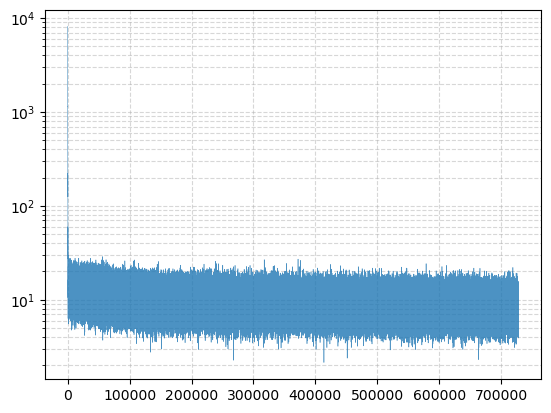

In [301]:
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.semilogy(loss_data_optimal, linewidth=0.4, alpha=0.8)

In [300]:
predicted, actual = model_optimal.evaluate(test_dataloader, device="cpu")
print(f"Average percentage point difference: {np.mean(abs(actual - predicted)):1.3f}")
print(f"Mean squared error (loss criterion): {np.mean(abs(np.square(actual - predicted))):2.3f}")

Average percentage point difference: 2.409
Mean squared error (loss criterion): 10.213


Example: 4% unemployment, Alabama, in Administrative and Support and Waste Management and Remediation Services

In [346]:
sample_input = torch.tensor(np.concatenate([
    np.array([4]).reshape(-1, 1), 
    train_dataset.state_encoder.transform([[1]]).reshape(-1, 1), 
    train_dataset.industry_encoder.transform([[1]]).reshape(-1, 1)
], axis=0), dtype=torch.float32).T

/Users/sebastian/opt/anaconda3/envs/PIC16B-25W/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/Users/sebastian/opt/anaconda3/envs/PIC16B-25W/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


In [347]:
print(f"Year on Year Survival Rate: {float(model_optimal(sample_input)):1.2f}%")

Year on Year Survival Rate: 90.40%


Example 2: 15% unemployment, Florida, Information Industry

In [348]:
sample_input = torch.tensor(np.concatenate([
    np.array([15]).reshape(-1, 1), 
    train_dataset.state_encoder.transform([[9]]).reshape(-1, 1), 
    train_dataset.industry_encoder.transform([[8]]).reshape(-1, 1)
], axis=0), dtype=torch.float32).T

/Users/sebastian/opt/anaconda3/envs/PIC16B-25W/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/Users/sebastian/opt/anaconda3/envs/PIC16B-25W/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


In [349]:
print(f"Year on Year Survival Rate: {float(model_optimal(sample_input)):1.2f}%")

Year on Year Survival Rate: 85.64%


In [358]:
numerical_industry_rev[0]

'Accommodation and Food Services'

/Users/sebastian/opt/anaconda3/envs/PIC16B-25W/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/Users/sebastian/opt/anaconda3/envs/PIC16B-25W/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/Users/sebastian/opt/anaconda3/envs/PIC16B-25W/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/Users/sebastian/opt/anaconda3/envs/PIC16B-25W/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/Users/sebastian/opt/anaconda3/envs/PIC16B-25W/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but O

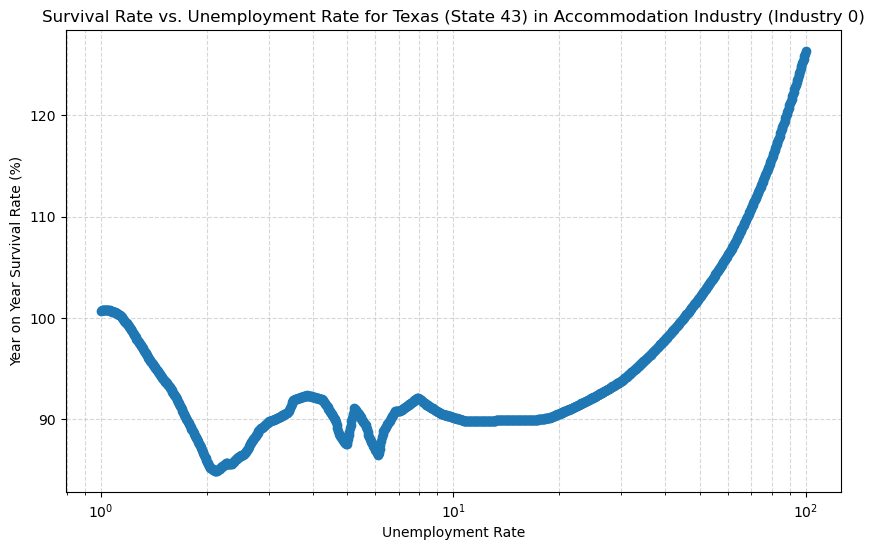

In [370]:
# Generate unemployment values in logspace
unemployment_values = np.logspace(0, 2, num=1000)  # From 1 to 100 in logspace

# Prepare the sample inputs for each unemployment value
sample_inputs = [torch.tensor(np.concatenate([
    np.array([unemployment]).reshape(-1, 1), 
    train_dataset.state_encoder.transform([[43]]).reshape(-1, 1), 
    train_dataset.industry_encoder.transform([[0]]).reshape(-1, 1)
], axis=0), dtype=torch.float32).T for unemployment in unemployment_values]

# Predict the survival rates for each sample input
survival_rates = [float(model_optimal(sample_input)) for sample_input in sample_inputs]

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(unemployment_values, survival_rates, marker='o')
plt.xscale('log')
plt.xlabel('Unemployment Rate')
plt.ylabel('Year on Year Survival Rate (%)')
plt.title('Survival Rate vs. Unemployment Rate for Texas (State 43) in Accommodation Industry (Industry 0)')
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()

In [366]:
print(f"Year on Year Survival Rate: {float(model_optimal(sample_input)):1.2f}%")

Year on Year Survival Rate: 90.58%
